In [69]:
samples = [f"mada_{i}" for i in ["102", "104", "1-44", "116", "125", "130", "132"]]

In [70]:
from pathlib import Path
from multiprocessing import Pool
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [71]:
!bcftools --version

bcftools 1.13
Using htslib 1.13
Copyright (C) 2021 Genome Research Ltd.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.


In [113]:
aln_dir = Path("../nanopore/mapped/madagascar/")
pileup_id =  "v113maxBAQ60F0.02"
call_dir = Path("calls") / pileup_id
call_dir.mkdir(exist_ok=True)

Run `bcftools` on the reads

In [114]:
h37rv = "../resources/h37rv.fa"
mask = "../resources/compass-mask.bed"

In [115]:
def bcftools_call(aln, mpileup_opts, call_opts):
    !( bcftools mpileup {mpileup_opts} {aln} | bcftools call {call_opts} ) 2> /dev/null

In [116]:

with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        aln = aln_dir / f"{s}.sorted.sam"
        output = call_dir / f"{s}.calls.vcf.gz"
        mpileup_opts = f"-I -x -f {h37rv} --threads 6 -Q 13 -a 'INFO/SCR,FORMAT/SP,INFO/ADR,INFO/ADF' -Ou -h100 -M100000 -F0.002"
        call_opts = f"-Oz --ploidy 1 --threads 6 -V indels -m -o {output}"
        jobs.append((aln, mpileup_opts, call_opts))
    pool.starmap(bcftools_call, jobs)

In [78]:
def bcftools_index(vcf, opts=""):
    !bcftools index {opts} {vcf}

In [79]:
truth_dir = Path("truth")
truth_dir.mkdir(exist_ok=True)

In [80]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        vcf = call_dir / f"{s}.calls.vcf.gz"
        opts = "-f"
        jobs.append((vcf, opts))
    pool.starmap(bcftools_index, jobs)

In [9]:
def bcftools_bgzip(vcf, output, opts):
    !bcftools view {opts} -o {output} {vcf}

In [12]:
# with Pool(processes=7) as pool:
#     bgzip_jobs = []
#     index_jobs = []
#     for s in samples:
#         truth = f"../truth_eval/{s}/bcftools/recall/truth_vcf/04.truth.vcf"
#         output = truth_dir / f"{s}.truth.vcf.gz"
#         opts = "-Oz"
#         bgzip_jobs.append((truth, output, opts))
#         index_jobs.append((output, ""))
#     pool.starmap(bcftools_bgzip, bgzip_jobs)
#     pool.starmap(bcftools_index, index_jobs)

In [10]:
def bcftools_isec(truth, query, opts):
    !bcftools isec {opts} {truth} {query}

In [78]:
isec_dir = Path("isec")
isec_dir.mkdir(exist_ok=True)

with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        query = call_dir / f"{s}.calls.vcf.gz"
        truth = truth_dir / f"{s}.truth.vcf.gz"
        prefix = isec_dir / s
        opts = f"-p {prefix} -c both -T ^{mask}"
        jobs.append((truth, query, opts))
    pool.starmap(bcftools_isec, jobs)

In [11]:
def bcftools_query(vcf, output, opts):
    !bcftools query {opts} {vcf} > {output}

In [79]:
stats_dir = Path("stats")
stats_dir.mkdir(exist_ok=True)

with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.qual"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.qual"
        opts = f"-i 'TYPE=\"SNP\"' -f '%QUAL\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [81]:
dfs = []
for s in samples:
    d = pd.read_csv(stats_dir / f"{s}.false.qual", header=None, names=["qual"])
    d["class"] = "false"
    dfs.append(d)

In [82]:
for s in samples:
    d = pd.read_csv(stats_dir / f"{s}.true.qual", header=None, names=["qual"])
    d["class"] = "true"
    dfs.append(d)

In [83]:
df = pd.concat(dfs).reset_index()

[Text(0, 0, '0'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(30, 0, '30'),
 Text(40, 0, '40'),
 Text(50, 0, '50'),
 Text(60, 0, '60'),
 Text(70, 0, '70'),
 Text(75, 0, '75'),
 Text(80, 0, '80'),
 Text(100, 0, '100')]

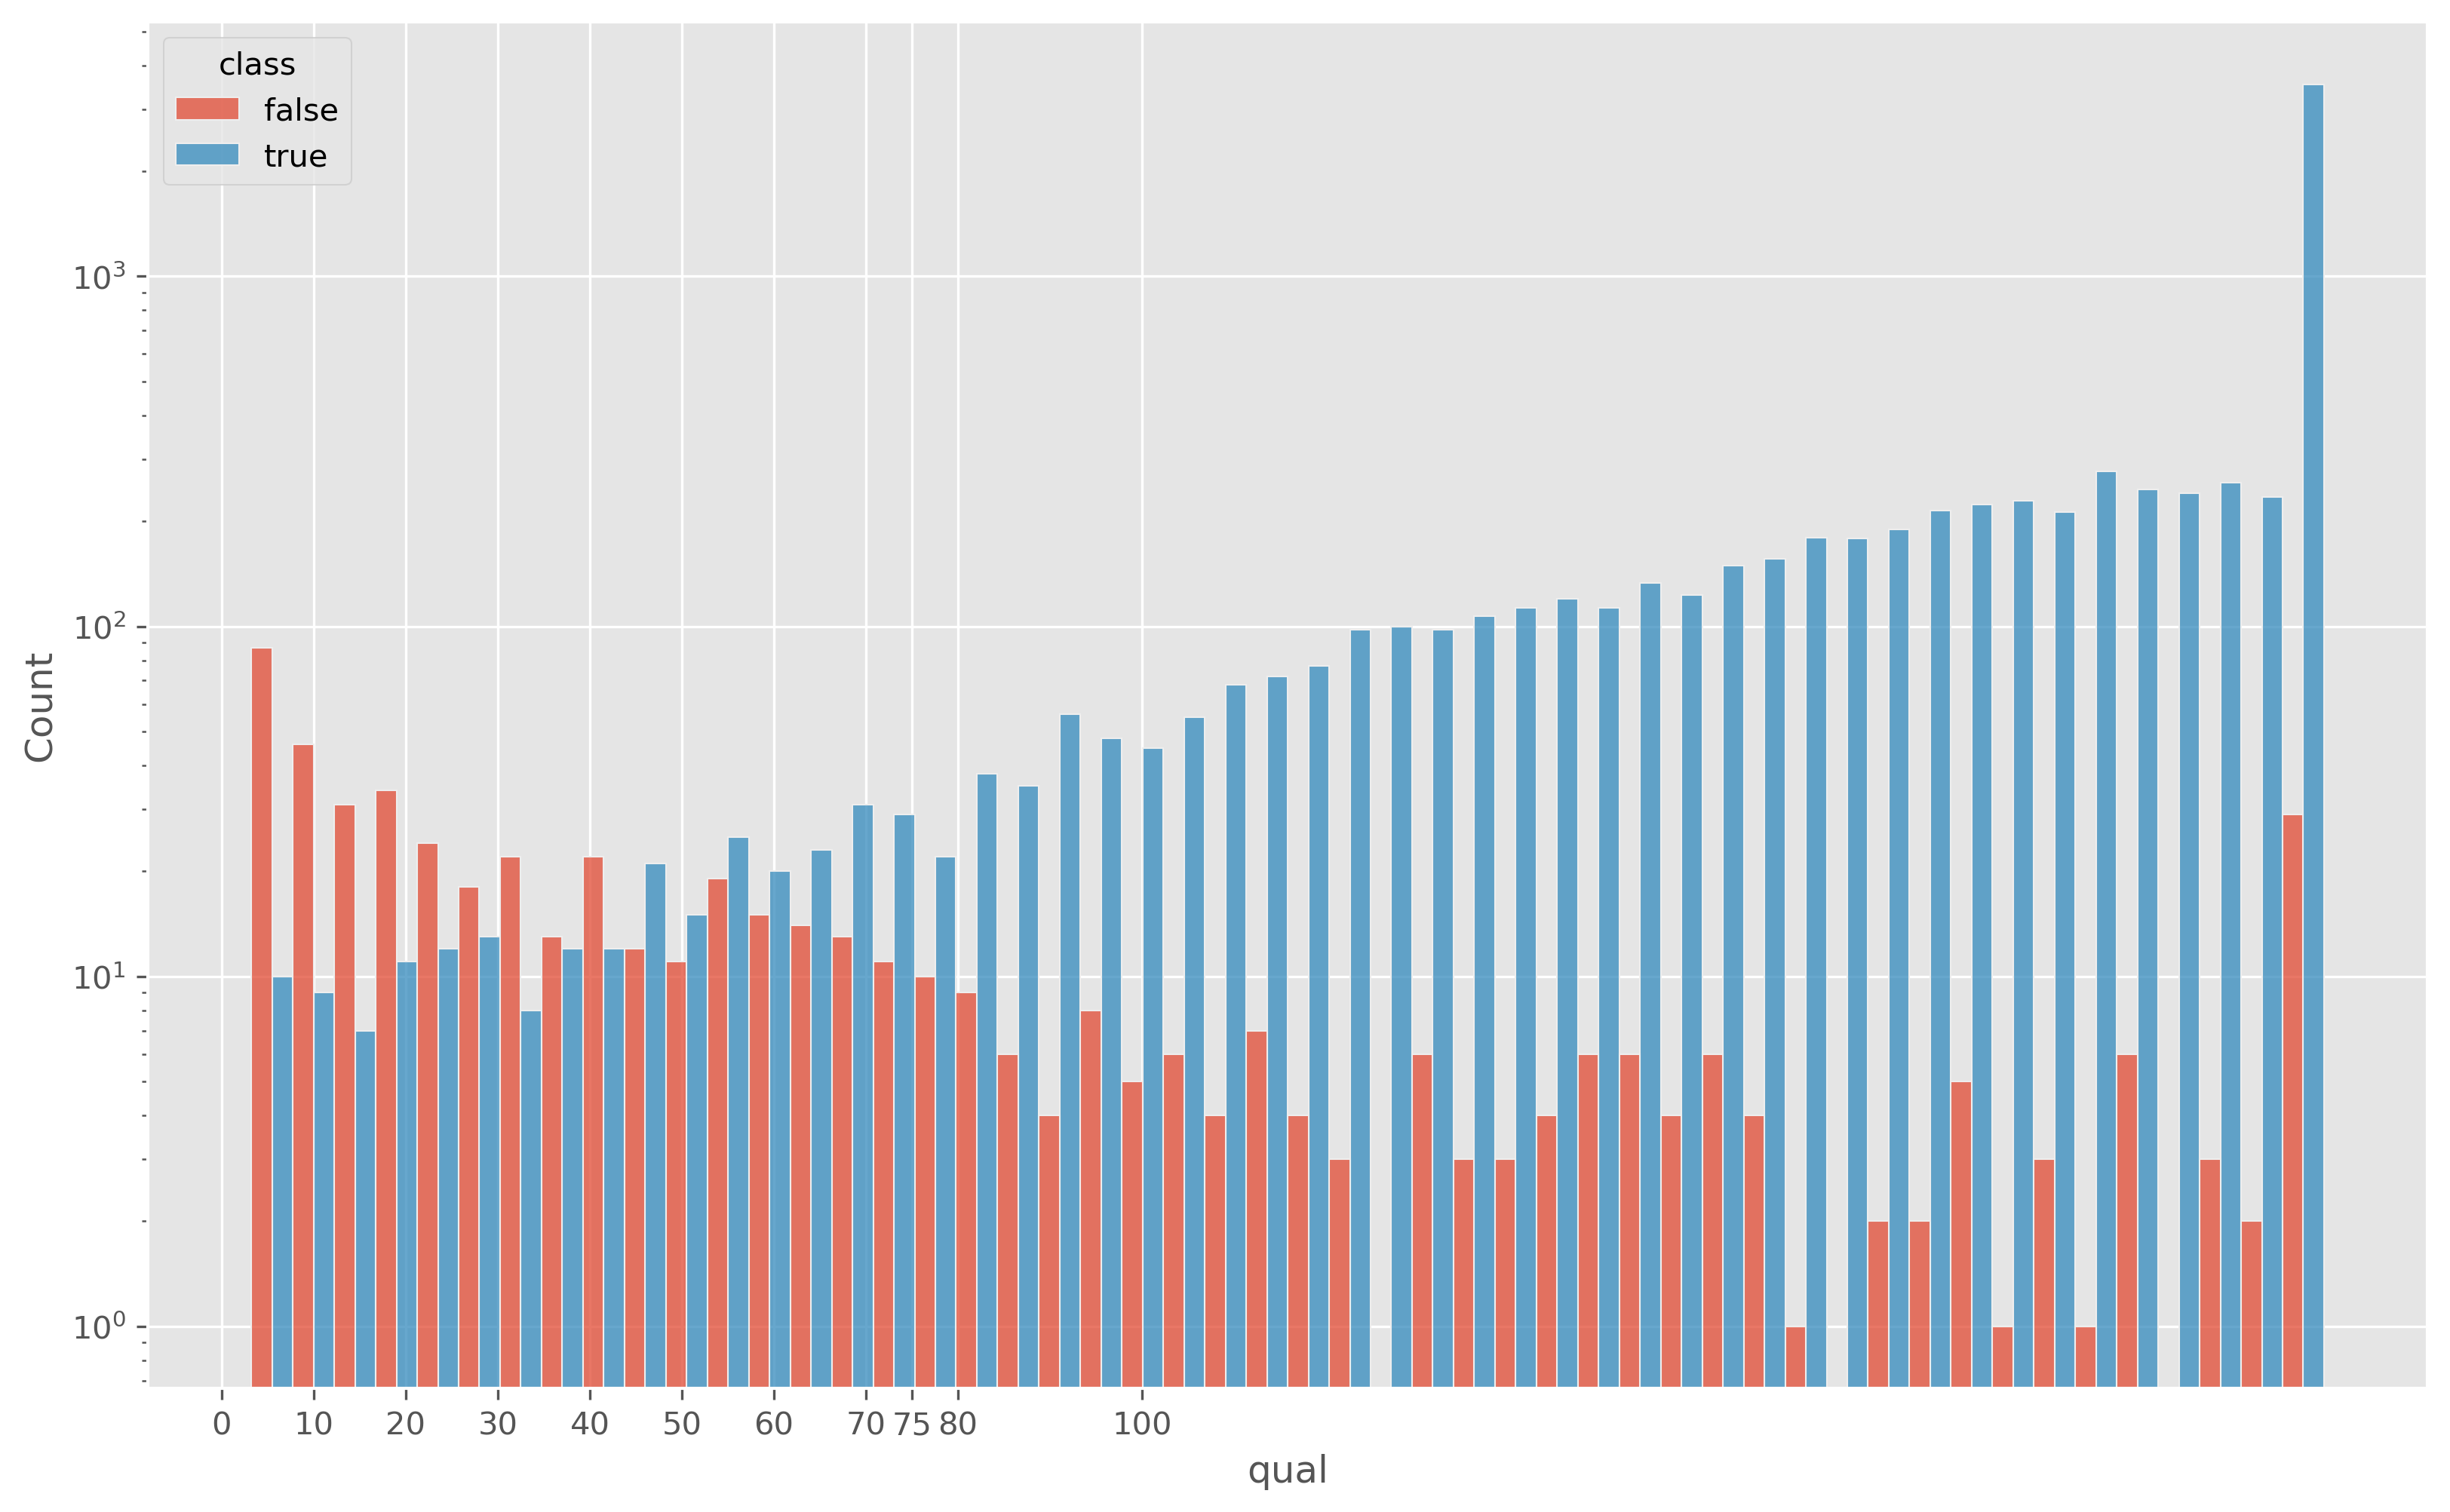

In [85]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df.query("qual<1000"), x="qual", hue="class", multiple="dodge", bins=50)
ax.set_yscale("log")
xlabels = [0, 10, 20, 30, 40, 50, 60, 70, 75, 80, 100]
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)

In [86]:
ts = []
fs = []
for i in range(5, 100):
    f, t = df.query("qual<@i").groupby(["class"])["qual"].count()
    fs.append(f)
    ts.append(t)

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 2000, '2000')]

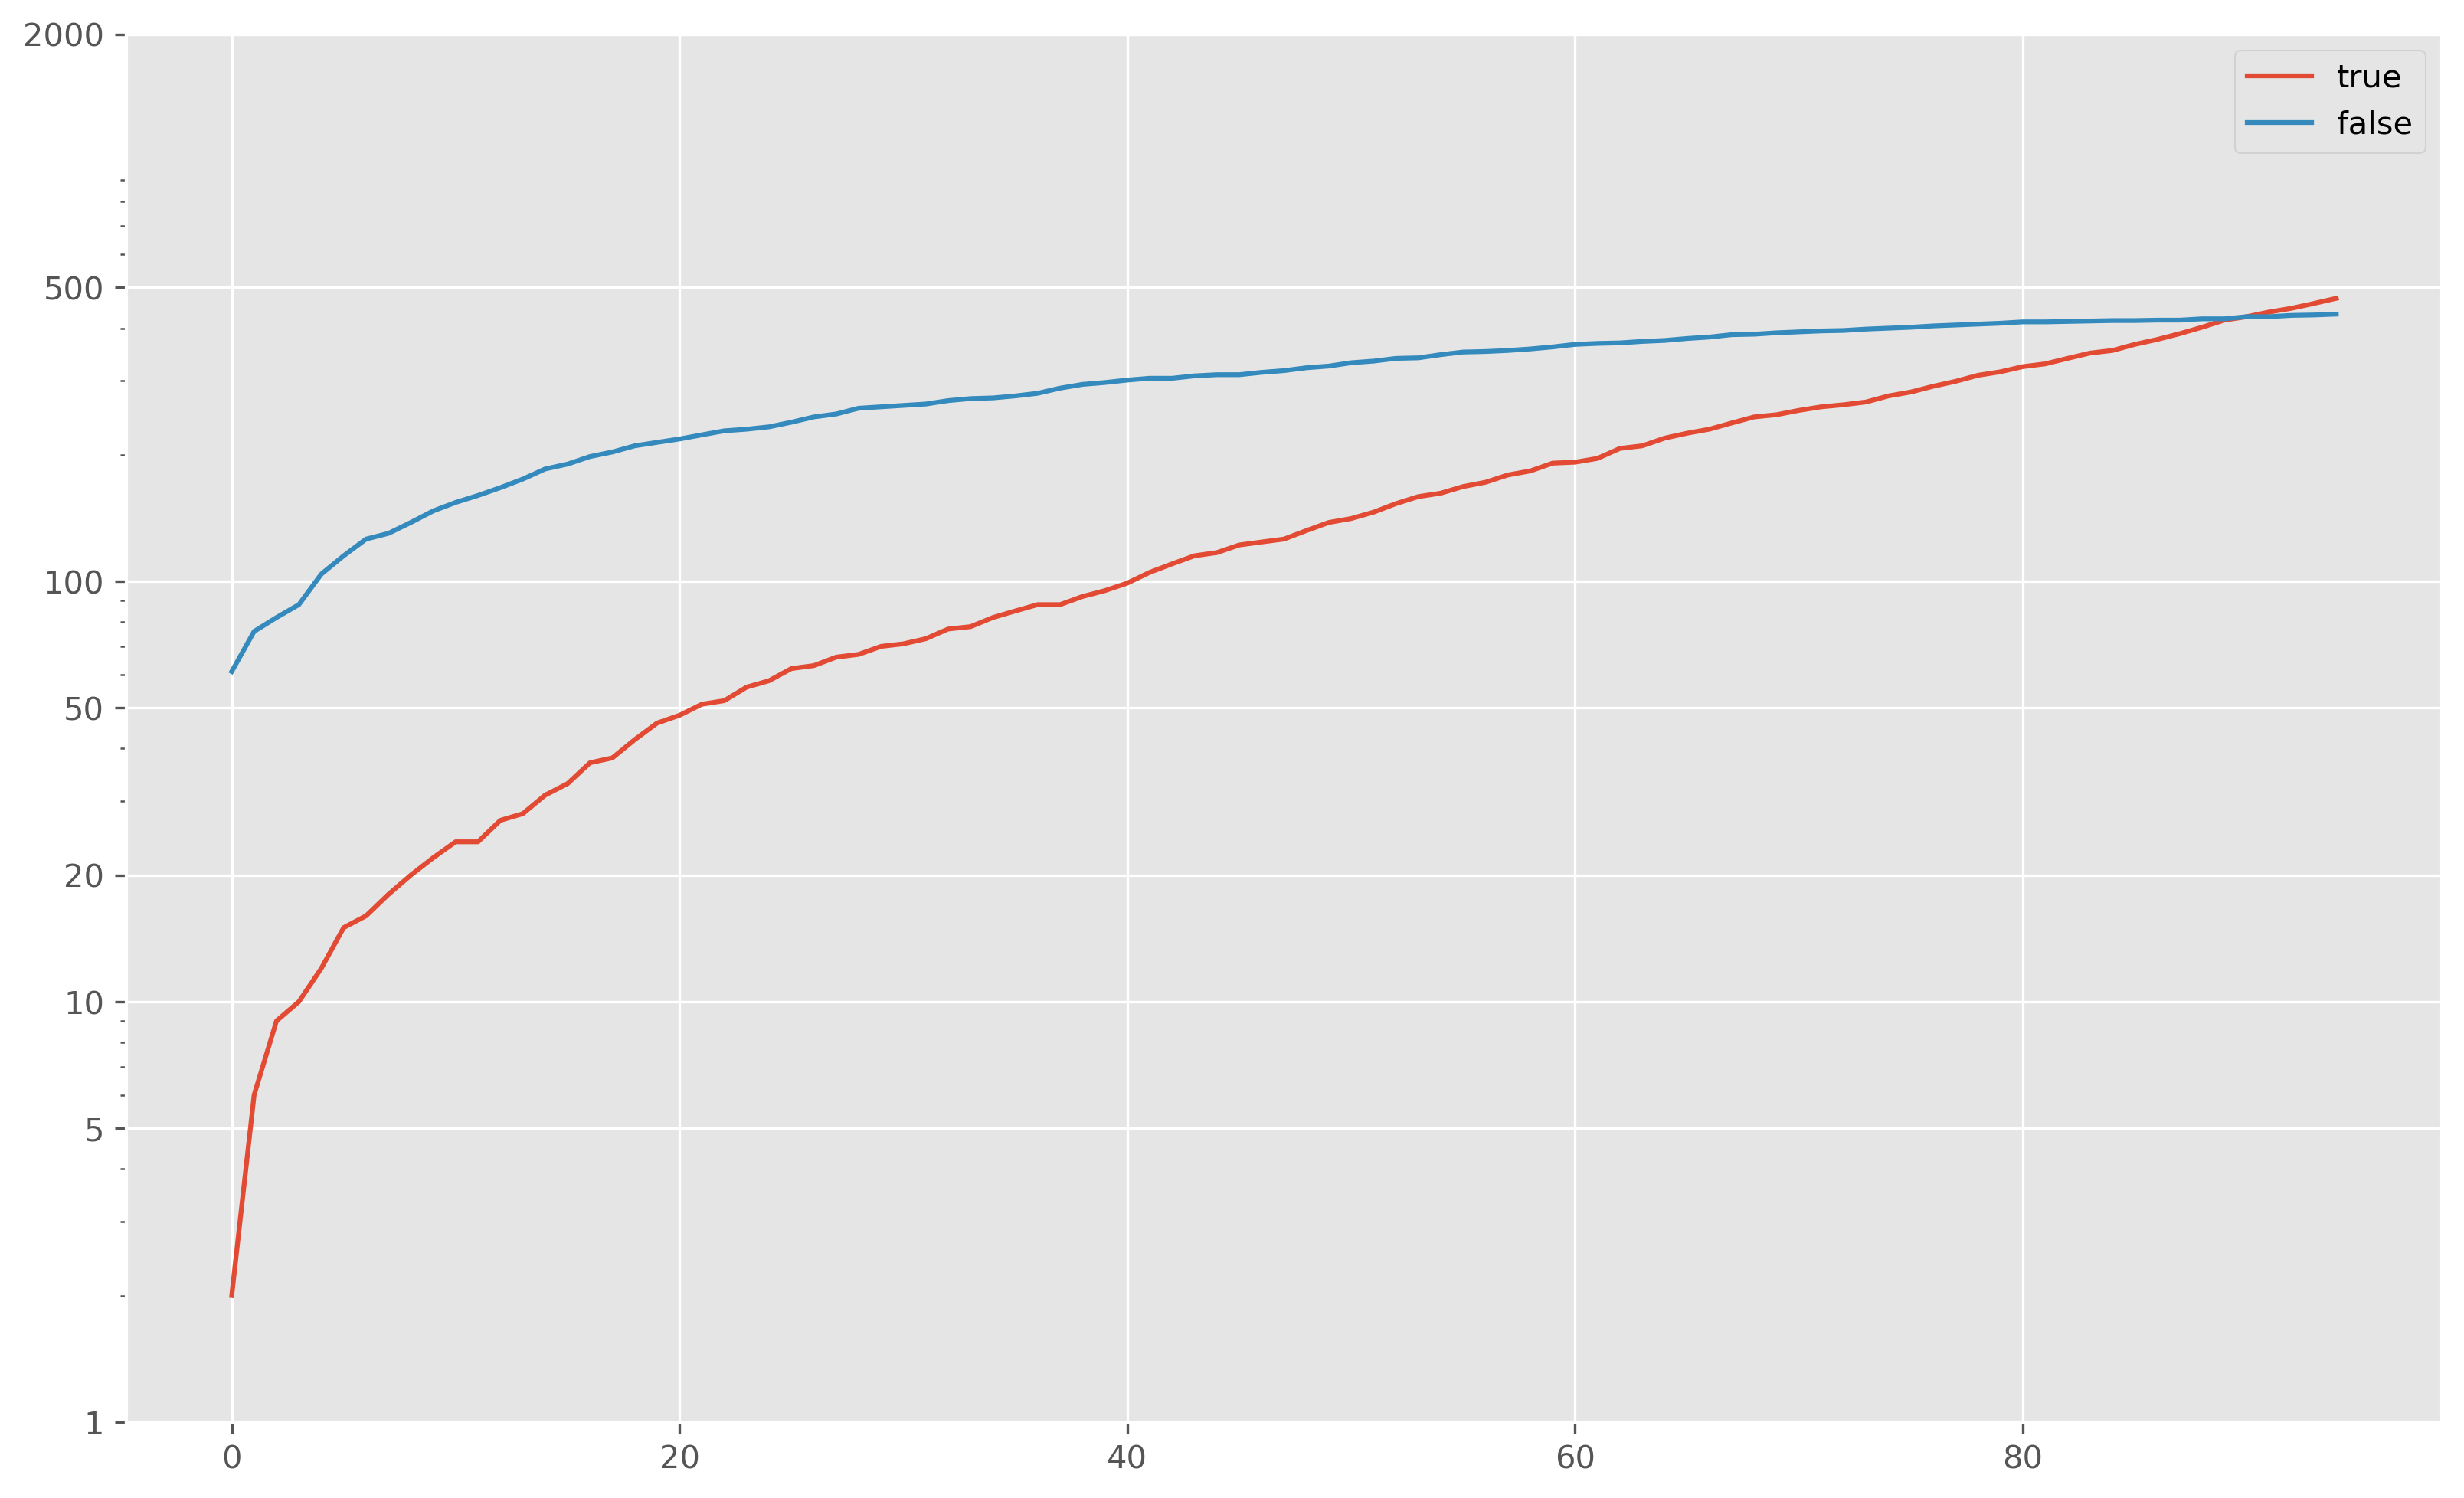

In [87]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
ax.plot(ts, label="true")
ax.plot(fs, label="false")
ax.legend()
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)

In [88]:
ratios = []
for x, y in zip(ts, fs):
    total = x+y
    r = y/total
    ratios.append(r)

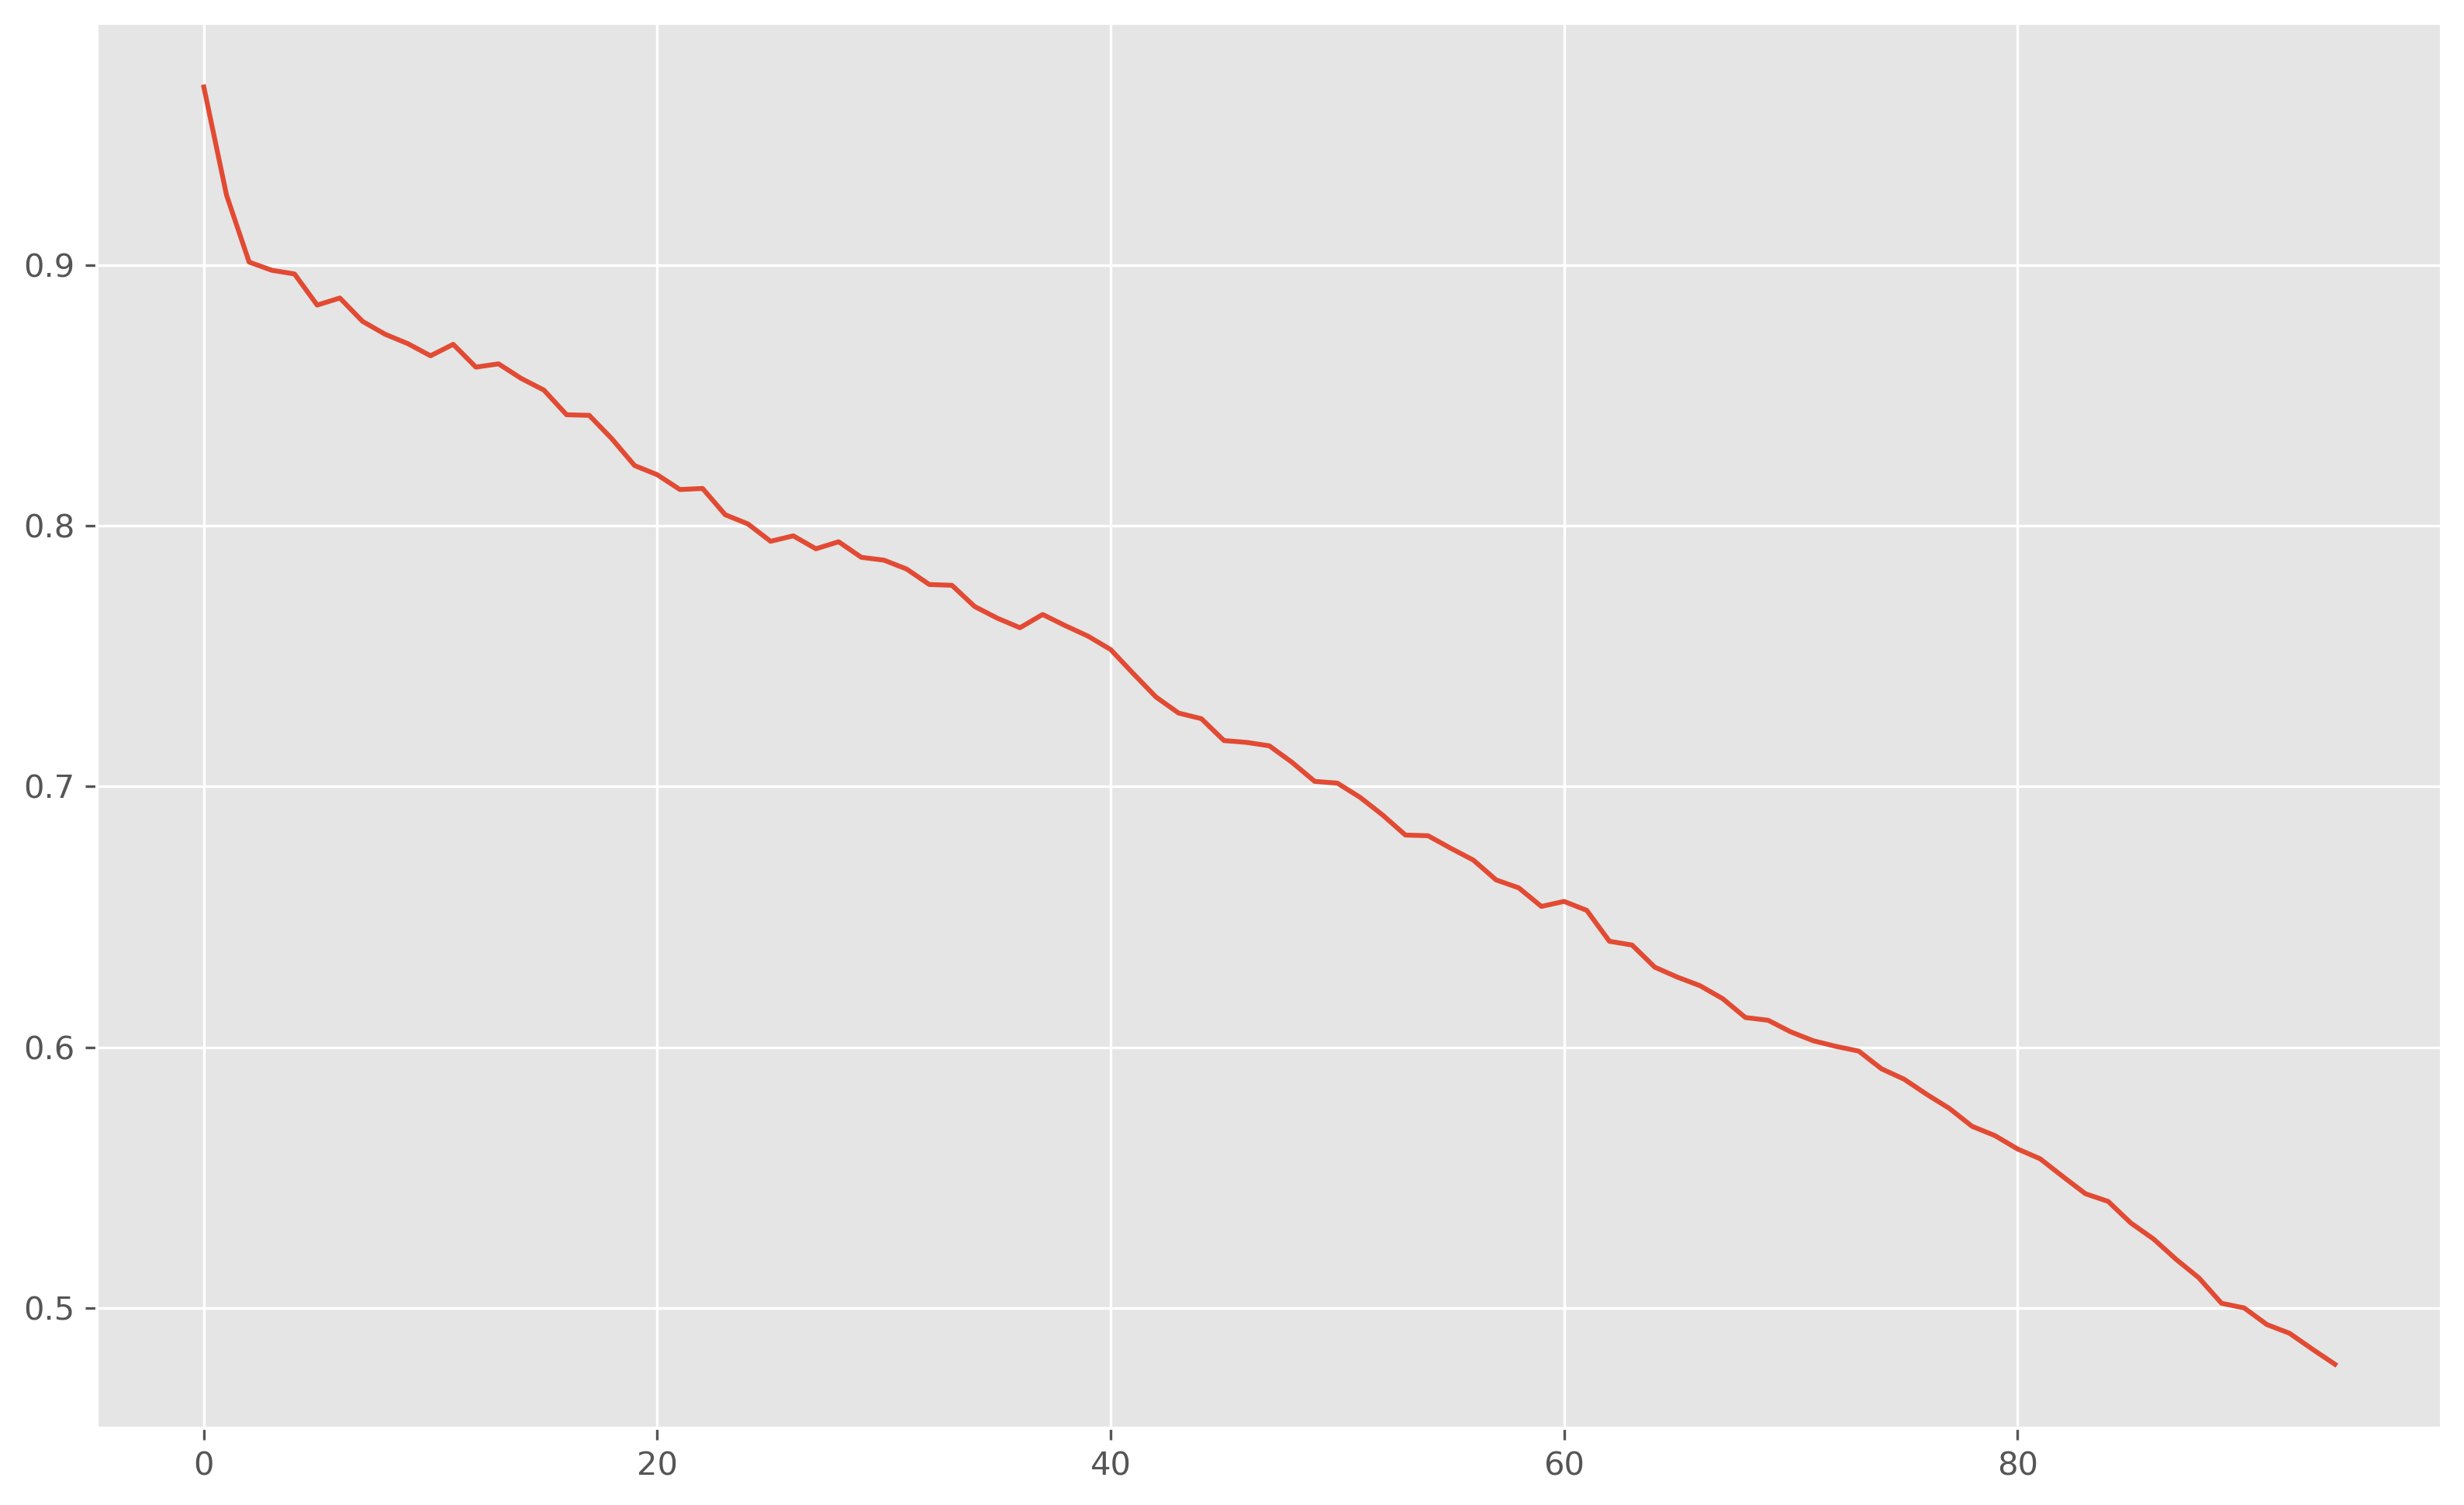

In [89]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
ax.plot(ratios)
# ax.legend()
# ax.set_yscale("log")
# ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)

In [90]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.depth"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.depth"
        opts = f"-i 'TYPE=\"SNP\"' -f '%DP\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [91]:
depths = []
for s in samples:
    depths.extend([float(x) for x in open(stats_dir / f"{s}.false.depth").read().splitlines() if x])
    depths.extend([float(x) for x in open(stats_dir / f"{s}.true.depth").read().splitlines() if x])

df["depth"] = depths

[Text(0, 0, '0'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(30, 0, '30'),
 Text(40, 0, '40'),
 Text(50, 0, '50'),
 Text(60, 0, '60'),
 Text(70, 0, '70'),
 Text(80, 0, '80'),
 Text(100, 0, '100'),
 Text(150, 0, '150'),
 Text(200, 0, '200')]

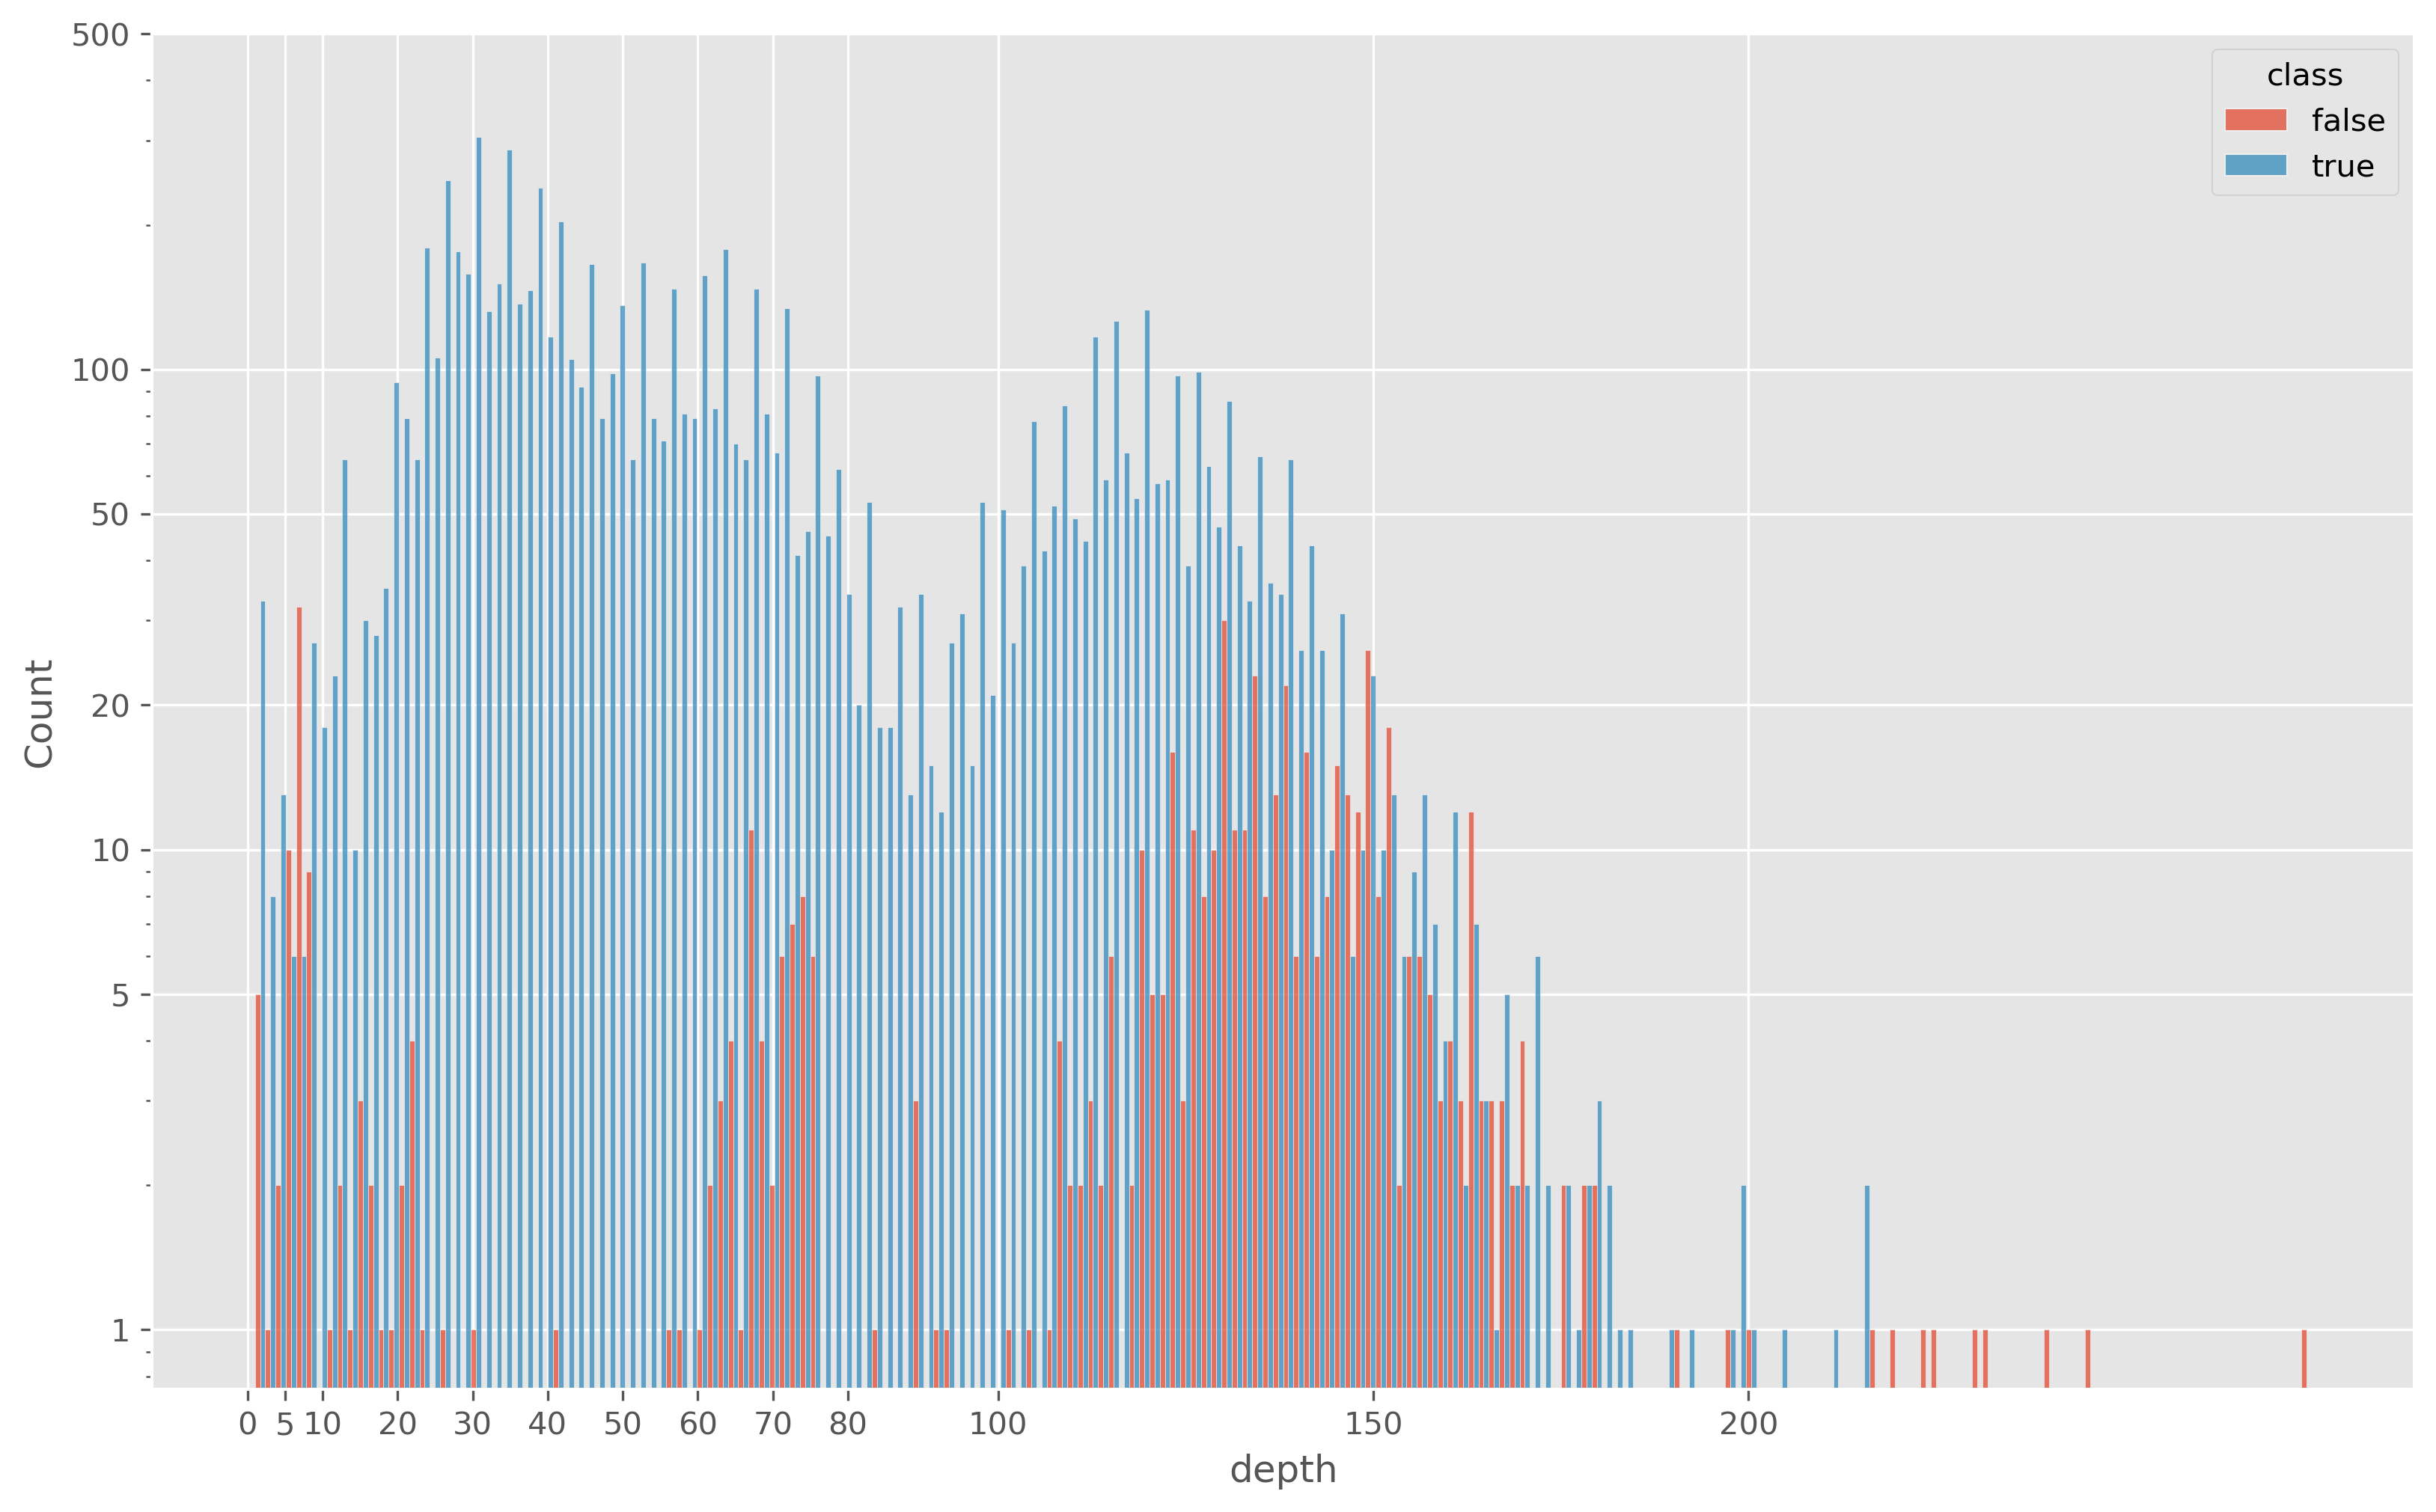

In [92]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="depth", hue="class", multiple="dodge", bins=200)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
xlabels = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200]
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
# ax.set_xlim((0, 20))

In [93]:
# calculate percentage of median depth
from cyvcf2 import VCF
import numpy as np

median_depths = {}
for s in samples:
    vcf = call_dir / f"{s}.calls.vcf.gz"
    dps = [r.INFO["DP"] for r in VCF(vcf)]
    med = np.median(dps)
    median_depths[s] = med
        
median_depths

{'mada_102': 145.0,
 'mada_104': 33.0,
 'mada_1-44': 121.0,
 'mada_116': 70.0,
 'mada_125': 59.0,
 'mada_130': 41.0,
 'mada_132': 28.0}

In [94]:
rel_depths = []
for s in samples:
    med = median_depths[s]
    rel_depths.extend([float(x)/med for x in open(stats_dir / f"{s}.false.depth").read().splitlines() if x])
    rel_depths.extend([float(x)/med for x in open(stats_dir / f"{s}.true.depth").read().splitlines() if x])

df["rel_depth"] = rel_depths

(0.0, 0.2)

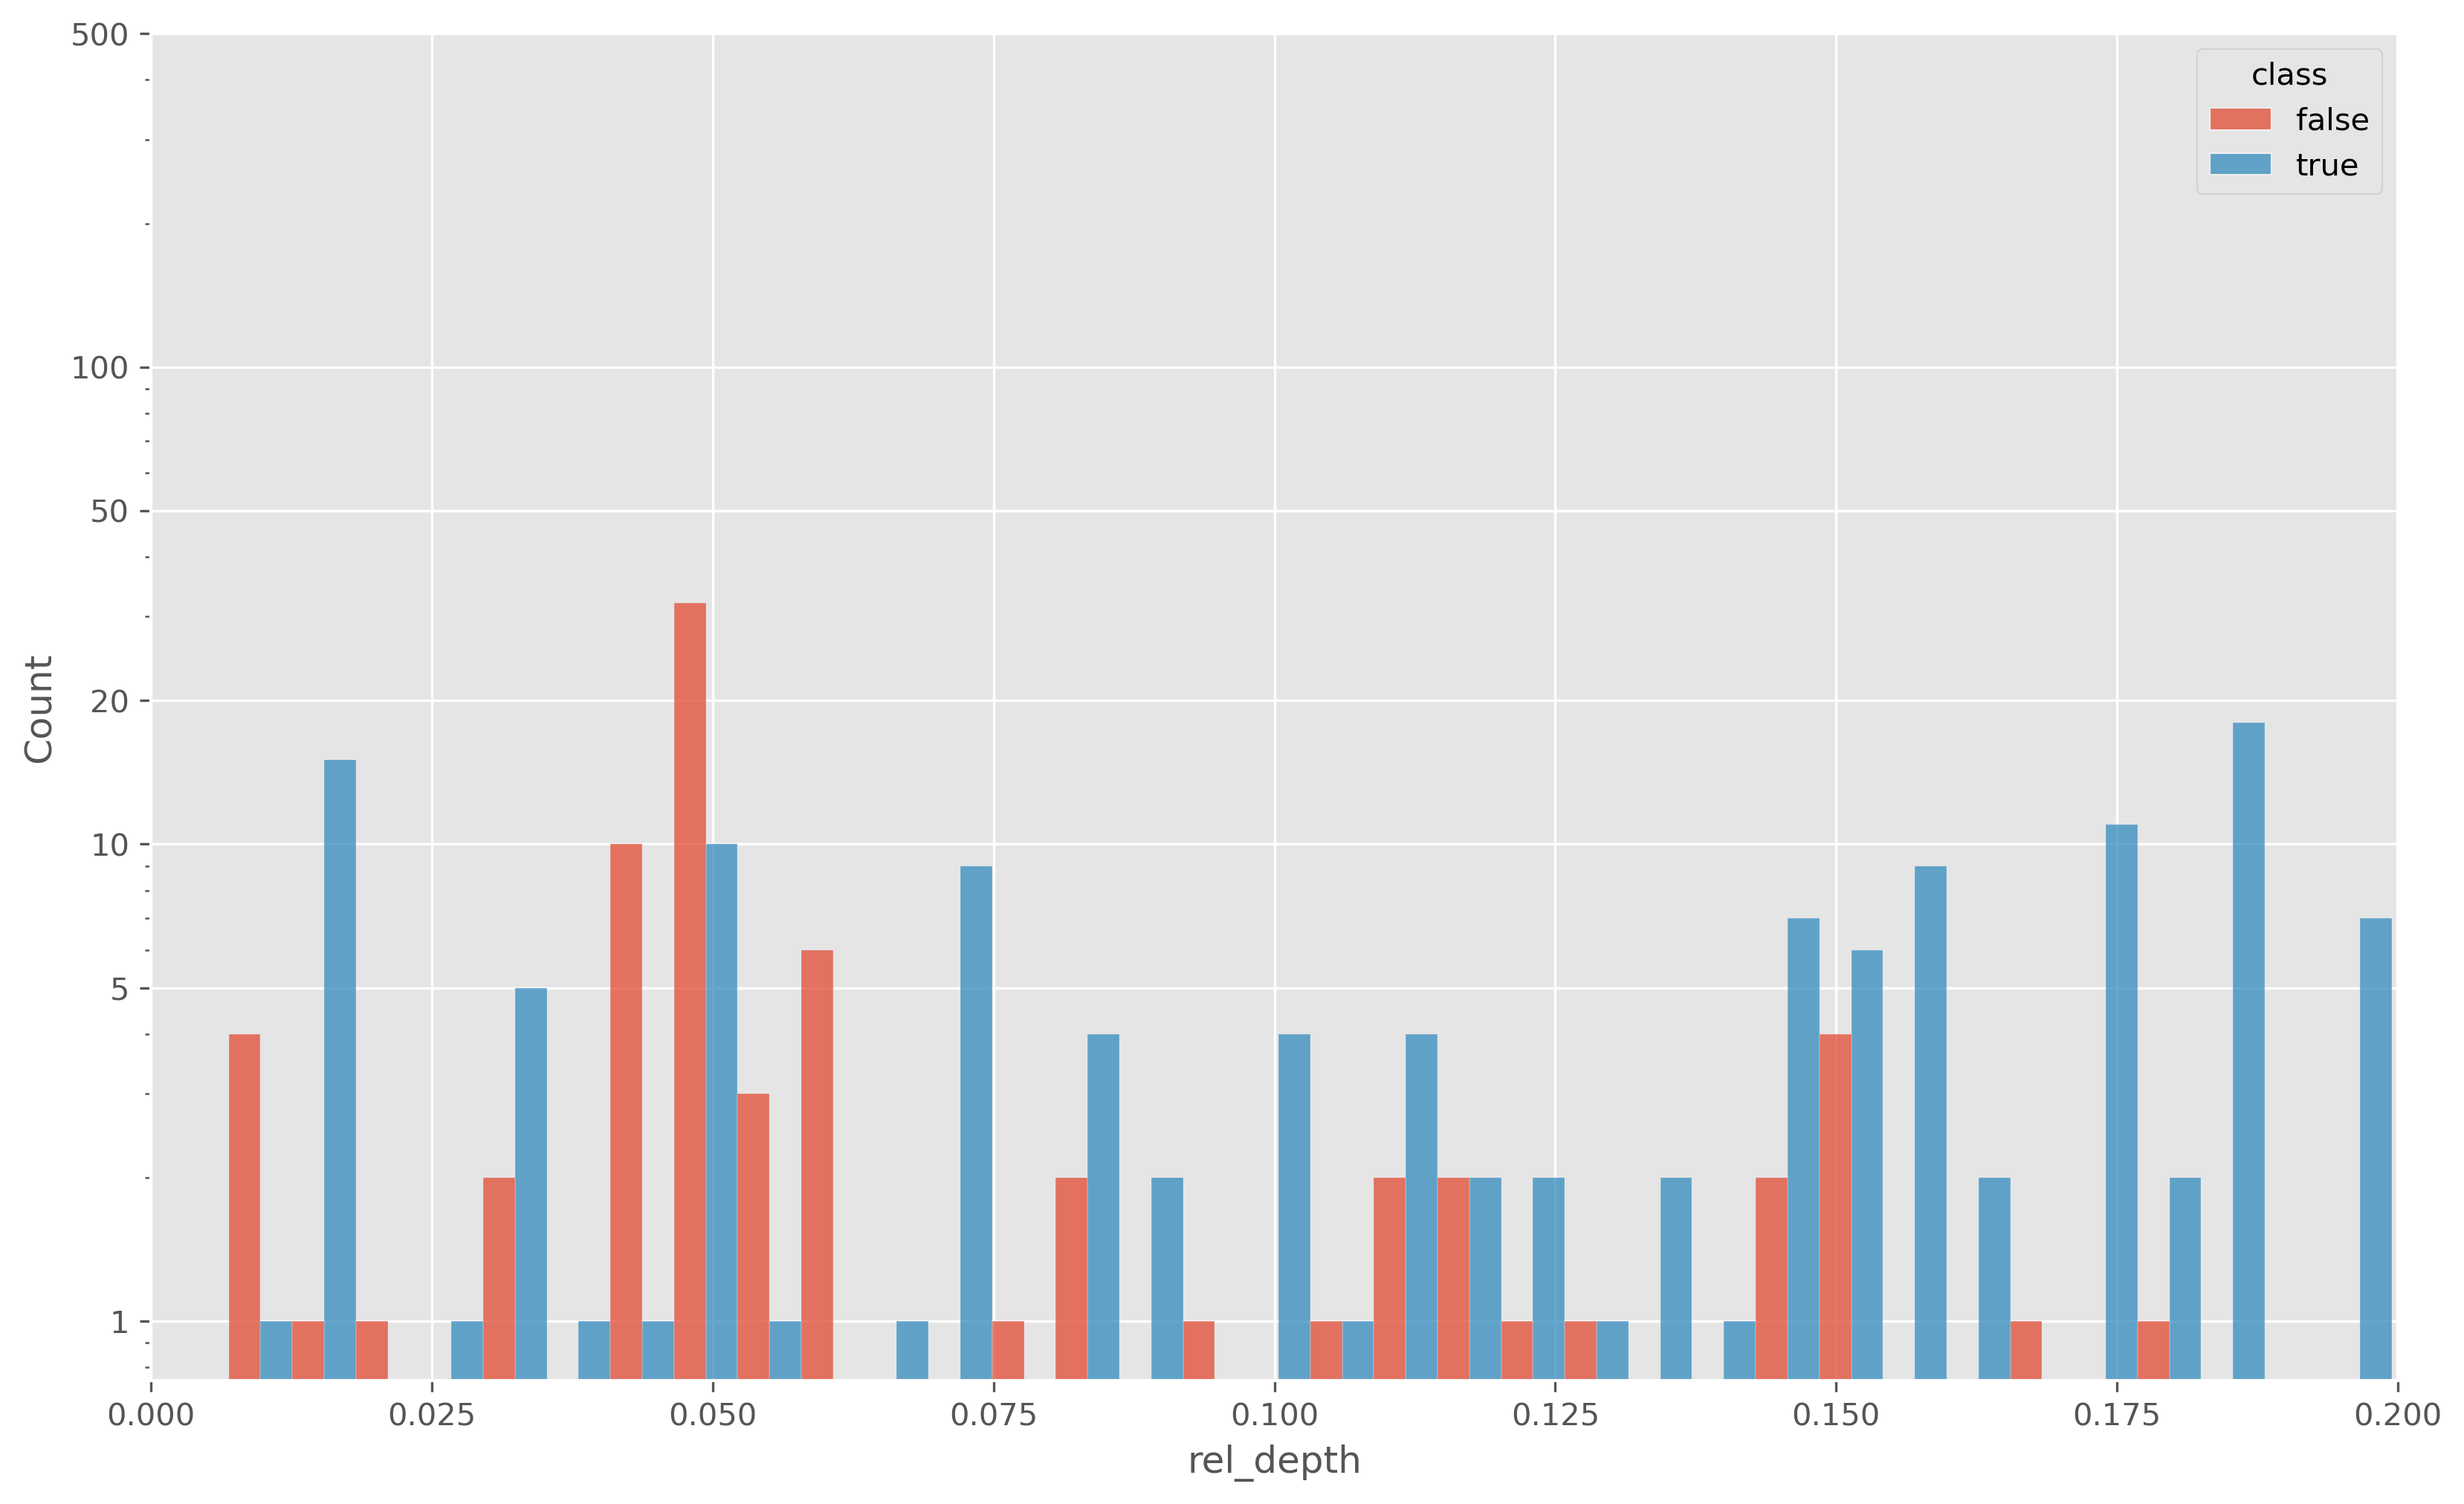

In [97]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="rel_depth", hue="class", multiple="dodge", bins=400)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# xlabels = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200]
# ax.set_xticks(xlabels)
# ax.set_xticklabels(xlabels)
ax.set_xlim((0, 0.2))

In [98]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.mqbz"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.mqbz"
        opts = f"-i 'TYPE=\"SNP\"' -f '%MQBZ\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [99]:
mqbz = []
for s in samples:
    mqbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.mqbz").read().splitlines() if x])
    mqbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.mqbz").read().splitlines() if x])

df["mqbz"] = mqbz

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 800, '800')]

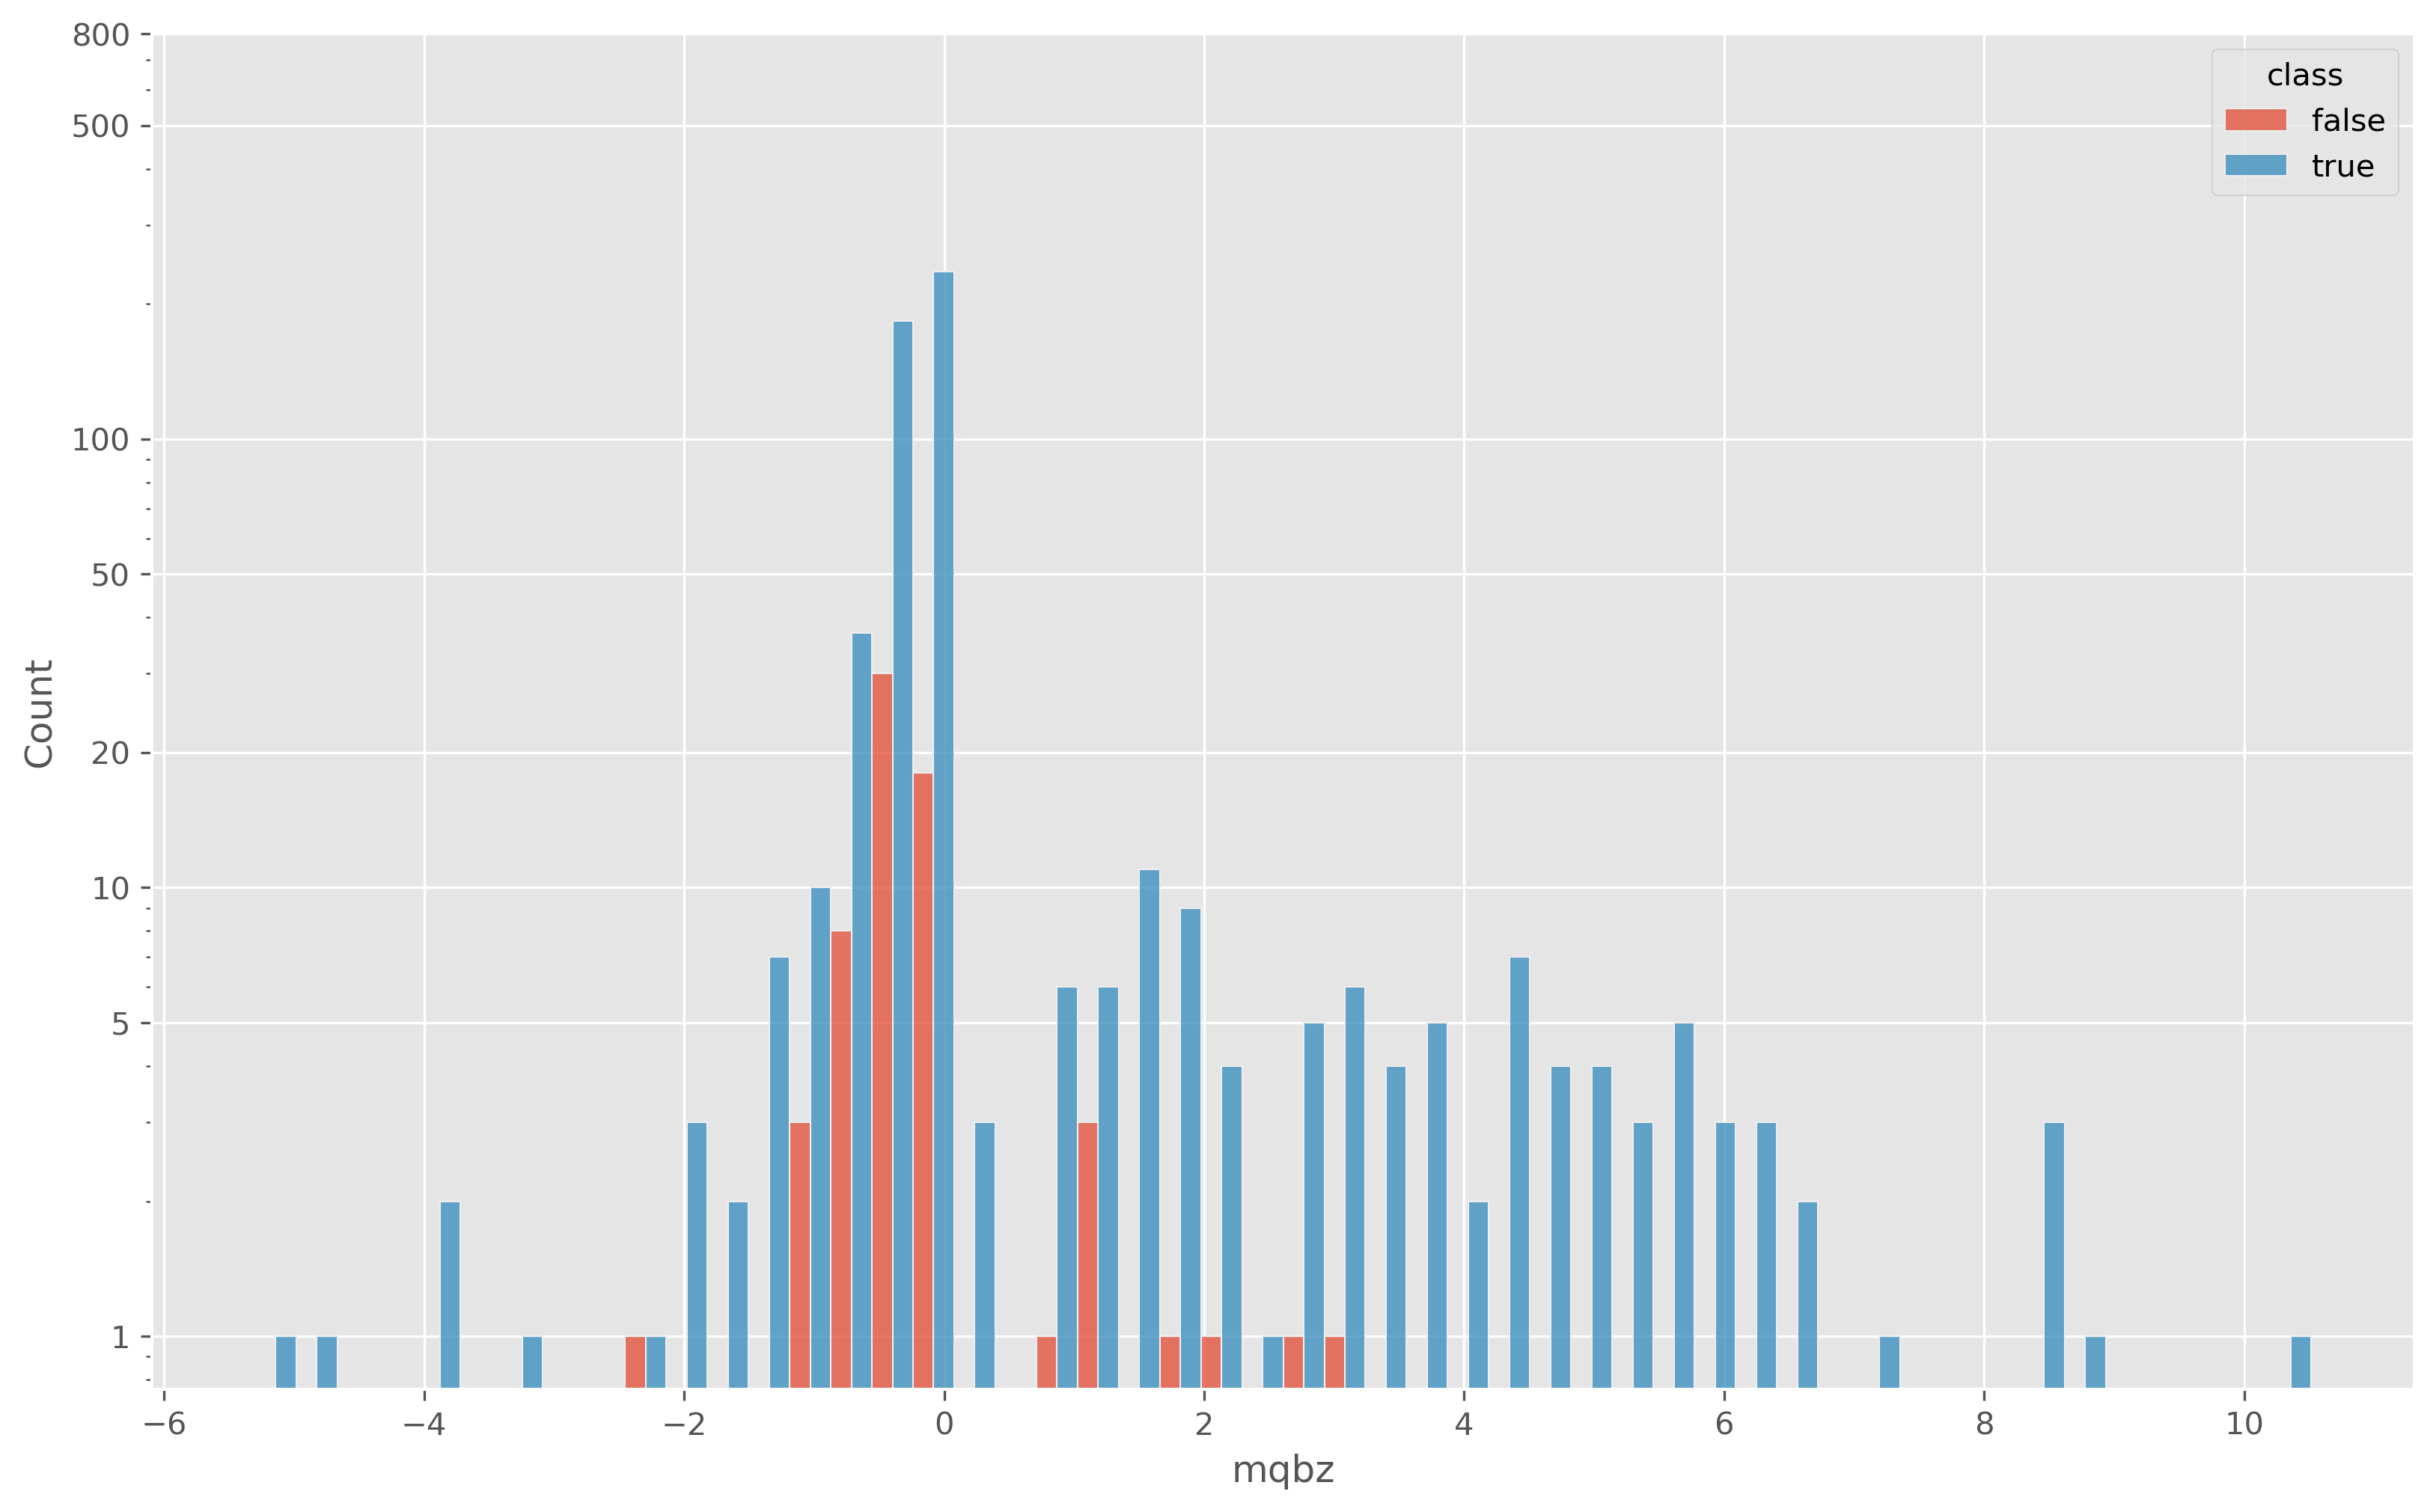

In [100]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="mqbz", hue="class", multiple="dodge", bins=50)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 800]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)

In [101]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.rpbz"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.rpbz"
        opts = f"-i 'TYPE=\"SNP\"' -f '%RPBZ\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [102]:
rpbz = []
for s in samples:
    rpbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.rpbz").read().splitlines() if x])
    rpbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.rpbz").read().splitlines() if x])

df["rpbz"] = rpbz

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500')]

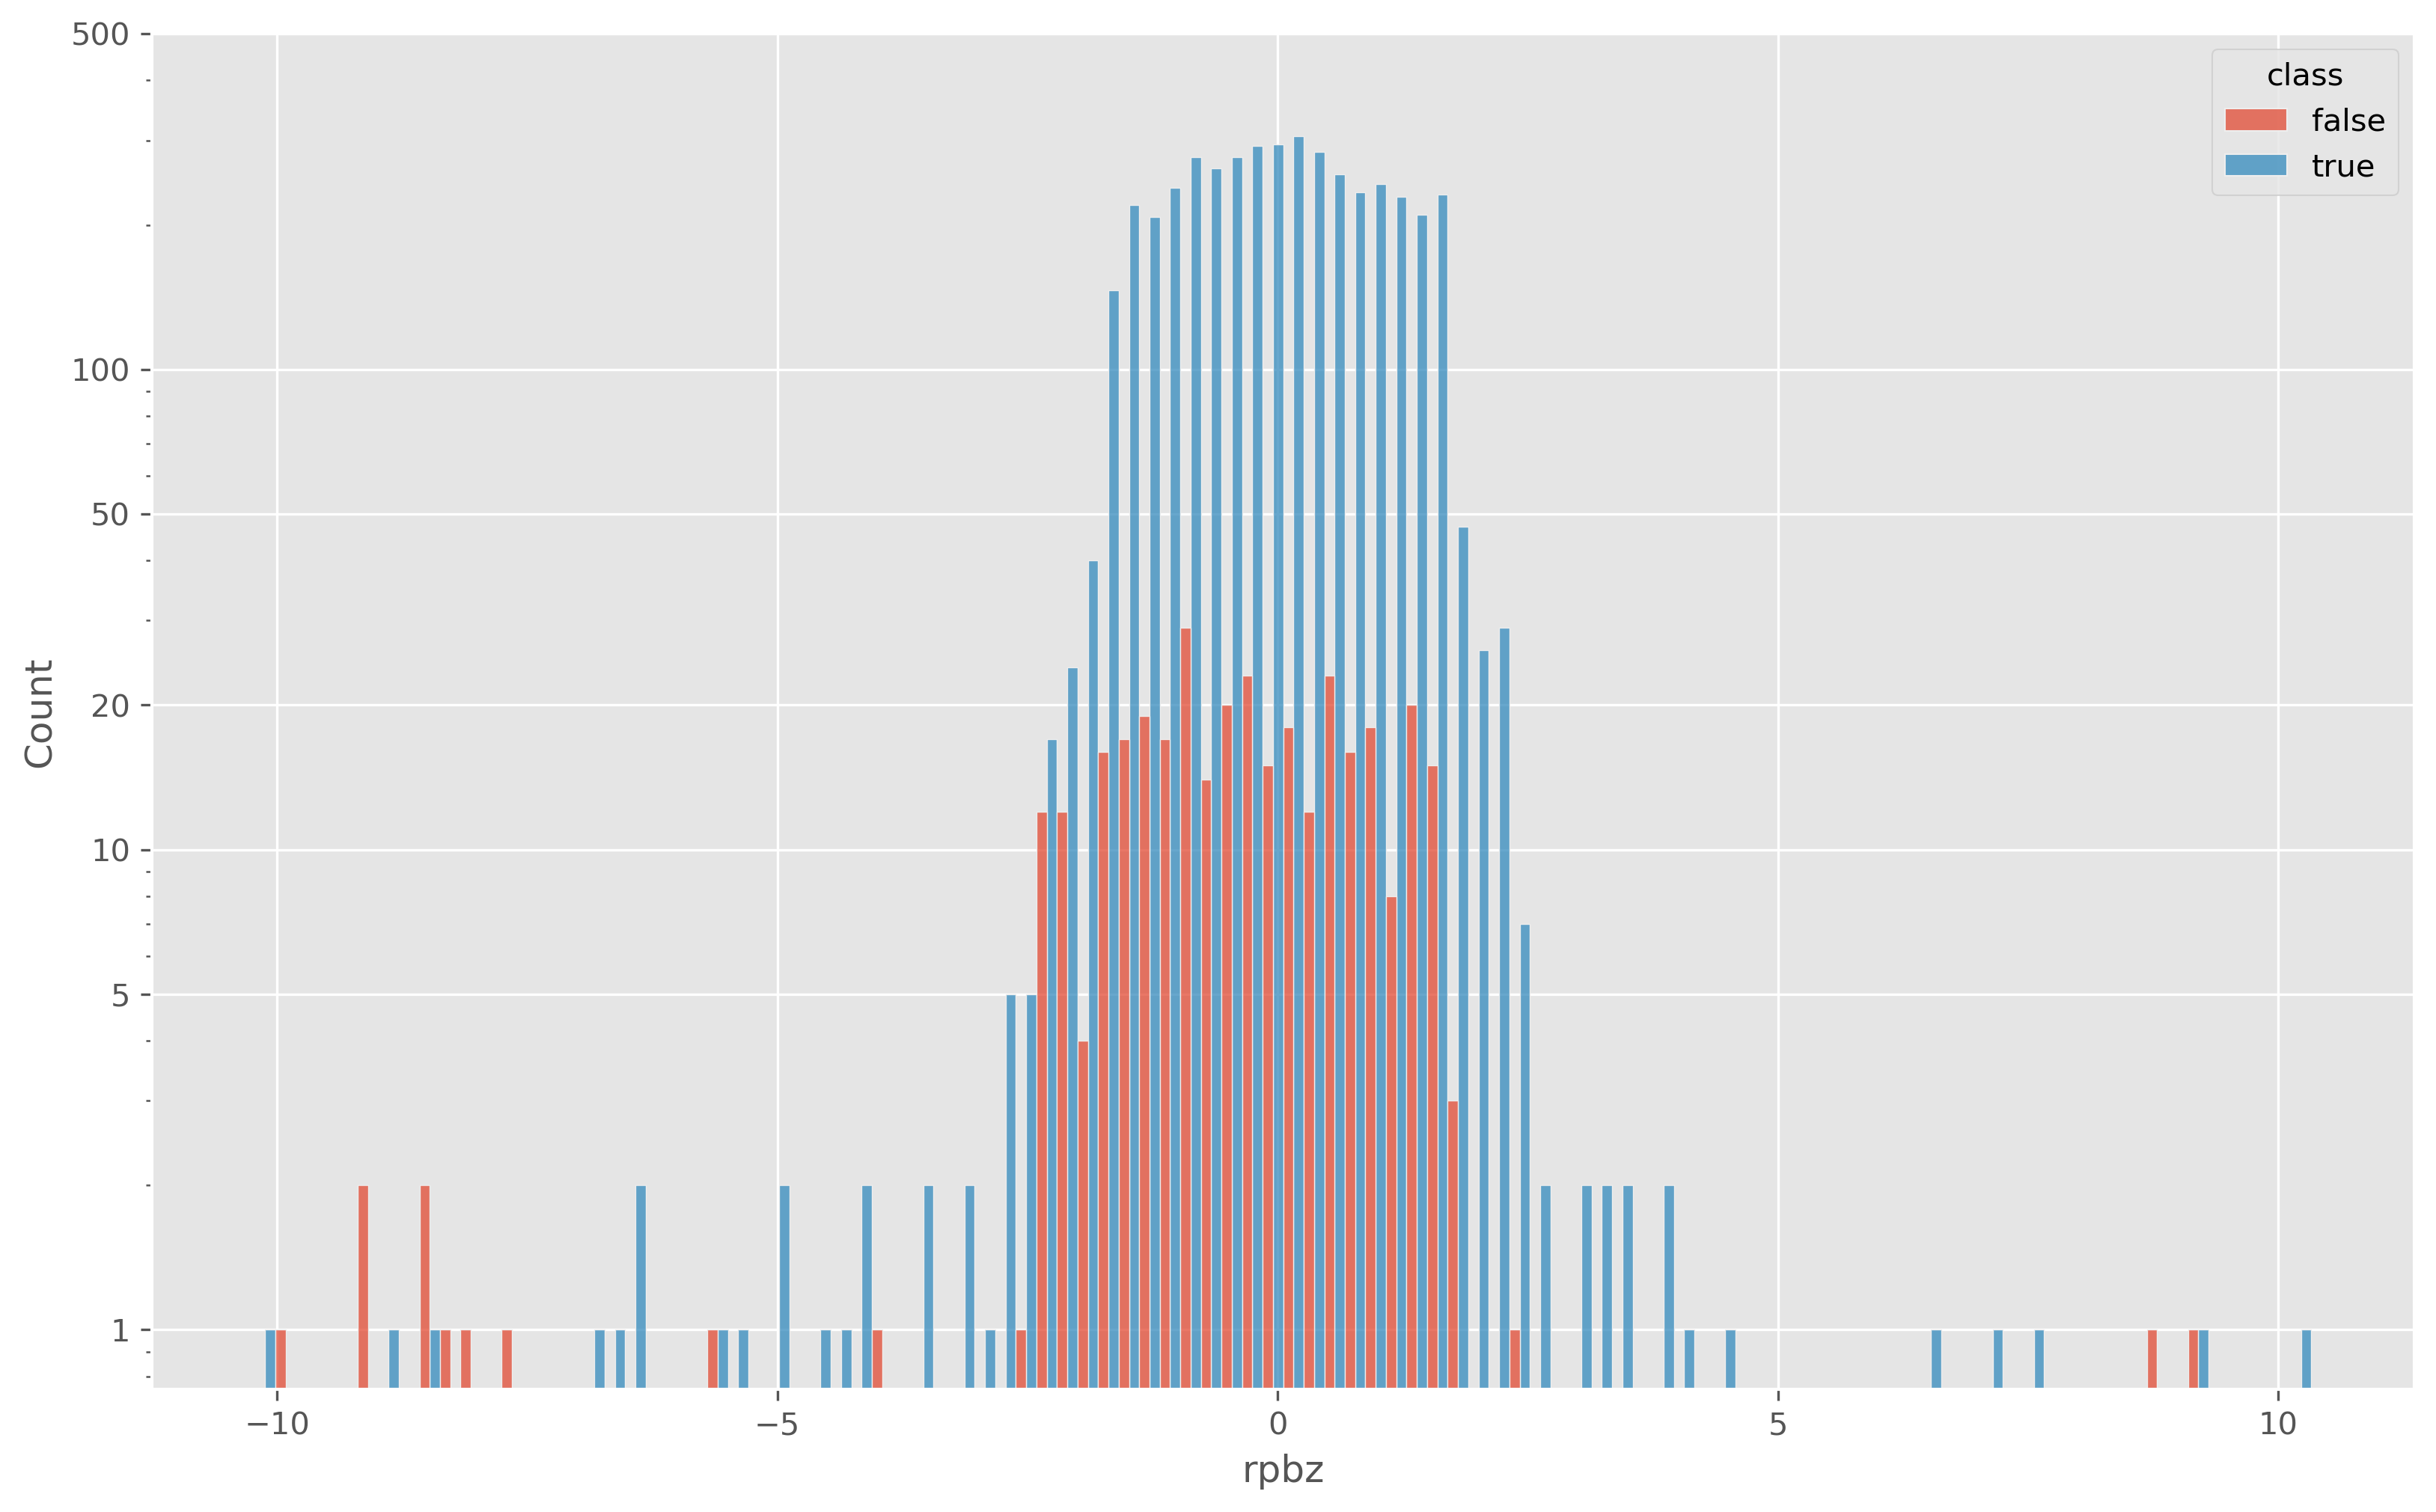

In [103]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="rpbz", hue="class", multiple="dodge", bins=100)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((-15, -3))

In [156]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.sgb"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.sgb"
        opts = f"-i 'TYPE=\"SNP\"' -f '%SGB\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [157]:
sgb = []
for s in samples:
    sgb.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.sgb").read().splitlines() if x])
    sgb.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.sgb").read().splitlines() if x])

df["sgb"] = sgb

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500')]

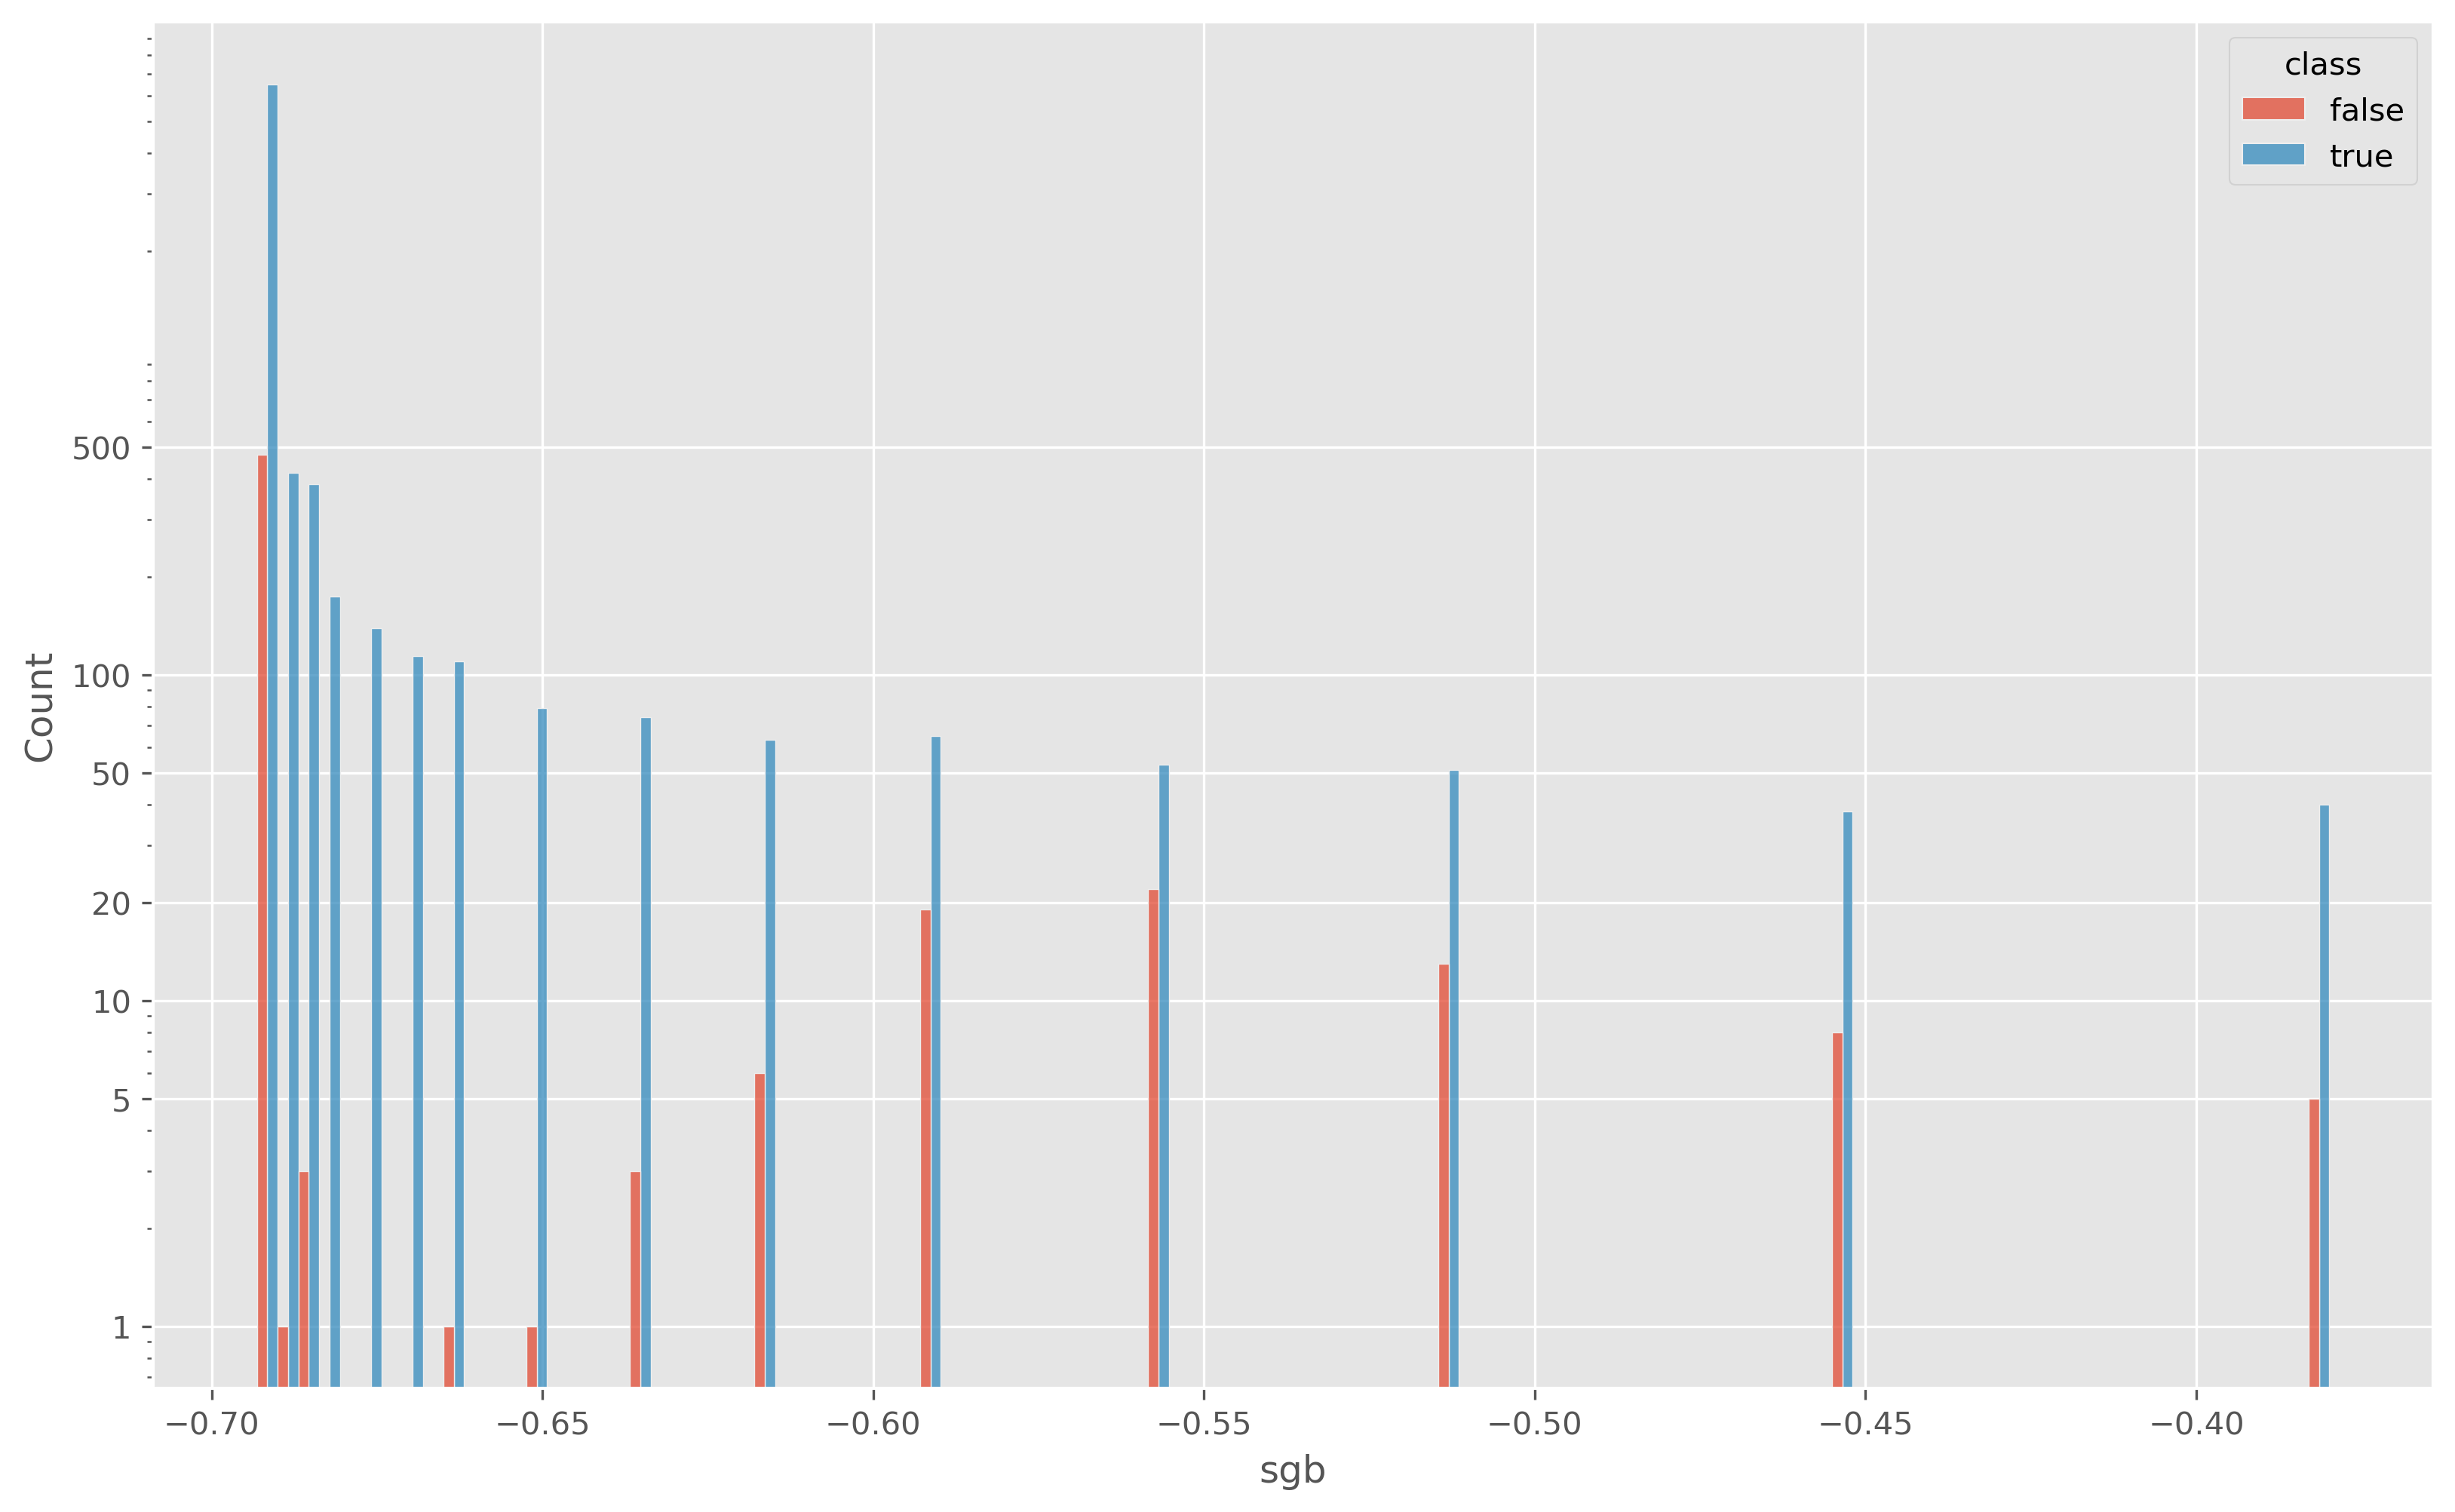

In [160]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df.query("sgb>-1"), x="sgb", hue="class", multiple="dodge", bins=100)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((-15, -3))

In [104]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.scbz"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.scbz"
        opts = f"-i 'TYPE=\"SNP\"' -f '%SCBZ\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [105]:
scbz = []
for s in samples:
    scbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.scbz").read().splitlines() if x])
    scbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.scbz").read().splitlines() if x])

df["scbz"] = scbz

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 1000, '1000')]

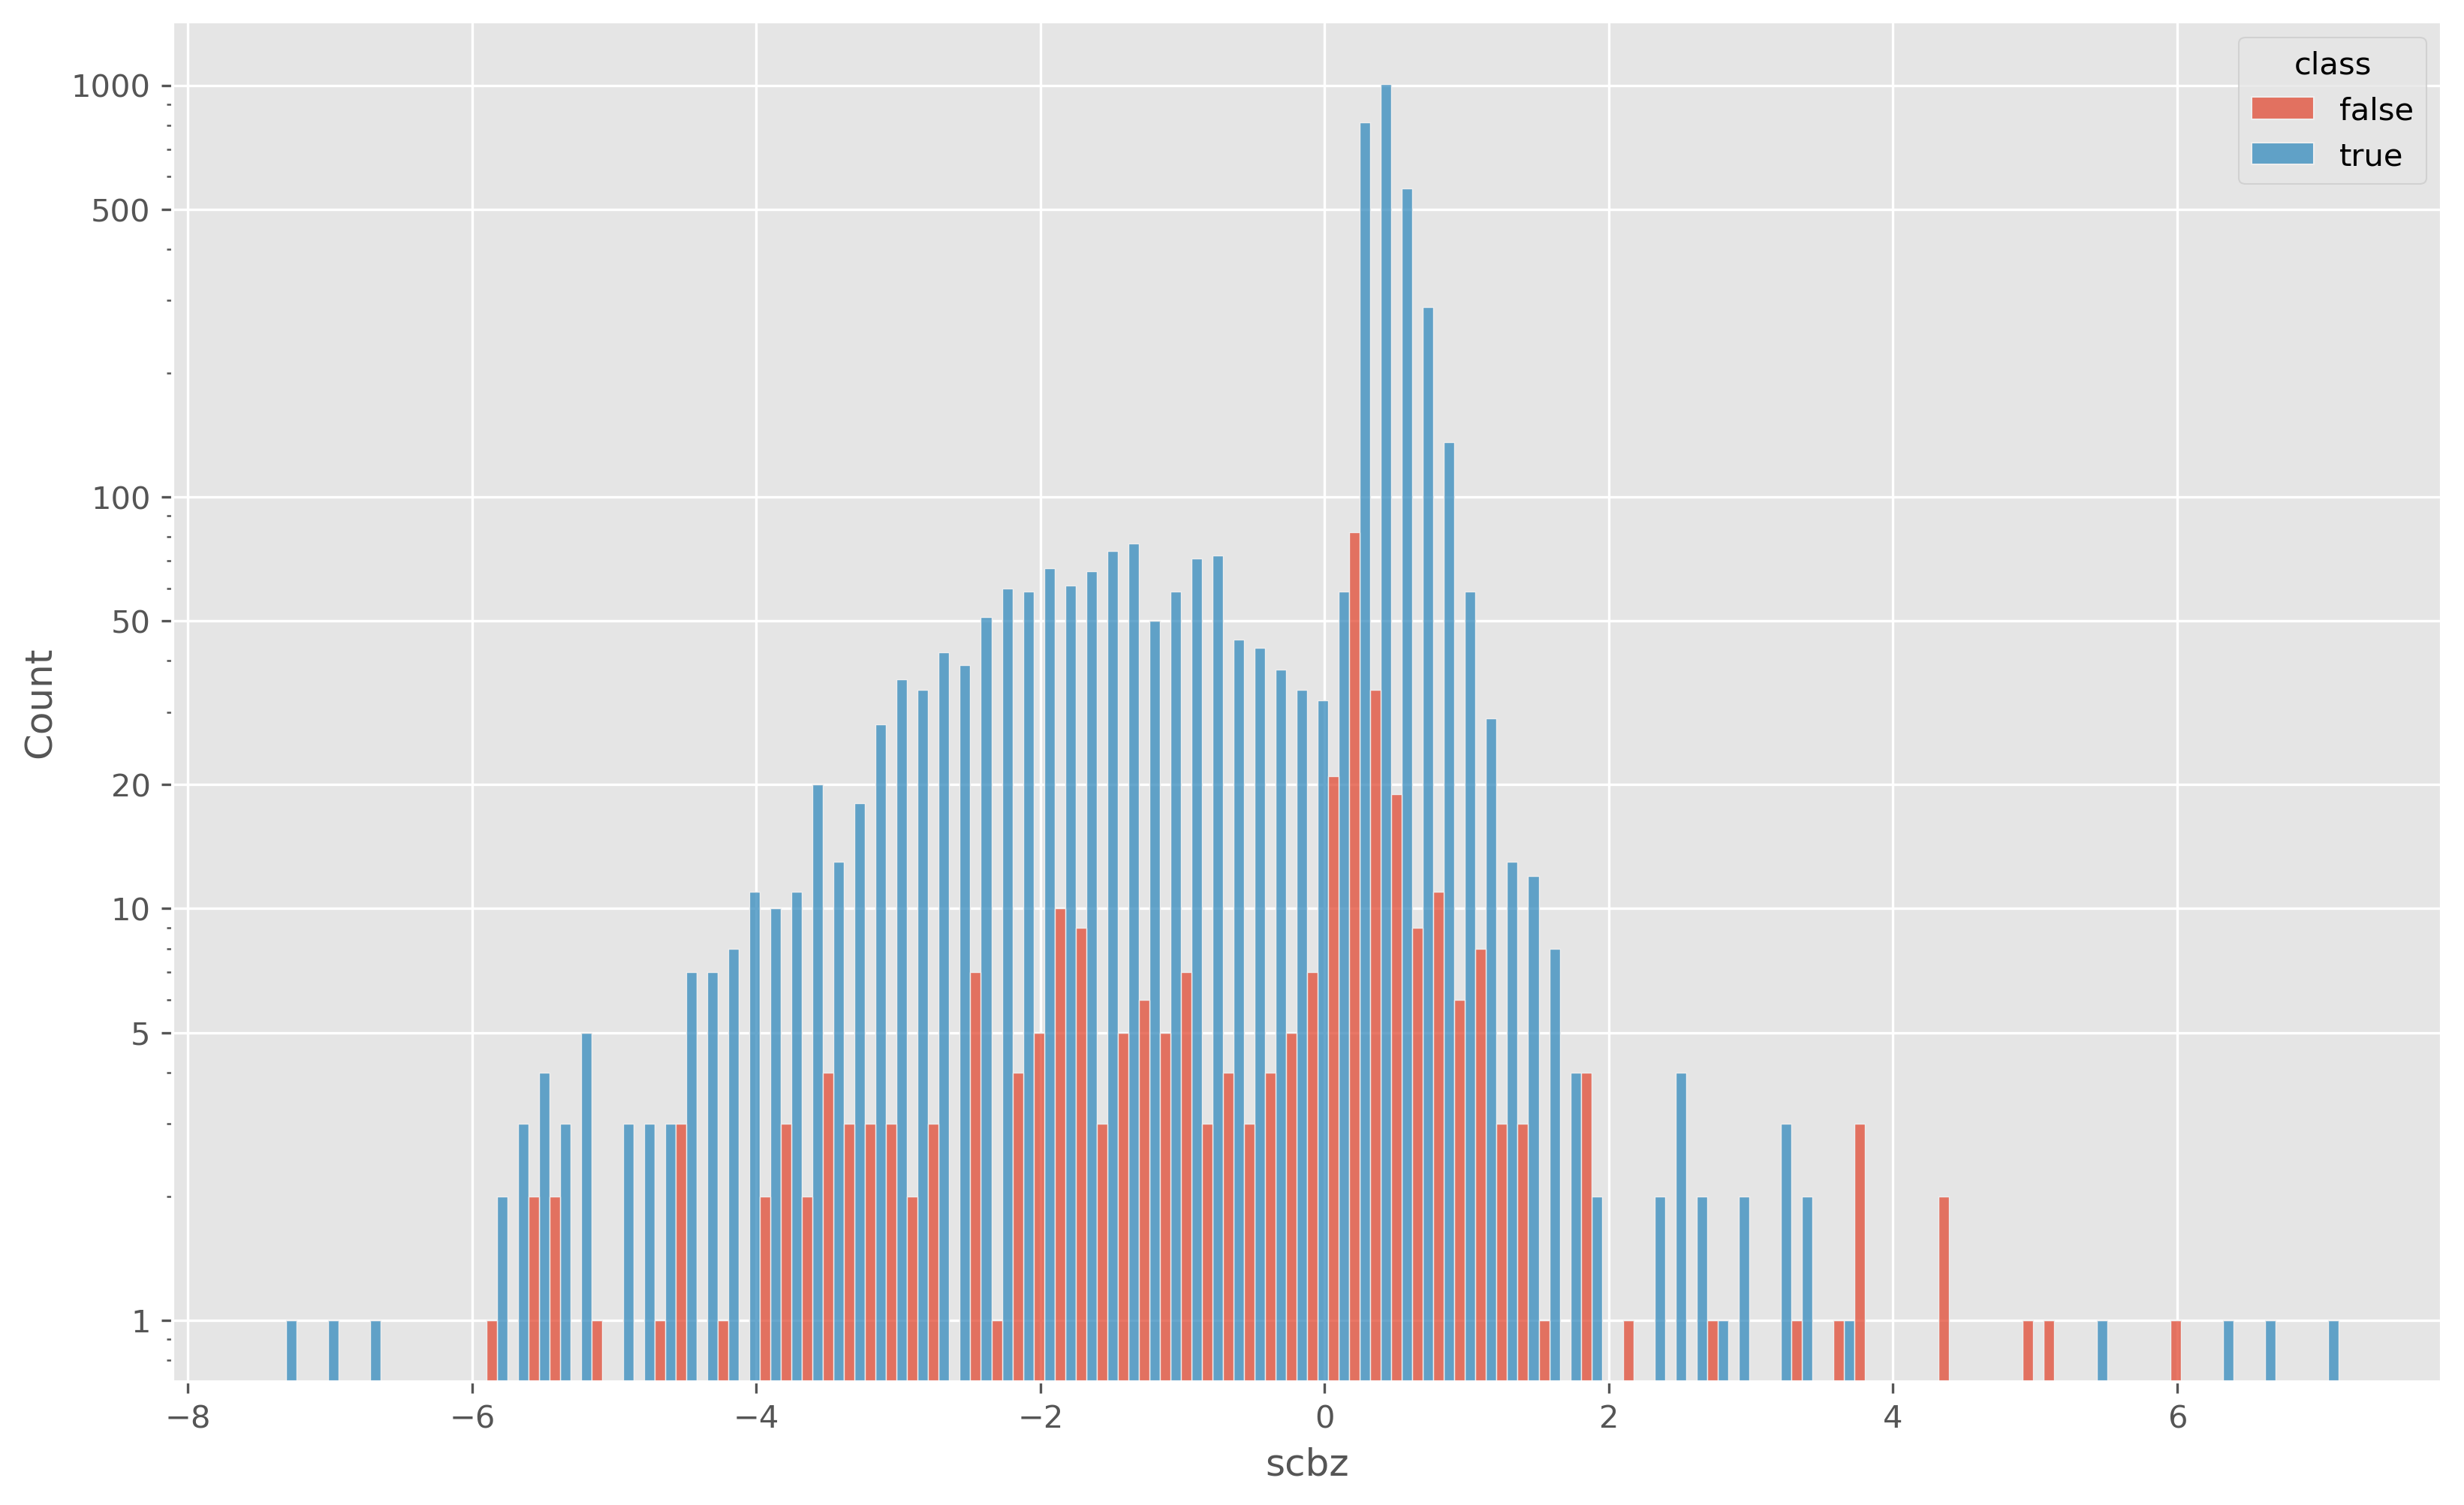

In [106]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="scbz", hue="class", multiple="dodge", )
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 1000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)

In [107]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.sp"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.sp"
        opts = f"-i 'TYPE=\"SNP\"' -f '[%SP]\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [108]:
sp = []
for s in samples:
    sp.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.sp").read().splitlines() if x])
    sp.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.sp").read().splitlines() if x])

df["sp"] = sp

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 7000, '7000')]

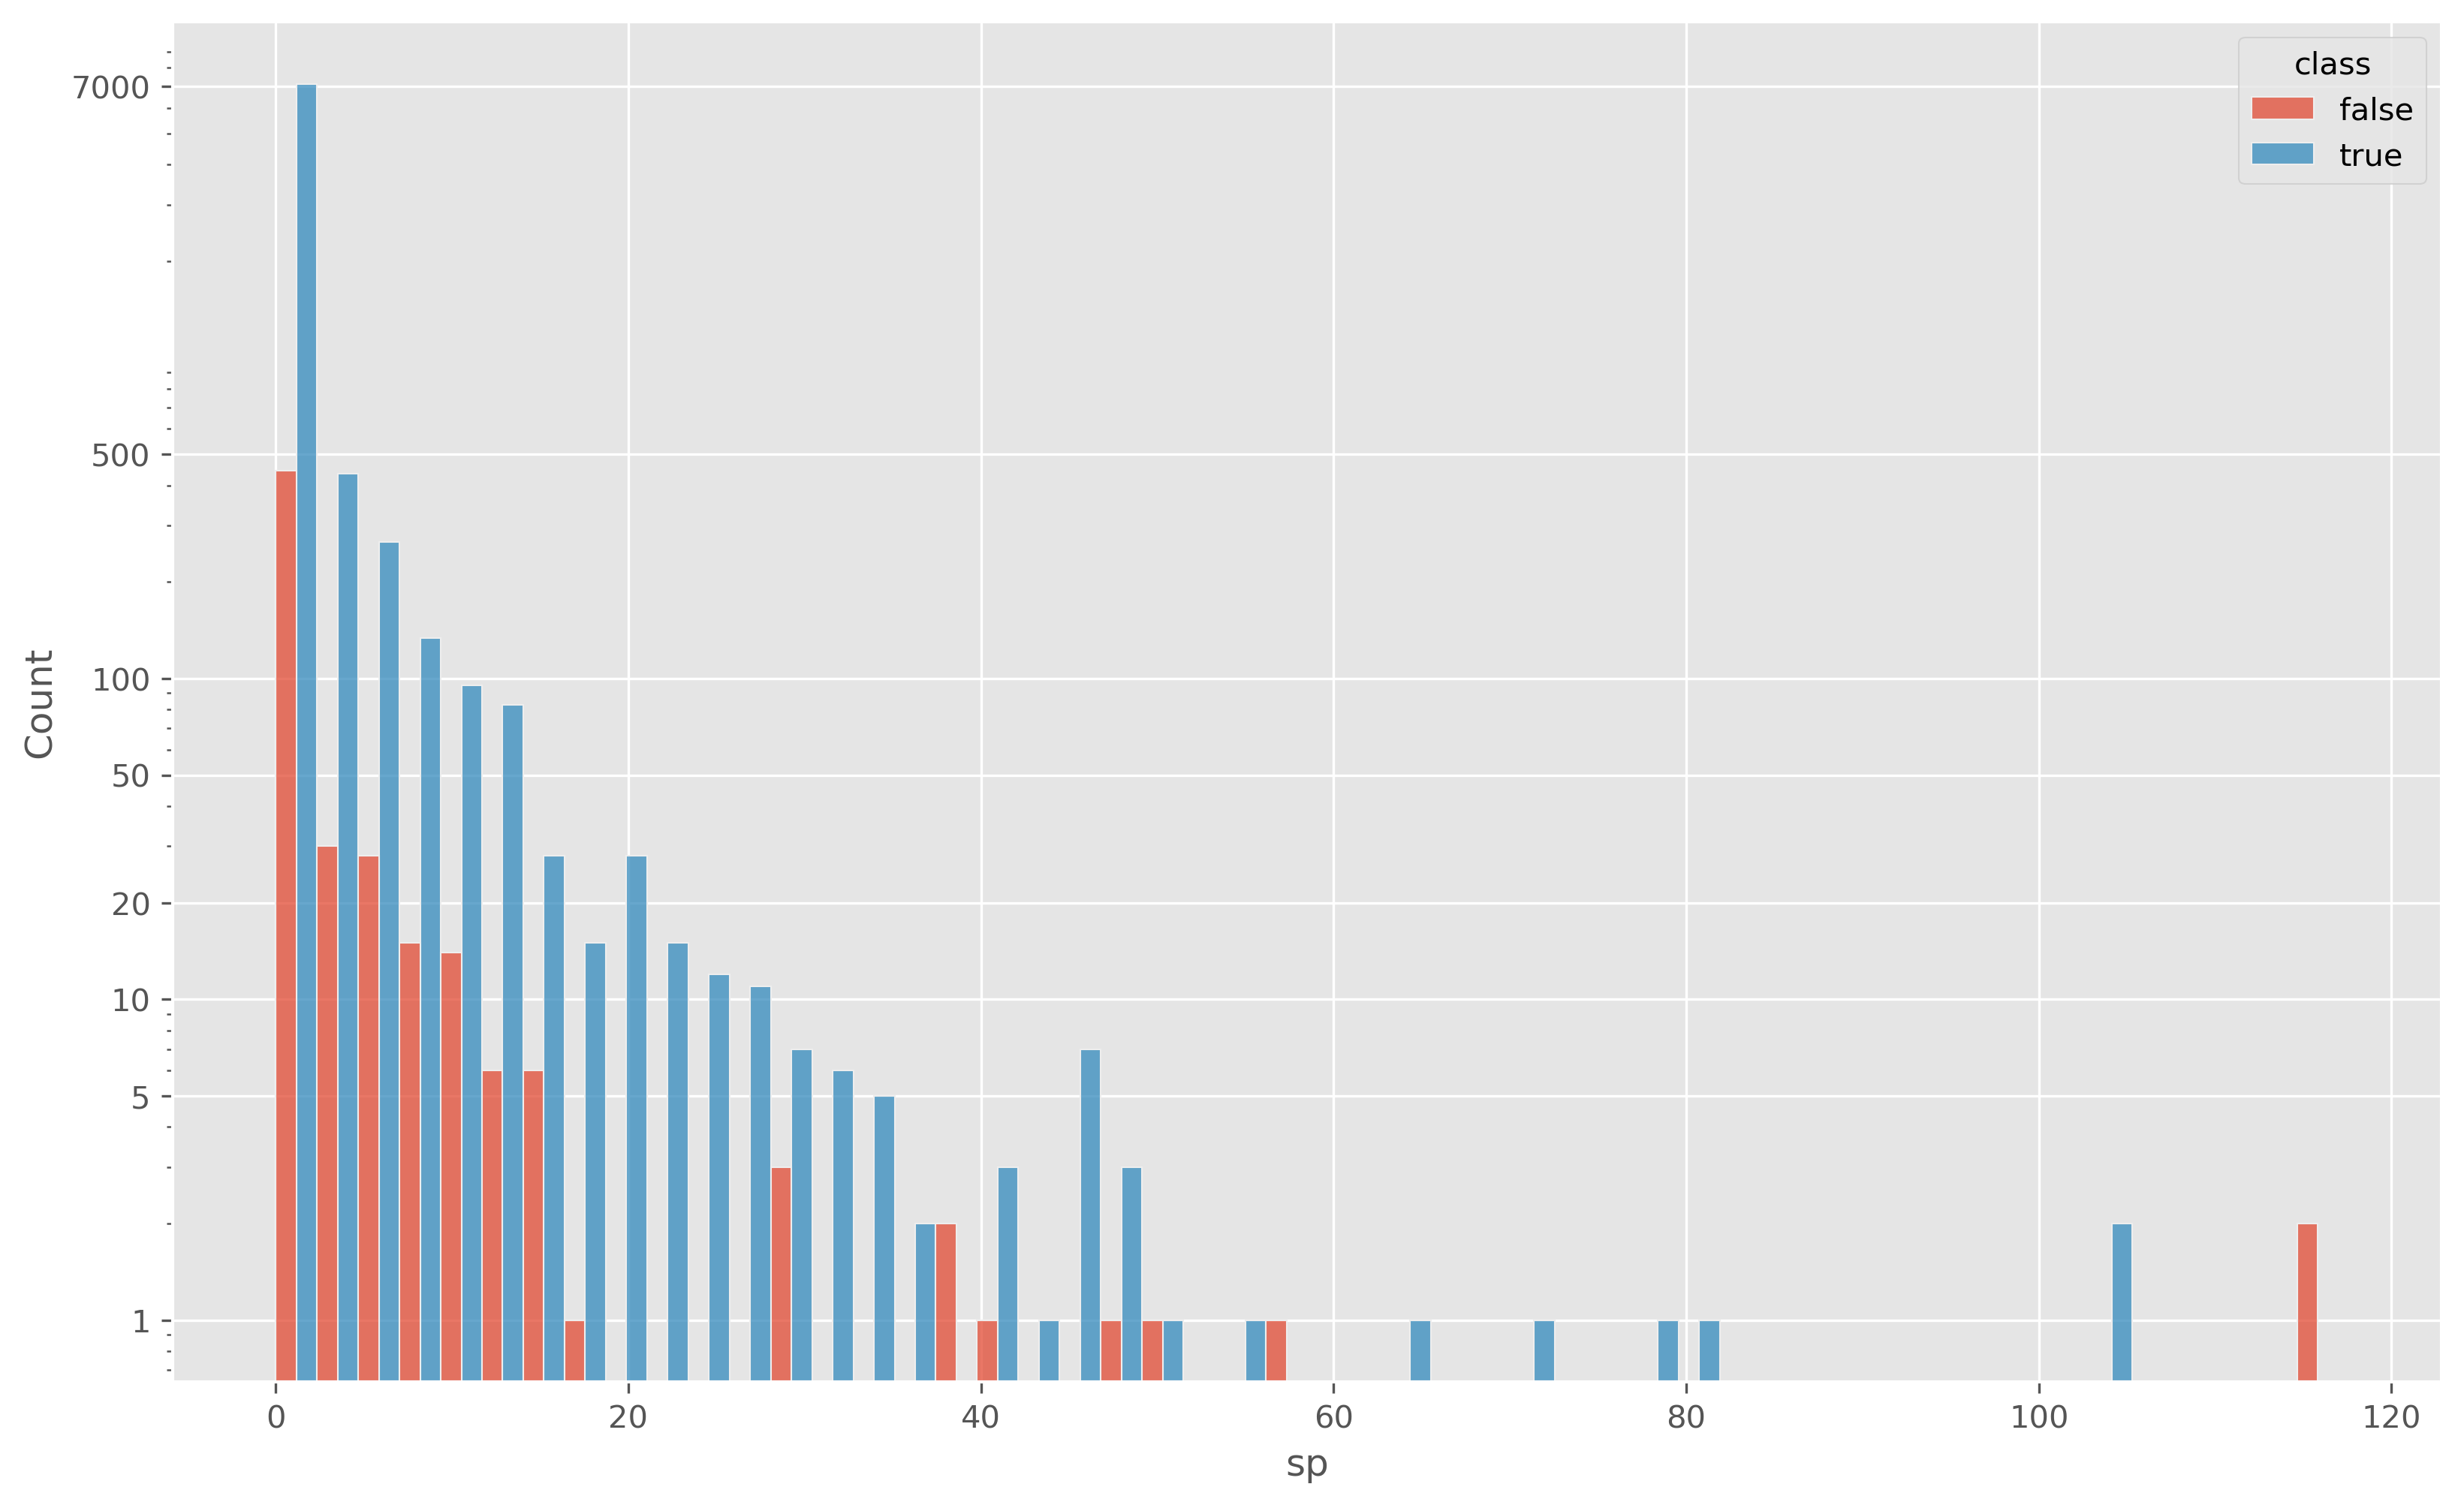

In [109]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="sp", hue="class", multiple="dodge", bins=50)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 7000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 100))

In [110]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.scr"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.scr"
        opts = f"-i 'TYPE=\"SNP\"' -f '%SCR\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [111]:
scr = []
for s in samples:
    scr.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.scr").read().splitlines() if x])
    scr.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.scr").read().splitlines() if x])

df["scr"] = scr

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 1000, '1000')]

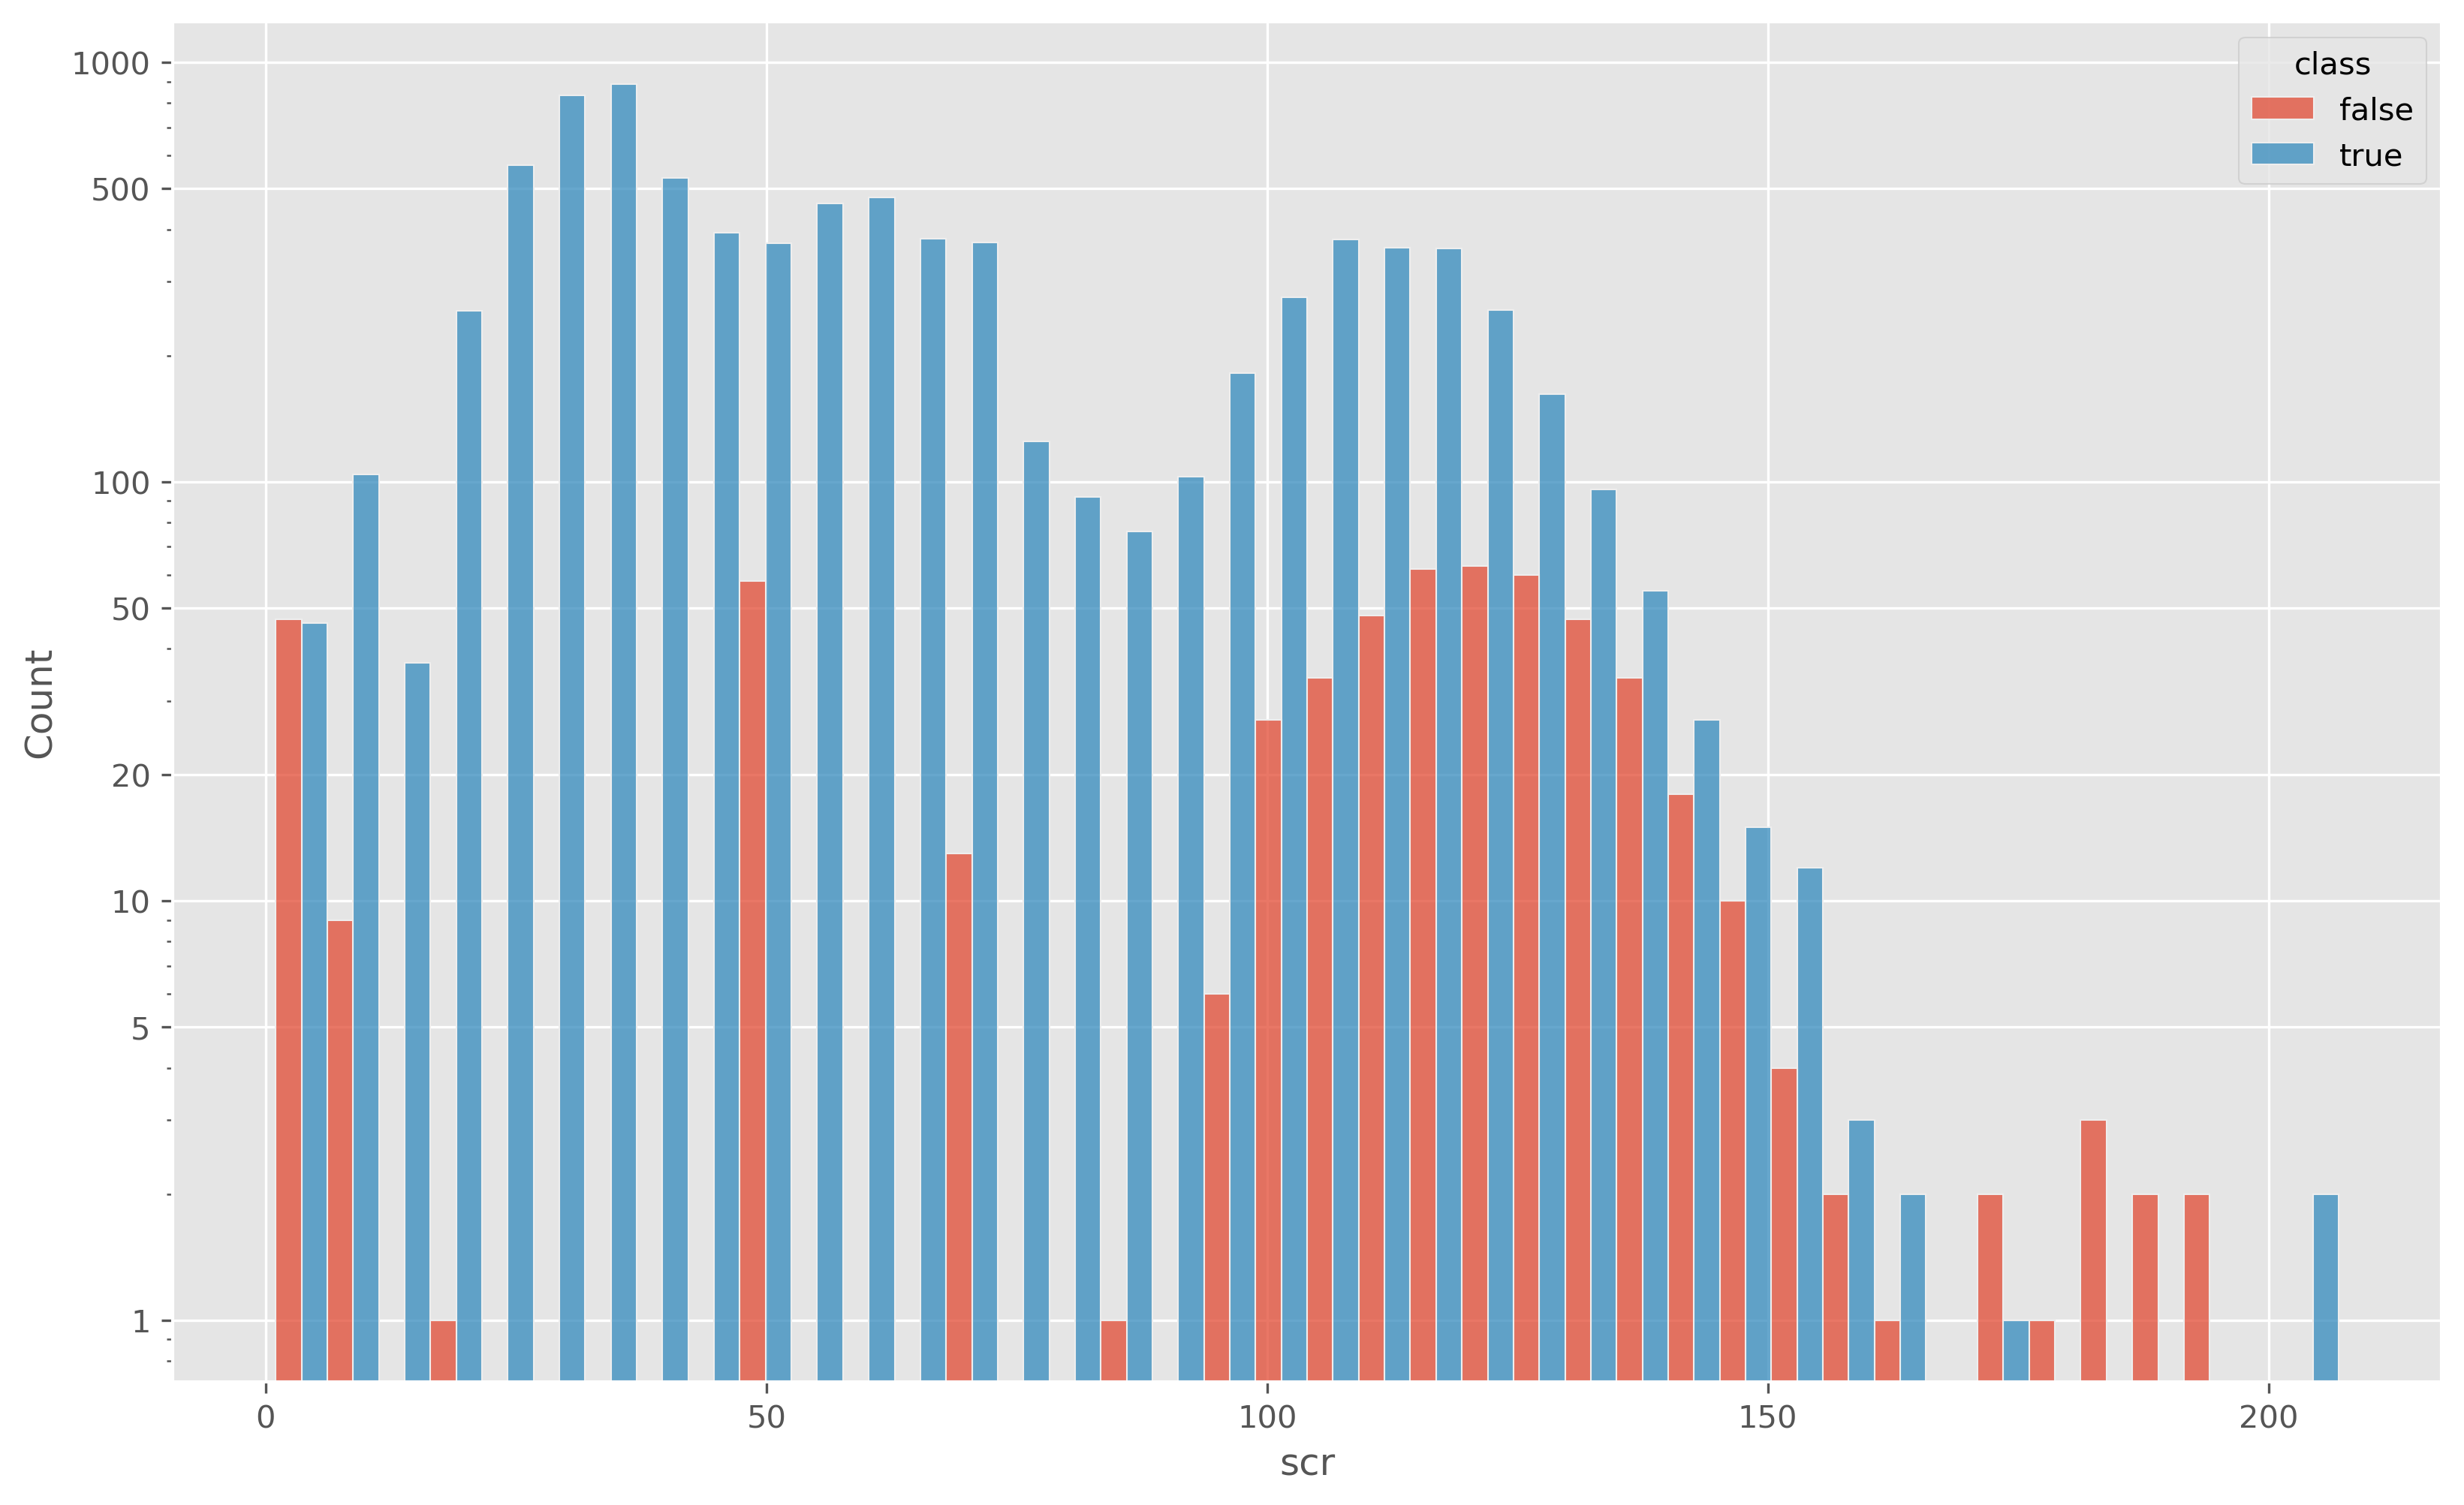

In [114]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="scr", hue="class", multiple="dodge", bins=40)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 1000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 100))

In [115]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.dp4"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.dp4"
        opts = f"-i 'TYPE=\"SNP\"' -f '%DP4\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [116]:
frs = []
for s in samples:
    for line in open(stats_dir / f"{s}.false.dp4").read().splitlines():
        rf, rr, af, ar = [int(i) for i in line.split(",")]
        r = rf+rr
        a = af+ar
        frs.append(max(a, r)/(a+r))
    for line in open(stats_dir / f"{s}.true.dp4").read().splitlines():
        rf, rr, af, ar = [int(i) for i in line.split(",")]
        r = rf+rr
        a = af+ar
        frs.append(max(a, r)/(a+r))

df["frs"] = frs

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 2000, '2000')]

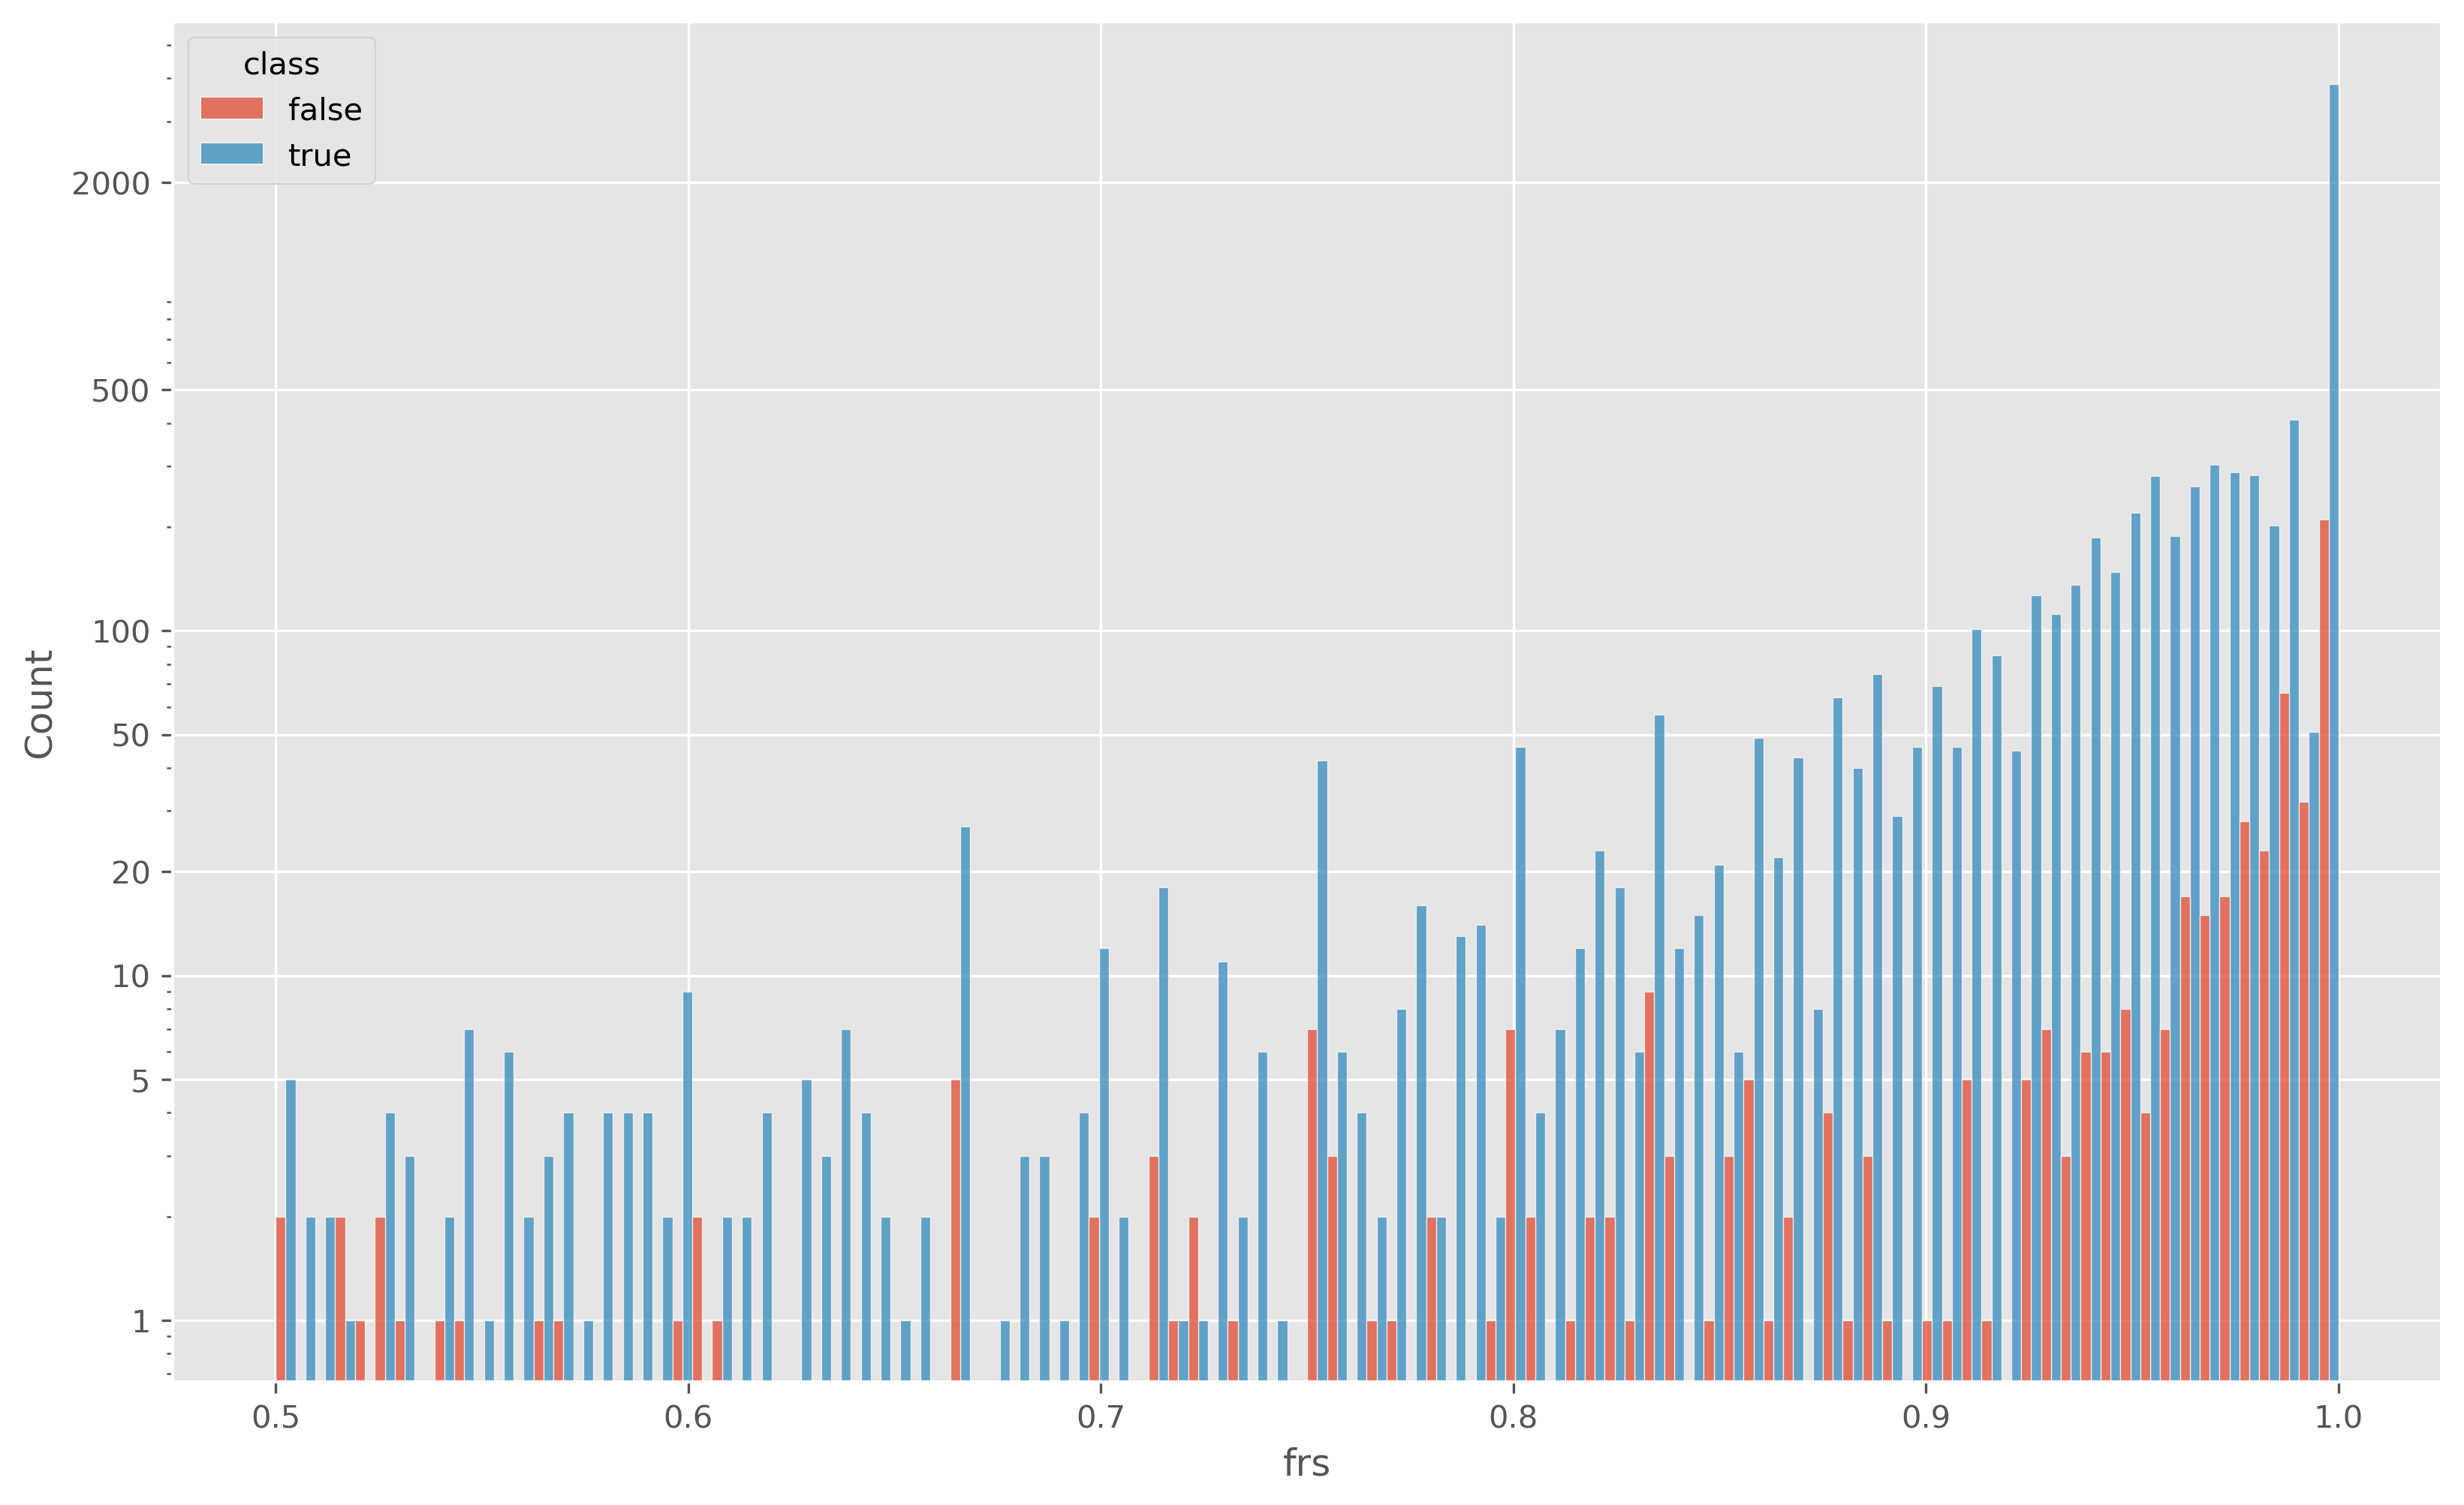

In [117]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="frs", hue="class", multiple="dodge", )
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 100))

In [118]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.vdb"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.vdb"
        opts = f"-i 'TYPE=\"SNP\"' -f '%VDB\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [119]:
vdb = []
for s in samples:
    vdb.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.vdb").read().splitlines() if x])
    vdb.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.vdb").read().splitlines() if x])

df["vdb"] = vdb

<AxesSubplot:xlabel='vdb', ylabel='Count'>

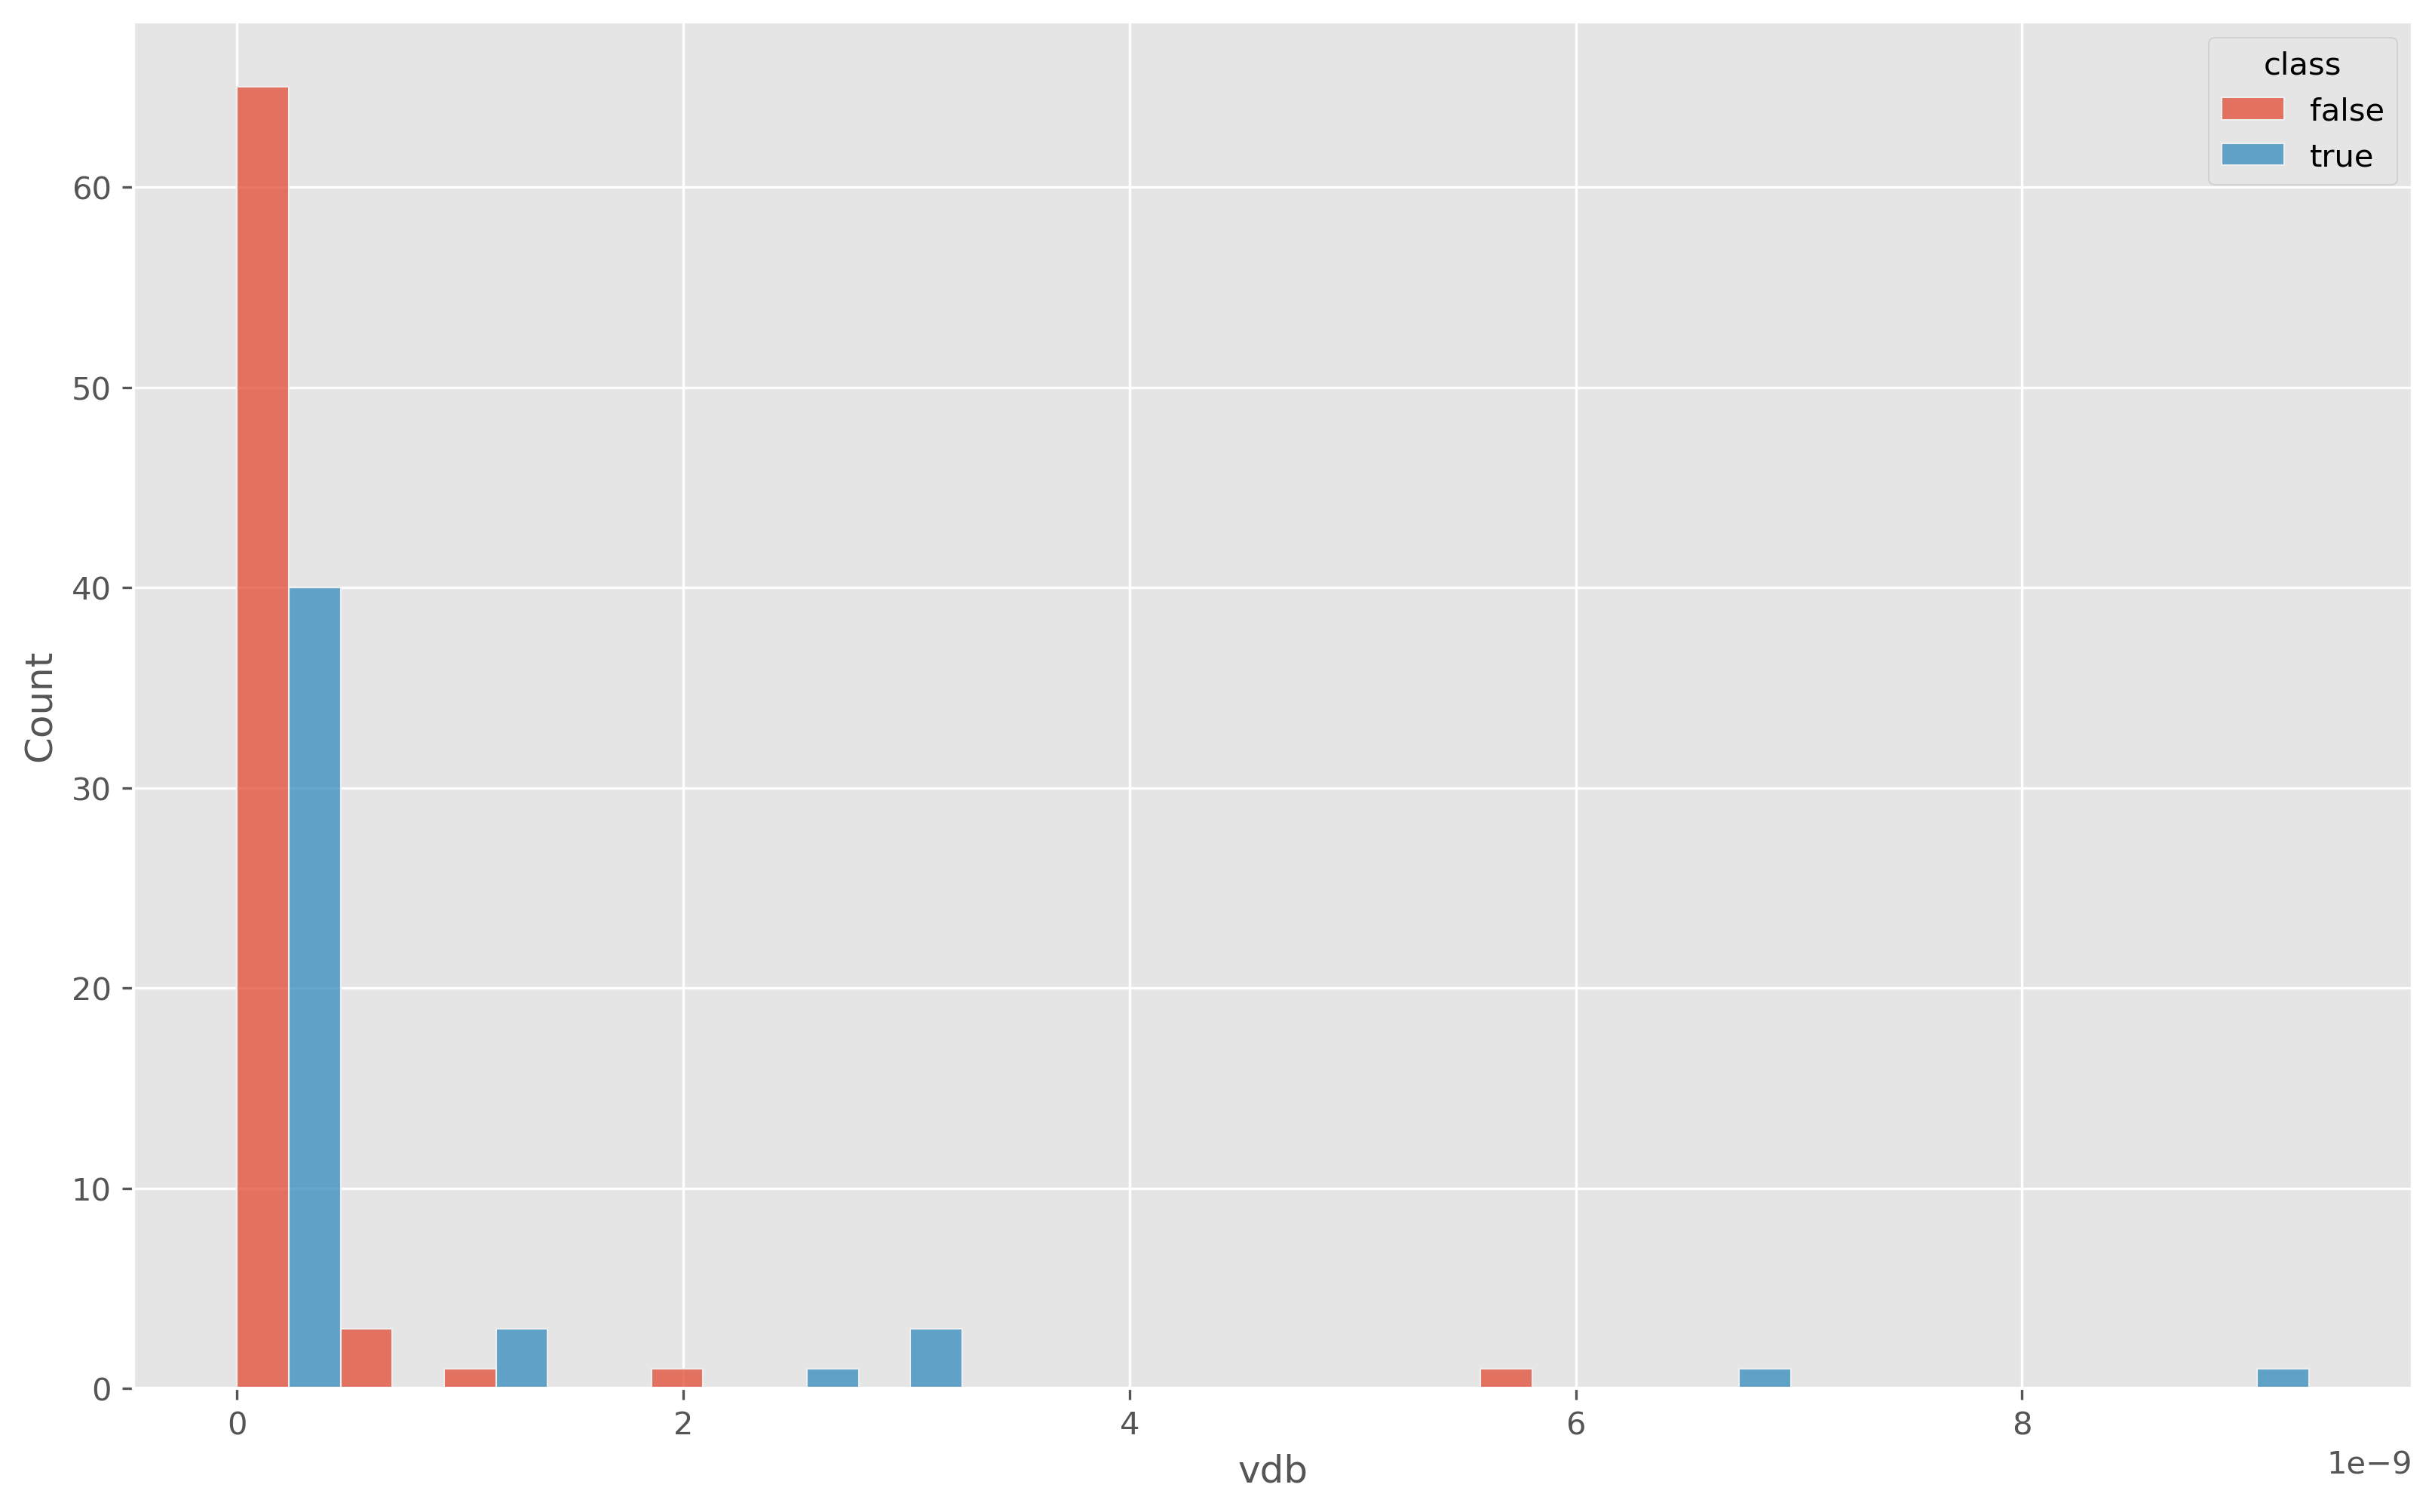

In [122]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df.query("vdb<1e-8"), x="vdb", hue="class", multiple="dodge", bins=20)
# ax.set_yscale("log")
# ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 0.0001))

In [123]:
ts = []
fs = []
for i in range(1, 30):
    v = 1 * 10**(-i)
    f, t = df.query("vdb<@v").groupby(["class"])["vdb"].count()
    fs.append(f)
    ts.append(t)

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 2000, '2000')]

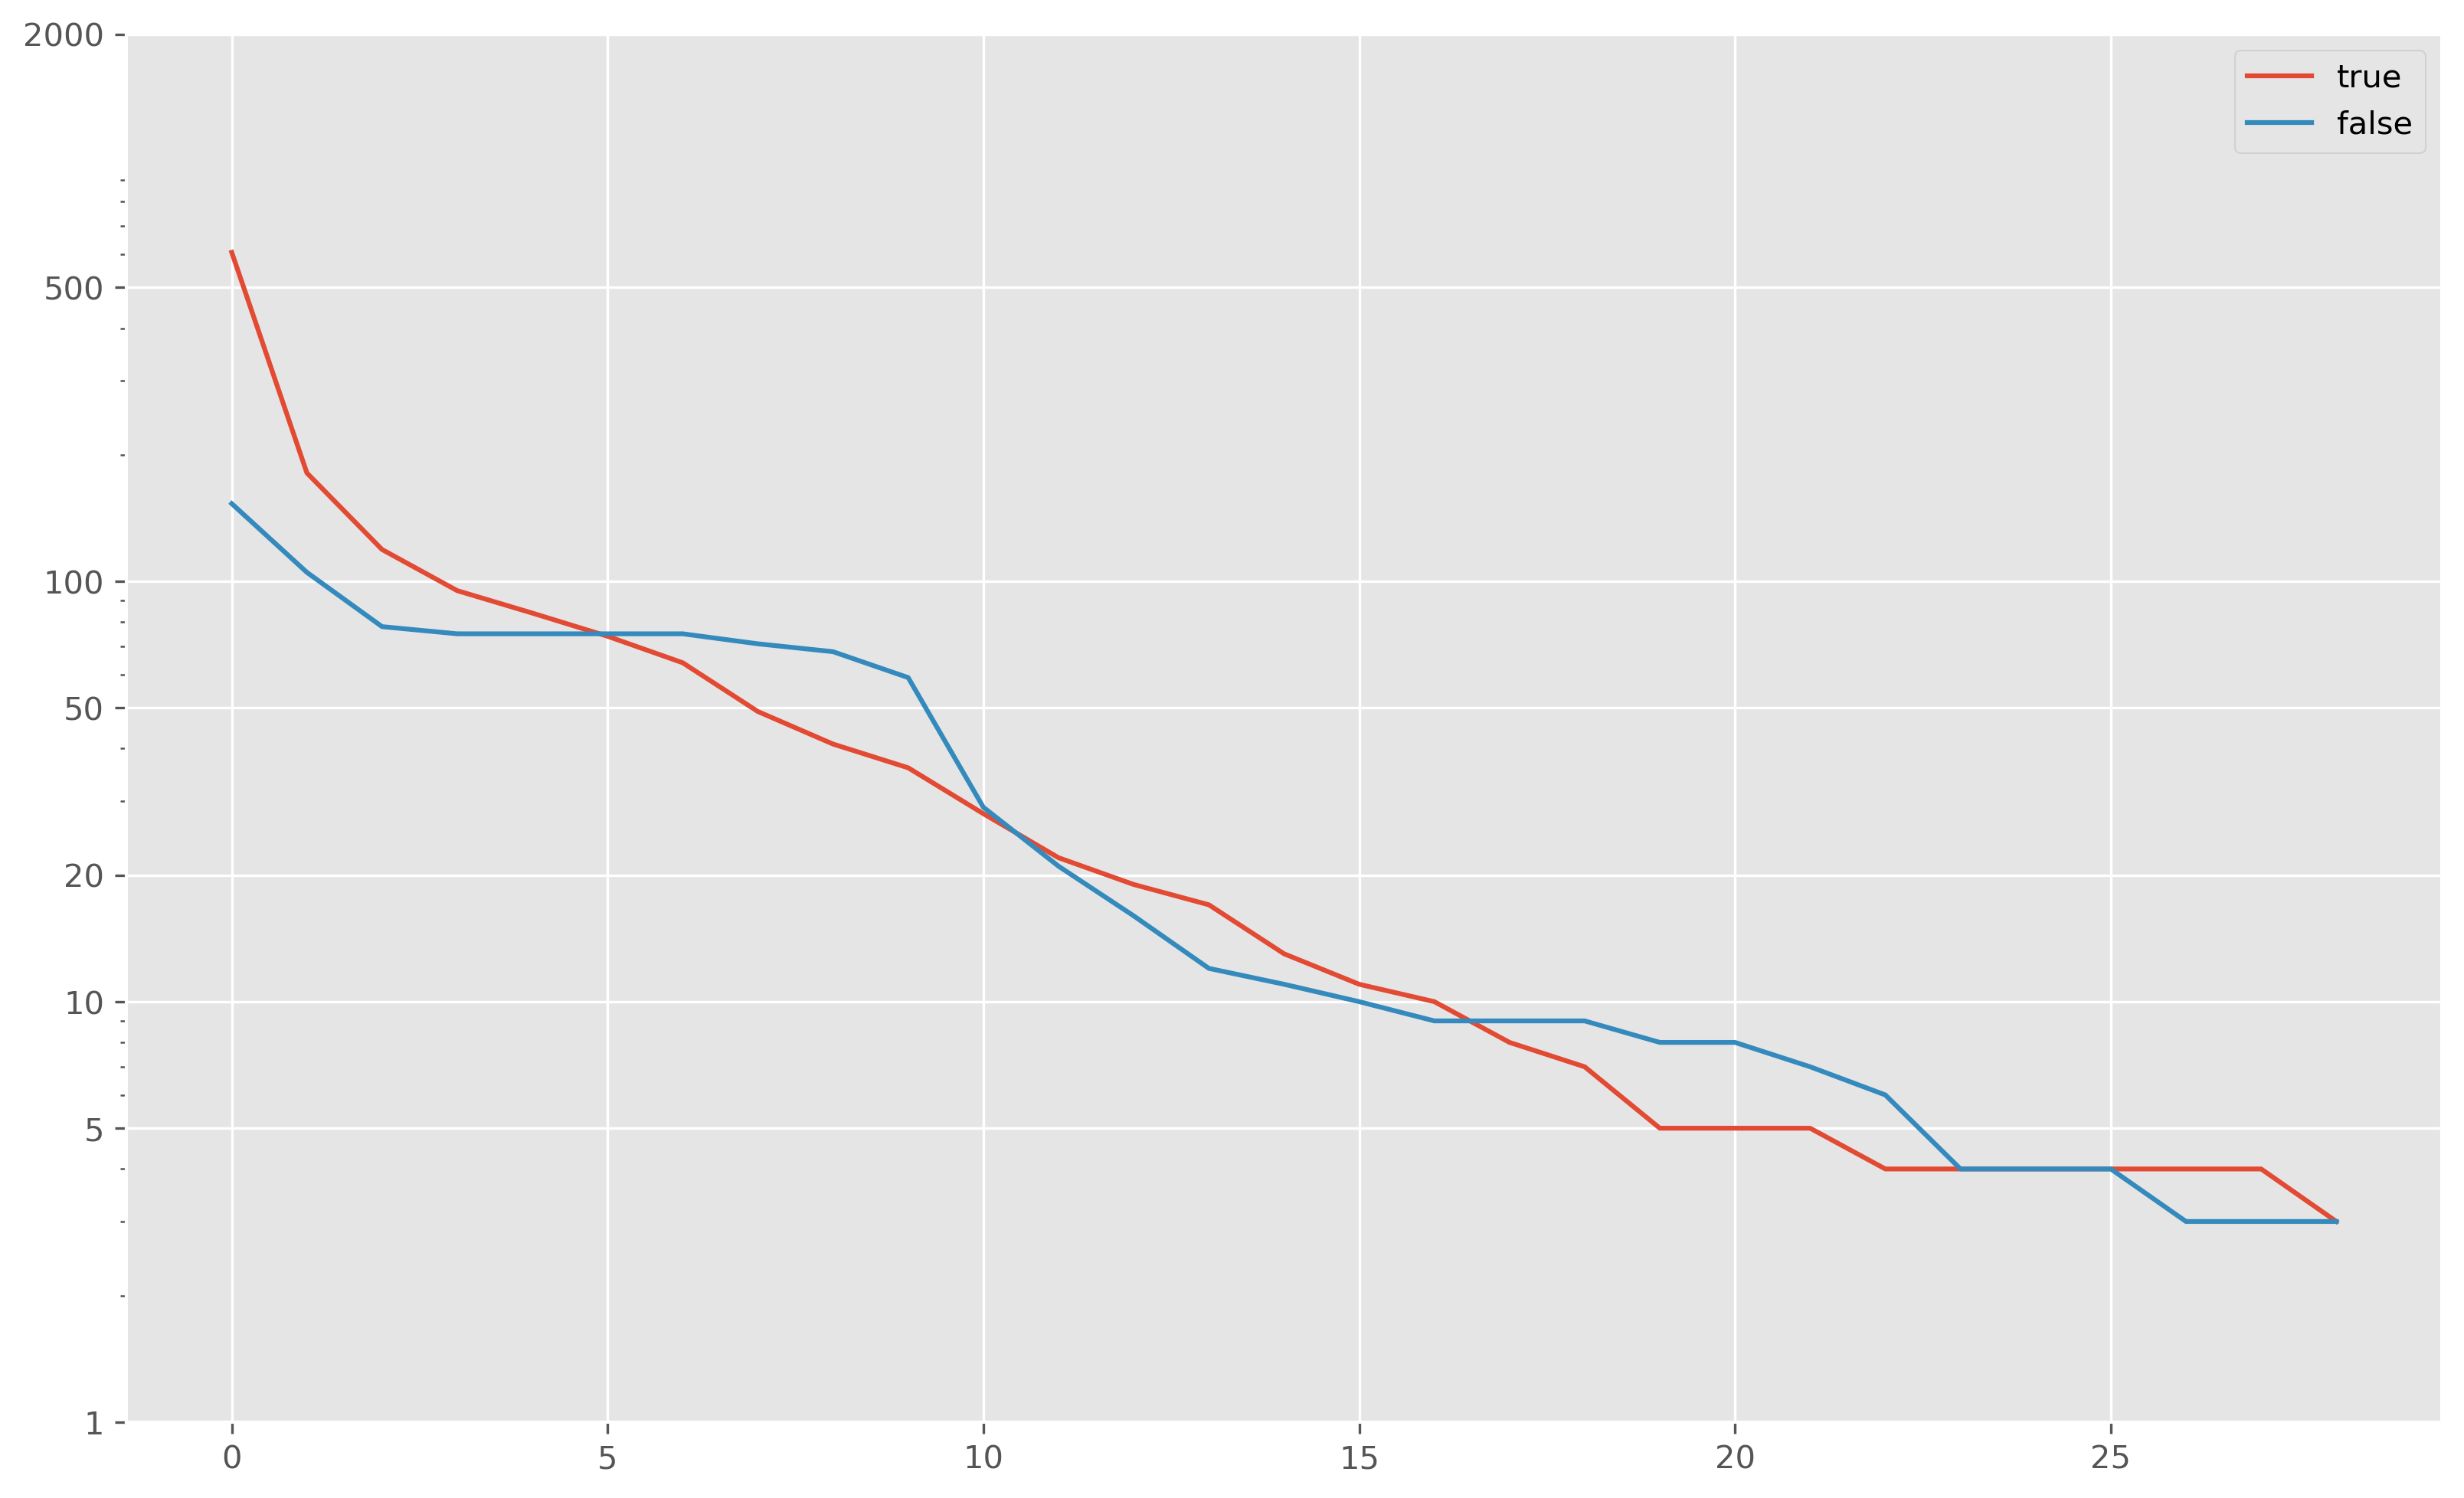

In [124]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
ax.plot(ts, label="true")
ax.plot(fs, label="false")
ax.legend()
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)

In [125]:
ratios = []
for x, y in zip(ts, fs):
    total = x+y
    r = y/total
    ratios.append(r)

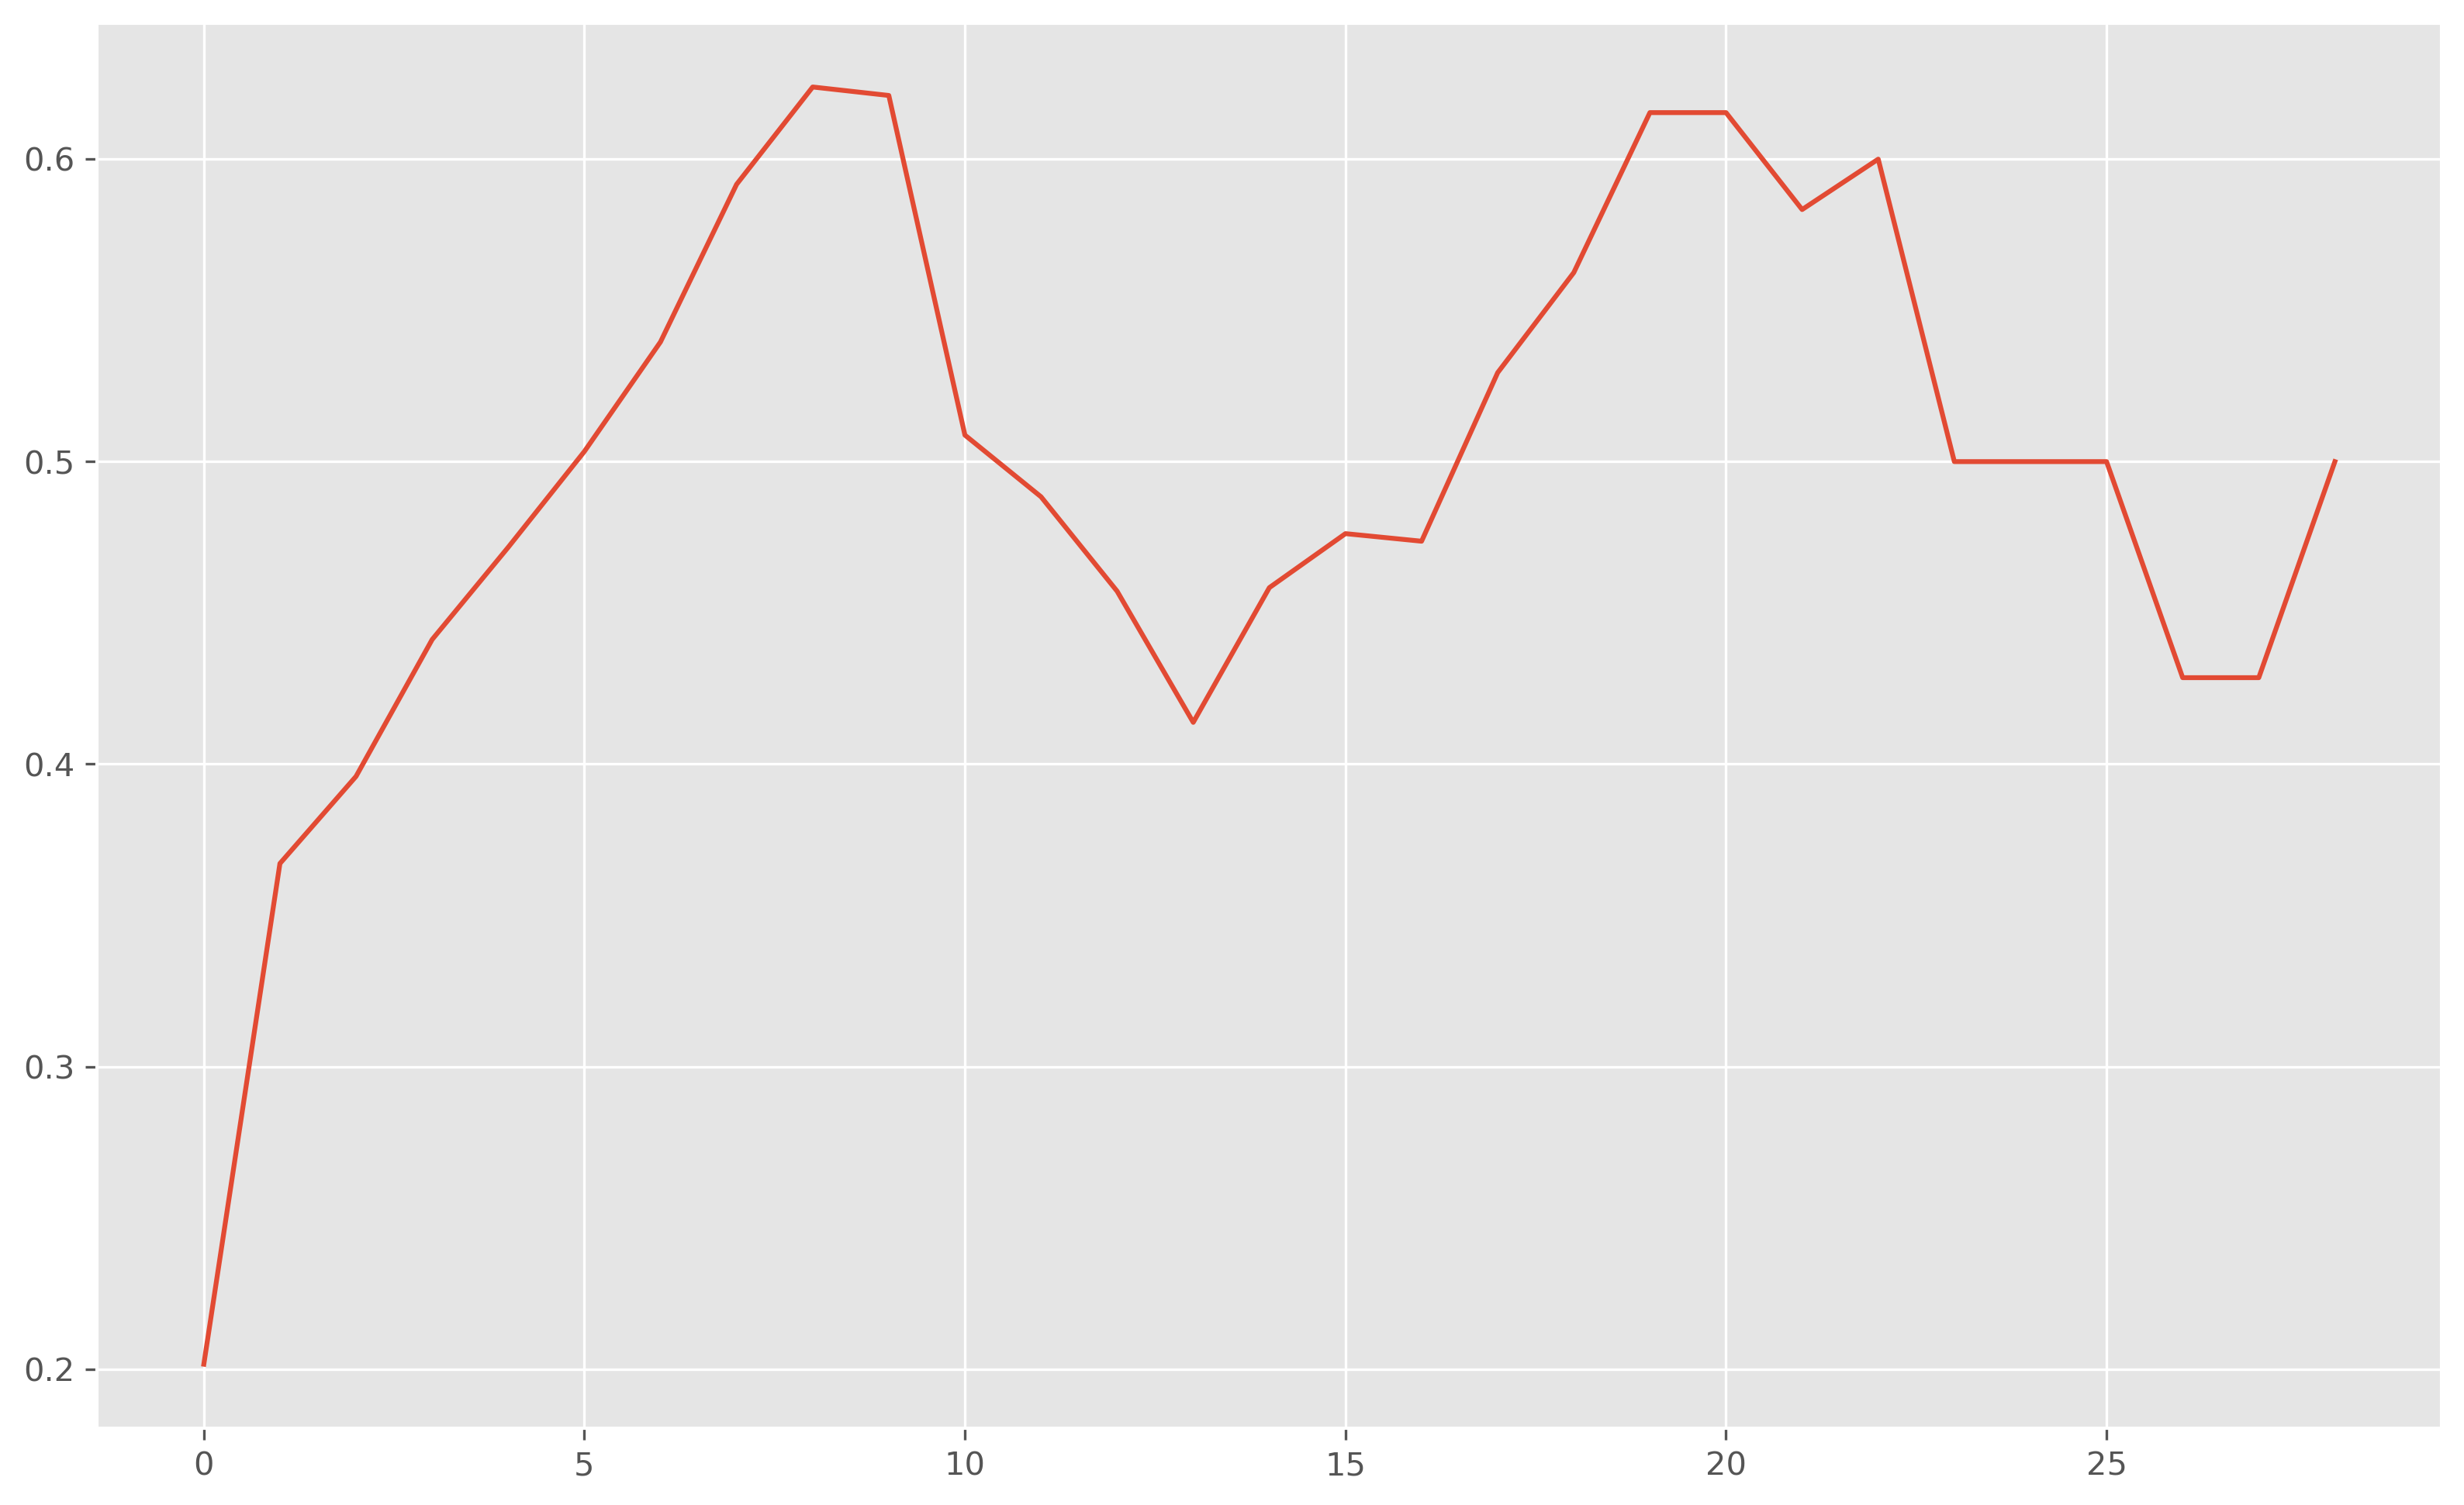

In [126]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
ax.plot(ratios)
# ax.legend()
# ax.set_yscale("log")
# ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)

In [127]:
ratios[8]

0.6238532110091743

In [128]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        true = isec_dir / f"{s}/0003.vcf"
        true_out = stats_dir / f"{s}.true.mqsbz"
        false = isec_dir / f"{s}/0001.vcf"
        false_out = stats_dir / f"{s}.false.mqsbz"
        opts = f"-i 'TYPE=\"SNP\"' -f '%MQSBZ\n'"
        jobs.append((true, true_out, opts))
        jobs.append((false, false_out, opts))
    pool.starmap(bcftools_query, jobs)

In [129]:
mqsbz = []
for s in samples:
    mqsbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.mqsbz").read().splitlines() if x])
    mqsbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.mqsbz").read().splitlines() if x])

df["mqsbz"] = mqsbz

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 2000, '2000')]

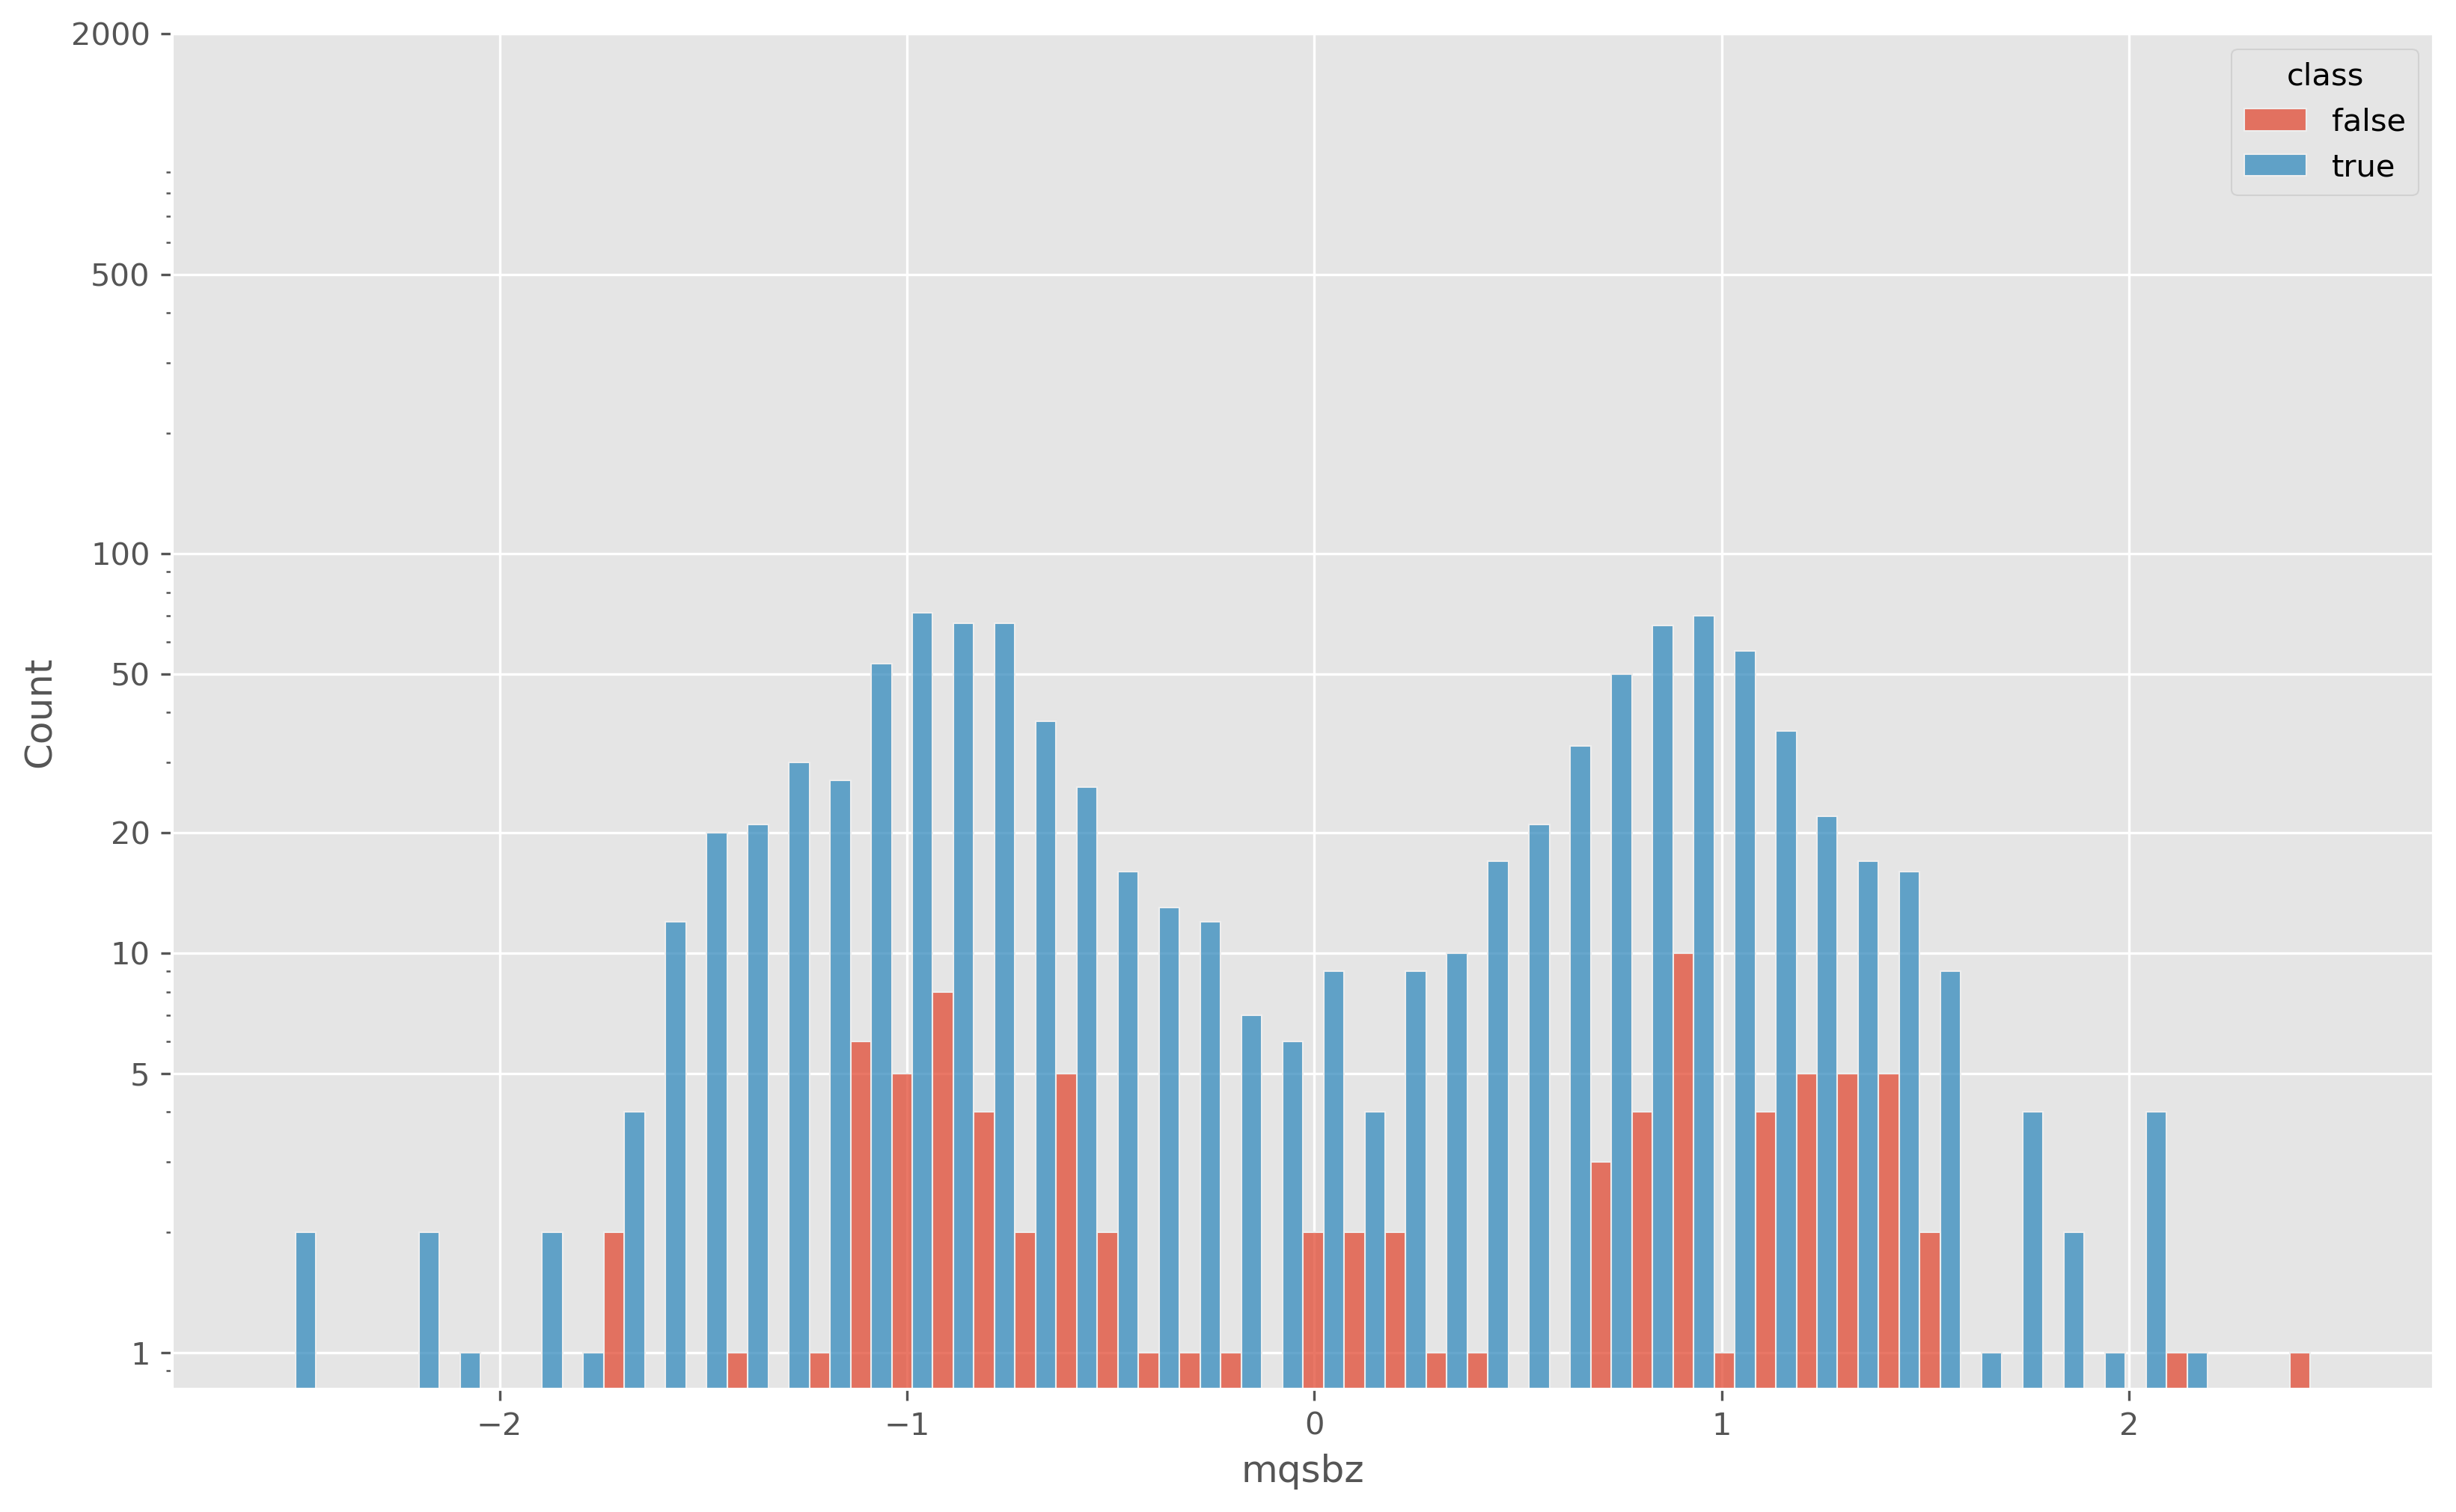

In [130]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="mqsbz", hue="class", multiple="dodge", bins=50)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 100))

In [95]:
df["iscbz"] = df.apply(lambda r: r.scbz*r.rpbz, axis=1)

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 1000, '1000')]

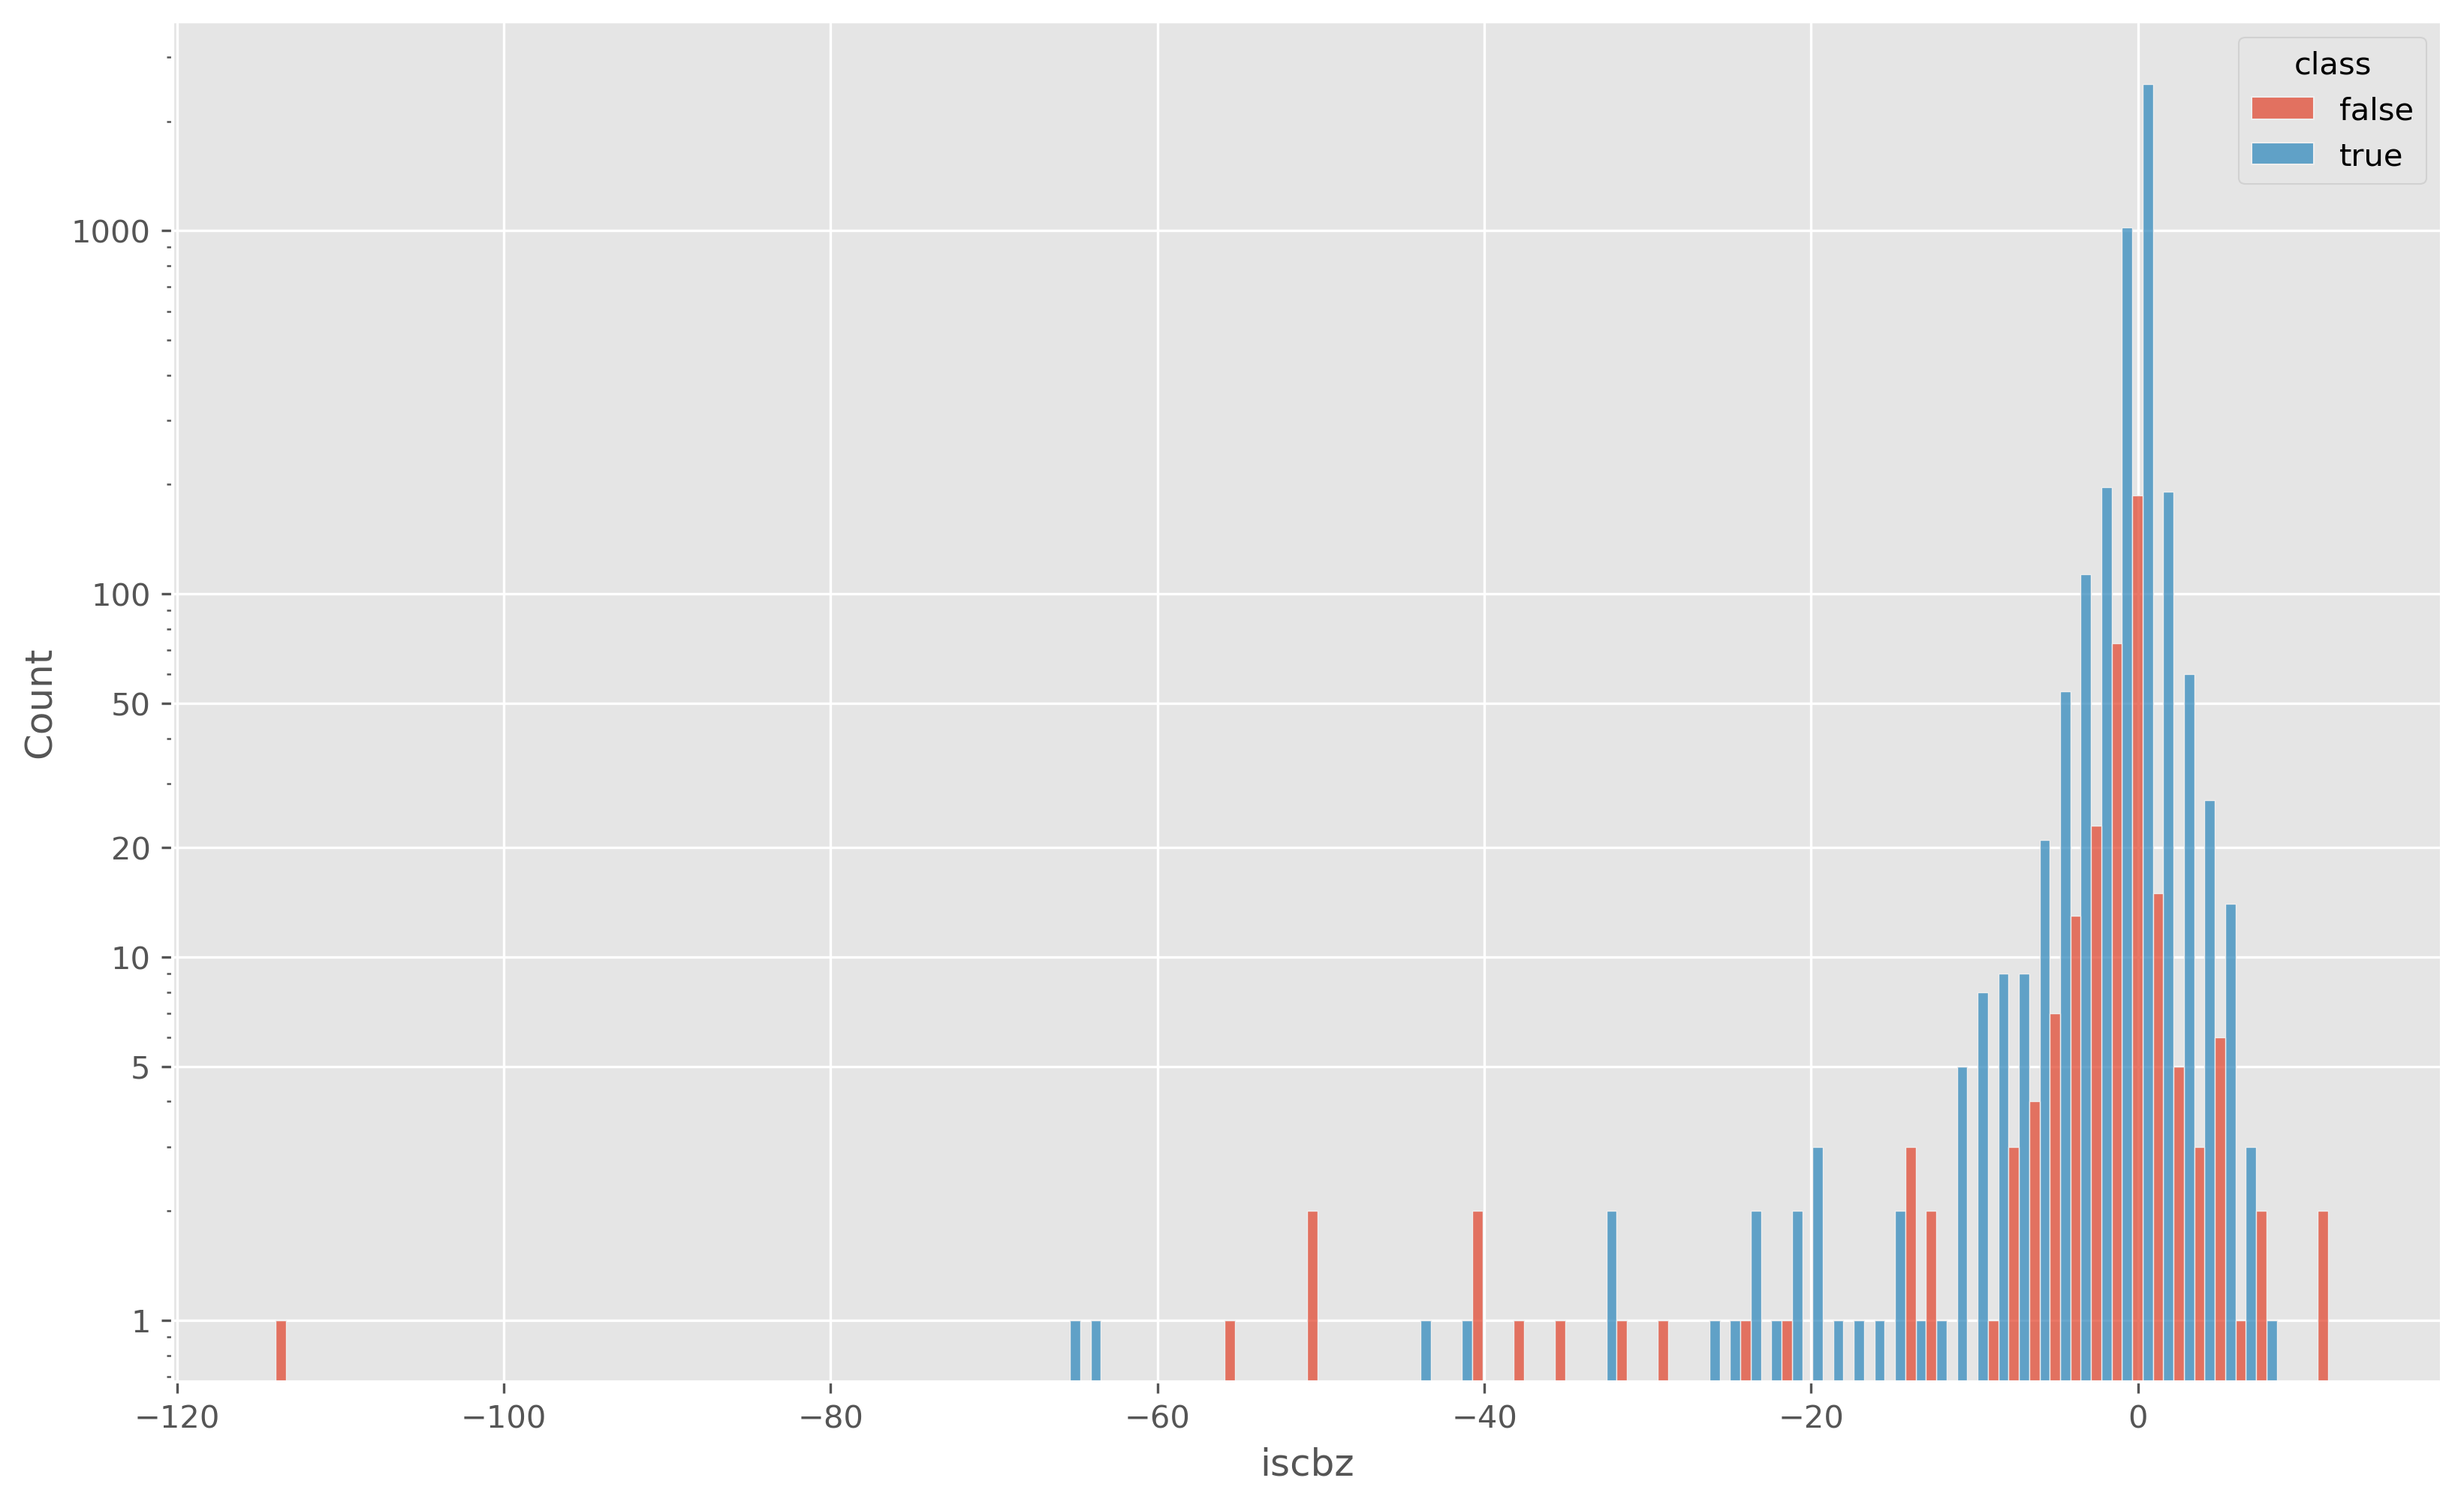

In [96]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="iscbz", hue="class", multiple="dodge", bins=100)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 1000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 30))

In [39]:
# ratios = []
# for i in range(0, 10):
#     f, t = df.query("iscbz>@i").groupby(["class"])["iscbz"].count()
#     total = f+t
#     r = f/total
#     ratios.append(r)


In [ ]:
# fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
# ax.plot(ratios)
# ax.legend()
# ax.set_yscale("log")
# ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)

In [132]:
df.query("vdb<1e-8")

,index,qual,class,depth,rel_depth,mqbz,rpbz,scbz,sp,scr,frs,vdb,mqsbz
12,12,9.72171,false,245.0,1.689655,NaN,-7.965410,5.04112,10.0,160.0,0.527132,7.556870e-23,NaN
15,15,225.29200,false,137.0,0.944828,-0.480023,-0.839571,-1.88386,0.0,71.0,0.930233,1.393790e-12,1.383090
16,16,161.14800,false,137.0,0.944828,-0.627427,0.177583,-2.48092,8.0,71.0,0.886364,2.737710e-12,1.390440
17,17,228.29200,false,113.0,0.779310,-0.483120,0.523563,-1.05621,4.0,71.0,0.929412,3.619500e-12,1.466700
18,18,228.32300,false,109.0,0.751724,-0.402487,-1.258930,-1.31057,2.0,71.0,0.950000,4.004760e-12,1.432460
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,560,72.81050,true,50.0,0.847458,-0.160128,0.998209,-1.28554,0.0,48.0,0.975000,1.829610e-10,-1.527530
7120,793,211.41700,true,26.0,0.440678,NaN,NaN,NaN,0.0,19.0,1.000000,1.140020e-09,NaN
7209,882,219.41700,true,38.0,0.644068,-0.828781,-1.179600,-1.95984,0.0,30.0,0.869565,4.083510e-10,0.683709
7489,1162,227.35800,true,50.0,1.219512,-0.894427,-4.131530,1.87709,17.0,40.0,0.555556,9.286240e-09,1.118030


In [9]:
def bcftools_filter(vcf, output, opts):
    !python ../scripts/apply_filters.py -i {vcf} -o {output} {opts} 2> /dev/null
#     !bcftools view {opts} -o {output} {vcf}

In [81]:
filter_dir = Path("filter") / pileup_id
filter_dir.mkdir(exist_ok=True)

In [92]:
min_qual = 60
# max_scbz = 5
# max_scr = 170
min_vdb = 1e-8
min_frs = 0.9
filter_id = f"q{min_qual}V1e-8K0.9"

with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        query = call_dir / f"{s}.calls.vcf.gz"
        output = filter_dir / f"{s}.{filter_id}.bcf"
        opts = f"-V {min_vdb:.10f} -q {min_qual} -K {min_frs}"
        jobs.append((query, output, opts))
    pool.starmap(bcftools_filter, jobs)

In [93]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        vcf = filter_dir / f"{s}.{filter_id}.bcf"
        opts = "-f"
        jobs.append((vcf, opts))
    pool.starmap(bcftools_index, jobs)

Run hap.py for filtered data

In [84]:
eval_dir = Path("eval")
eval_dir.mkdir(exist_ok=True)

In [85]:
def happy(truth, query, ref, opts):
    uri = "docker://quay.io/biocontainers/hap.py:0.3.14--py27h5c5a3ab_0"
    !singularity exec {uri} hap.py {opts} -r {ref} {truth} {query} &> /dev/null

In [94]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        q = filter_dir / f"{s}.{filter_id}.bcf"
        t = truth_dir / f"{s}.truth.vcf.gz"
        prefix_dir = eval_dir / pileup_id / filter_id / s
        prefix_dir.mkdir(exist_ok=True, parents=True)
        prefix = prefix_dir / f"{s}.filter"
        opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
        jobs.append((t, q, h37rv, opts))
    pool.starmap(happy, jobs)

Run hap.py for unfiltered data

In [87]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        q = call_dir / f"{s}.calls.vcf.gz"
        t = truth_dir / f"{s}.truth.vcf.gz"
        prefix_dir = eval_dir / pileup_id / filter_id / s
        prefix_dir.mkdir(exist_ok=True)
        prefix = prefix_dir / f"{s}.nofilter"
        opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
        jobs.append((t, q, h37rv, opts))
    pool.starmap(happy, jobs)
        

Run hap.py for unfiltered v1.12 data

In [30]:
v112_call_dir = Path("../nanopore/snp_calls/madagascar/")
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = v112_call_dir / f"{s}.snps.bcf"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.v112.nofilter"
#         opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)

Run hap.py for filtered v1.12 data

In [31]:
v112_filter_dir = Path("../nanopore/filtered_snps/madagascar/")
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = v112_filter_dir / f"{s}.snps.filtered.bcf"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.v112.filter"
#         opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)

In [32]:
compass_dir = Path("../illumina/gvcfs/")
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = compass_dir / f"{s}.compass.vcf.gz"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.compass.filter"
#         opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)

Get COMPASS unfiltered by not using `--pass-only`

In [33]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = compass_dir / f"{s}.compass.vcf.gz"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.compass.nofilter"
#         opts = f"--set-gt hom --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)

In [98]:
info = []
summaries = eval_dir.rglob("*summary.csv")
for csv in summaries:
    s = csv.name.split(".")[0]
    sheet = pd.read_csv(csv).query("Type=='SNP' and Filter=='PASS'").to_dict(orient="records")[0]
    filtered = not ("nofilter" in csv.name)
    if "compass" in csv.name:
        version = "Illumina unfiltered" if not filtered else "Illumina filtered"
    elif "v112" in csv.name:
        version = "v1.12 unfiltered" if not filtered else "v1.12 filtered"
    else:
        version = f"{csv.parts[-4]} unfiltered" if not filtered else f"{csv.parts[-4]} {csv.parts[-3]}"
    filtered = not ("nofilter" in csv.name)

    if version == "Illumina" and not filtered:
        d = pd.read_csv(csv).query("Type=='SNP' and Filter=='ALL'").to_dict(orient="records")[0]
        info.append(
        (
            s, version, False, d["TRUTH.TOTAL"], d["TRUTH.TP"], 
            d["TRUTH.FN"], d["QUERY.TOTAL"], d["QUERY.FP"], d["METRIC.Recall"],
            d["METRIC.Precision"], d["METRIC.F1_Score"]
        )
    )
    else:
        info.append(
            (
                s, version, filtered, sheet["TRUTH.TOTAL"], sheet["TRUTH.TP"], 
                sheet["TRUTH.FN"], sheet["QUERY.TOTAL"], sheet["QUERY.FP"], sheet["METRIC.Recall"],
                sheet["METRIC.Precision"], sheet["METRIC.F1_Score"]
            )
        )

metrics = pd.DataFrame(
info, 
columns=[
    "sample", "version", "filtered", 
    "expected", "TP", "FN", "predicted", 
    "FP", "Recall", "Precision", "F1"
]
)

In [99]:
metrics.sort_values(by="version", inplace=True)

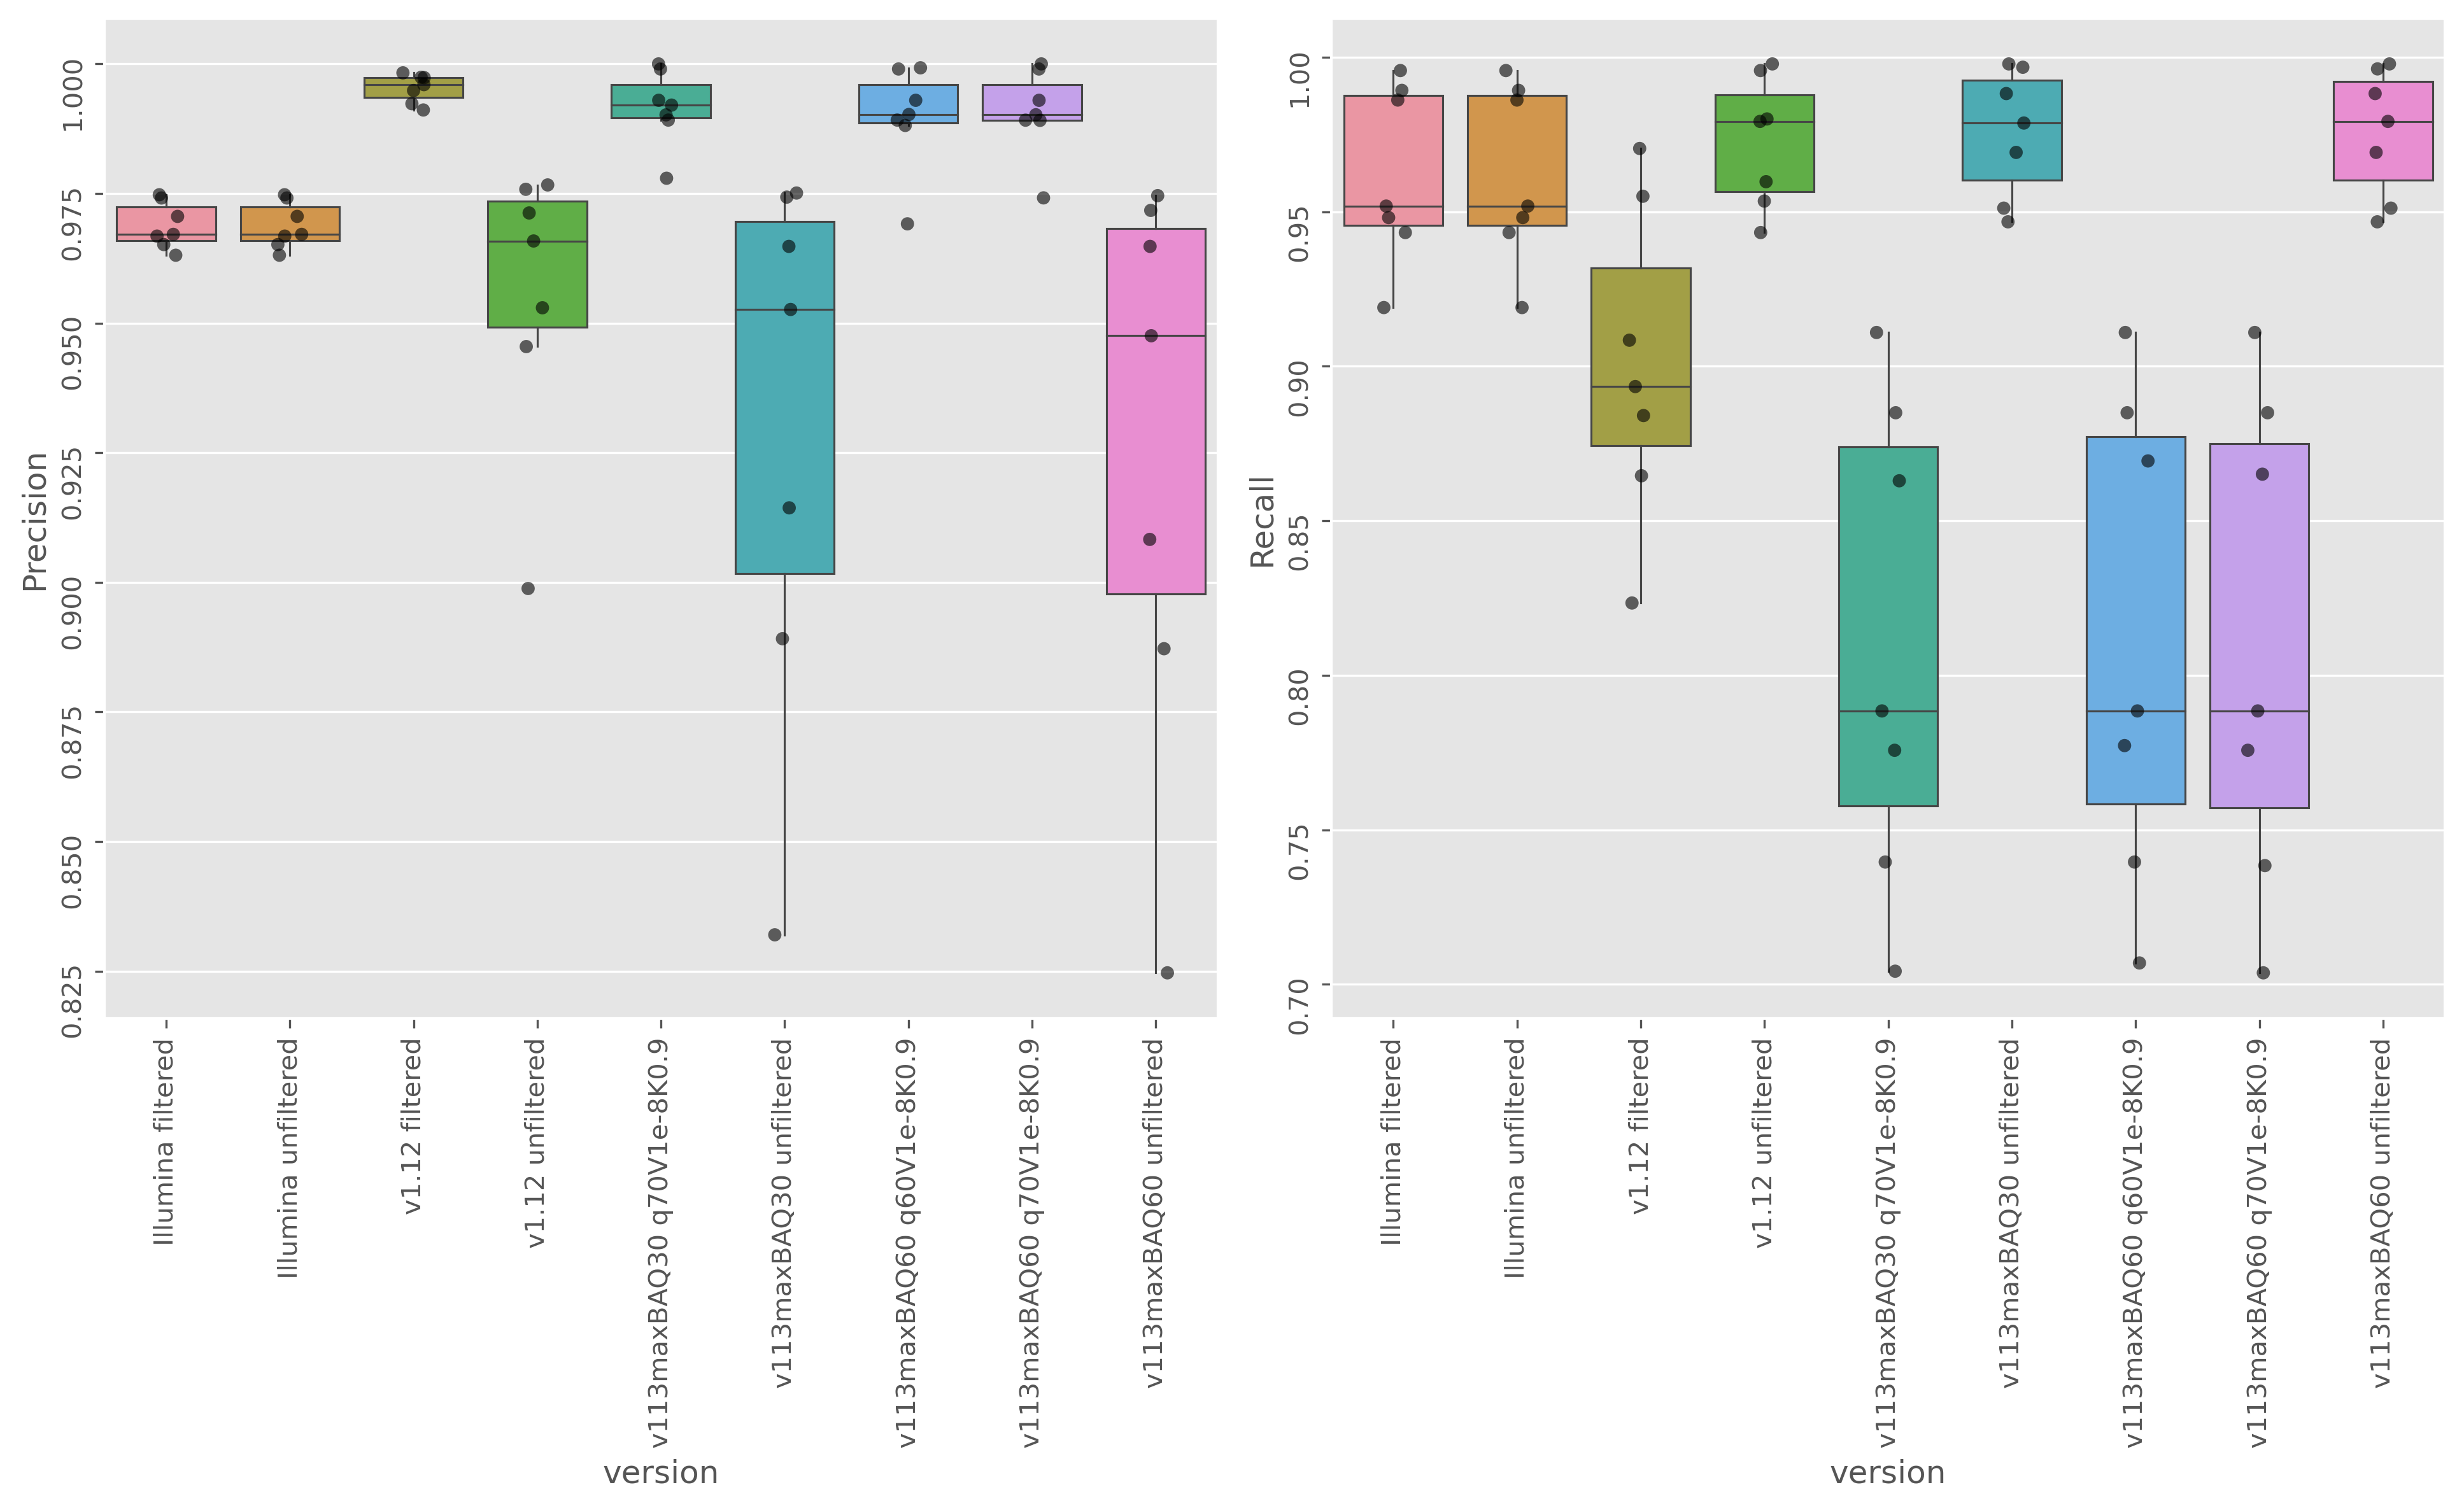

In [111]:
import matplotlib.ticker as ticker
from matplotlib.scale import LogisticTransform as LogisticScale
boxprops = dict(linewidth=0.75, fliersize=0, showcaps=False)
stripprops = dict(dodge=True, color="black", alpha=0.6)
fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300)
axl = axes.flatten()[0]
axr = axes.flatten()[1]
hue = "version"





axl = sns.boxplot(data=metrics, y="Precision", x=hue, ax=axl, **boxprops)
axl = sns.stripplot(data=metrics, y="Precision", x=hue, ax=axl, **stripprops)
# axl.set_yscale('function', functions=(forward, inverse))
# axl.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# axl.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

axr = sns.boxplot(data=metrics, x=hue, y="Recall", ax=axr, **boxprops)
axr = sns.stripplot(data=metrics, x=hue, y="Recall", ax=axr, **stripprops)
# axr.set_yscale('function', functions=(forward, inverse))
# axr.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# axr.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))


# ylabels = [0.7, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.990, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 0.9995, 1.0]
# axl.set_yticks(ylabels)
# axl.set_yticklabels(ylabels)
# axr.set_yticks(ylabels)
# axr.set_yticklabels(ylabels)

# axl.yaxis.set_major_locator(ticker.LogitLocator([0.8, 0.91, 0.991], nbins=1000))
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# ylabs = []

# for tlab in ax.get_yticklabels():
#     x, y = tlab.get_position()
#     break
#     if y in ylabels:
#         tlab.set(fontsize="2")
#     ylabs.append(tlab)
    
# ax.set_yticklabels(ylabs)

# leghandles, leglabels = ax.get_legend_handles_labels()
# ax.legend(leghandles[:3], leglabels[:3], loc="upper right", prop={"size": 11})
# _ = plt.yticks(fontsize="9")
# ax.set_yscale("logit")
# ylabels = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.990, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)
# # ax.set_xlim((0, 30))
# leghandles, leglabels = axl.get_legend_handles_labels()
# axl.legend(leghandles[:4], leglabels[:4], loc="best", prop={"size": 11})
# axr.get_legend().remove()
axl.tick_params(labelrotation=90)
axr.tick_params(labelrotation=90)
plt.tight_layout()

In [ ]:
metrics.groupby(["version", "filters"]).describe()

In [62]:
from scipy.special import expit, logit
# Function logistic transform
def forward(x):
    return expit(x)


def inverse(x):
    return logit(x)




In [63]:
x = 0.9
forward(x)

0.7109495026250039

In [65]:
inverse(forward(x))

0.8999999999999997